In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   
#from Models import *
import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [3]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)

(69, 57, 75)


In [4]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [5]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [6]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol2.shape)
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(110, 155, 199)
25
(15, 15, 15)
25


In [7]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [8]:
#Here we create Vol1 orthogonal to Vol2
"""
import copy 
print(Vol2.shape)
vecVol2 = Vol2.reshape(-1, order = 'F')
print(vecVol2.shape)
vecVol1 = copy.deepcopy(vecVol2)
for i in range(3375 - 1):
    if i % 2 == 0:
        vecVol1[i] = - vecVol2[i + 1]
    else:
        vecVol1[i] = vecVol2[i - 1]
vecVol1[-1] = 0
print(np.sum(vecVol1*vecVol2))
print(vecVol2[1500:1506])
print(vecVol1[1500:1506])
Vol1 = vecVol1.reshape(15, 15, 15 , order = 'F')
"""


"\nimport copy \nprint(Vol2.shape)\nvecVol2 = Vol2.reshape(-1, order = 'F')\nprint(vecVol2.shape)\nvecVol1 = copy.deepcopy(vecVol2)\nfor i in range(3375 - 1):\n    if i % 2 == 0:\n        vecVol1[i] = - vecVol2[i + 1]\n    else:\n        vecVol1[i] = vecVol2[i - 1]\nvecVol1[-1] = 0\nprint(np.sum(vecVol1*vecVol2))\nprint(vecVol2[1500:1506])\nprint(vecVol1[1500:1506])\nVol1 = vecVol1.reshape(15, 15, 15 , order = 'F')\n"

In [9]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.05595616


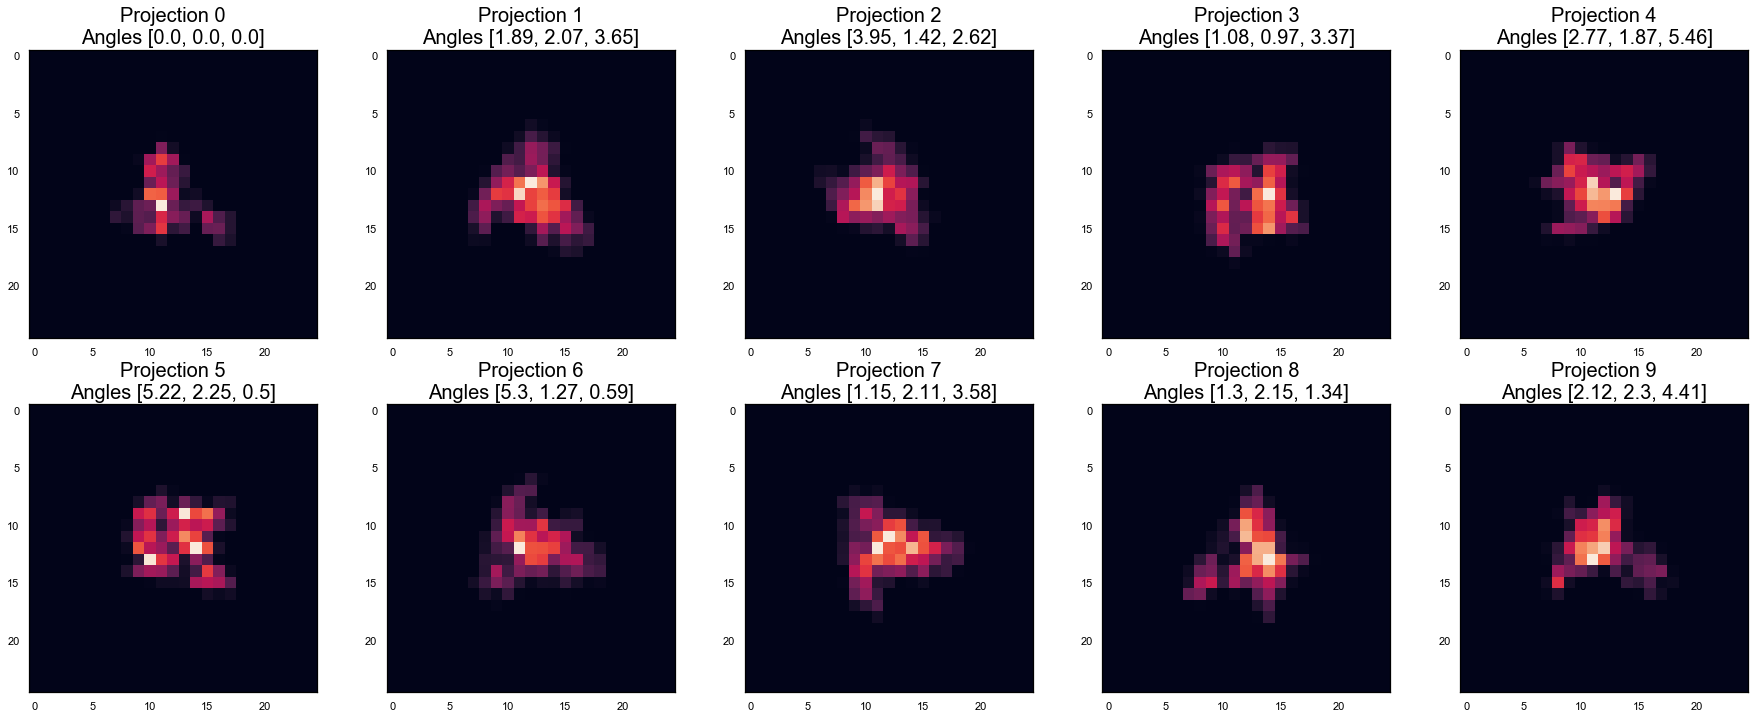

0.29594502


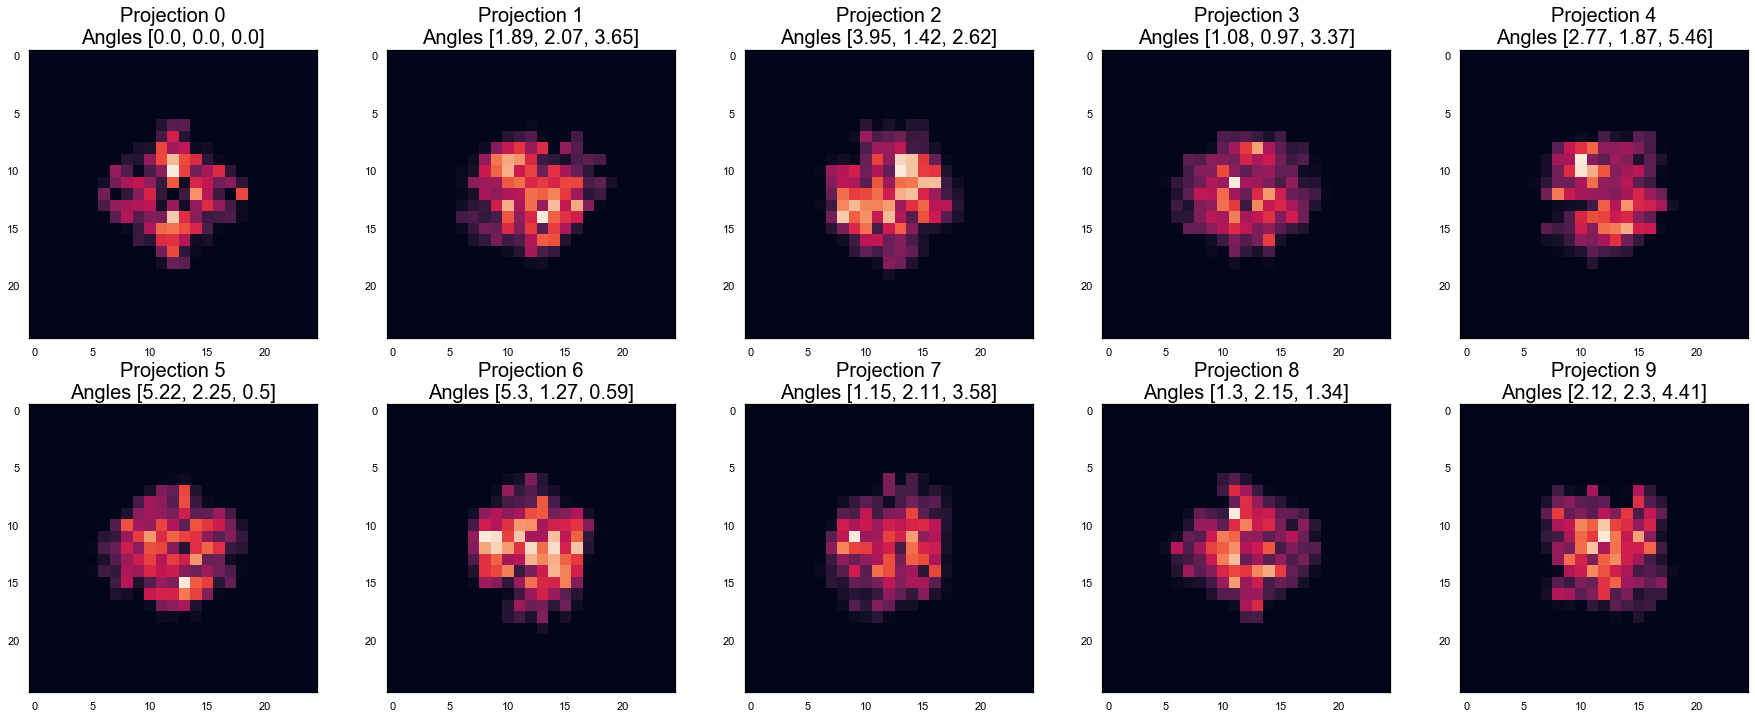

In [10]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [11]:
#BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [12]:
#print(BP_data.shape)
##print(BP_data[0].shape)
#print(Projections[0].shape)
#print(np.sum(BP_data[0] - Projections[0]))

In [13]:
#CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
#pids = range(10)
#plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.05595616


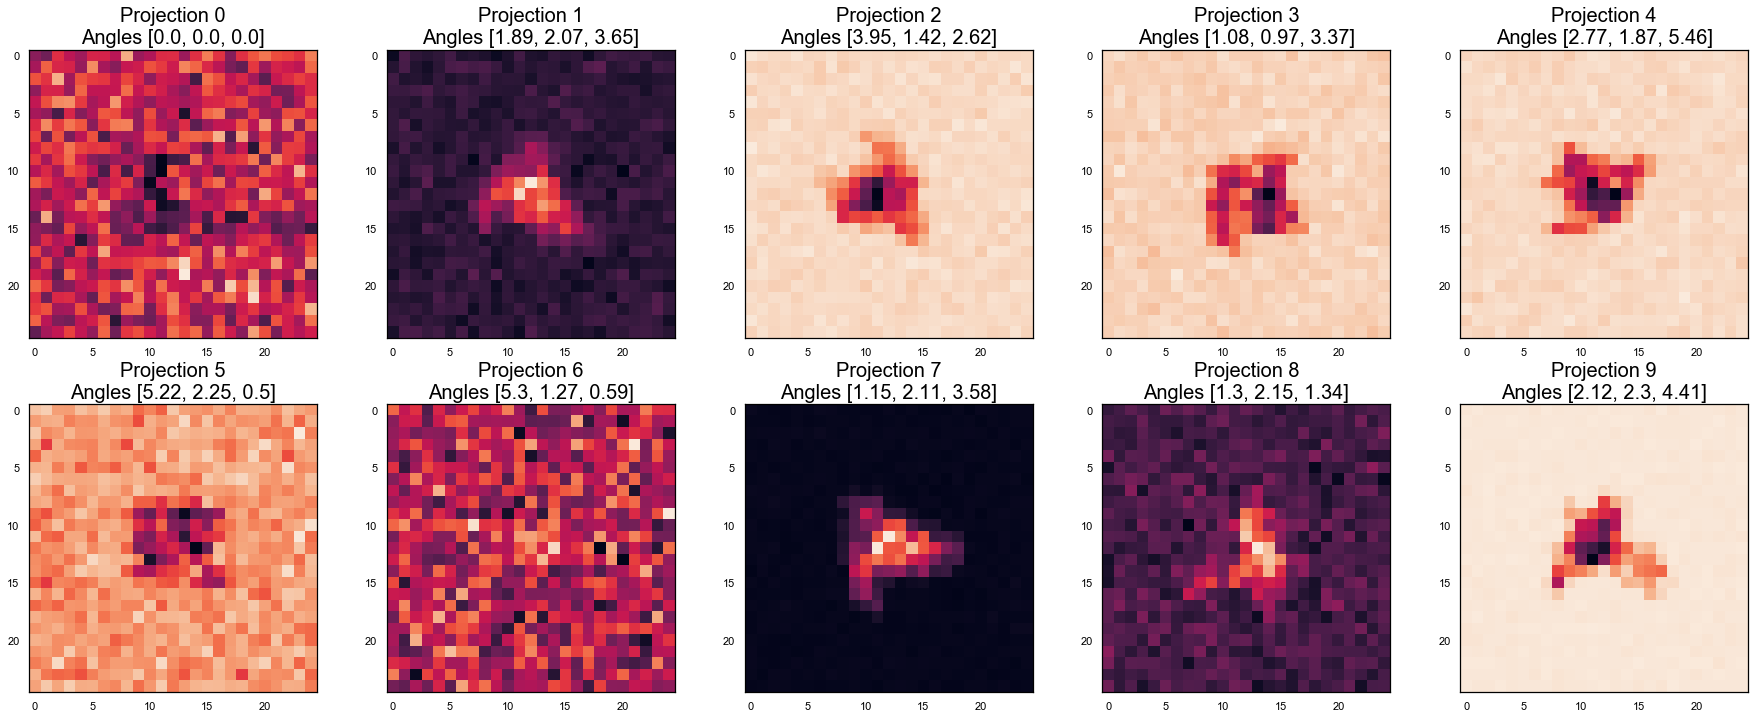

0.29594502


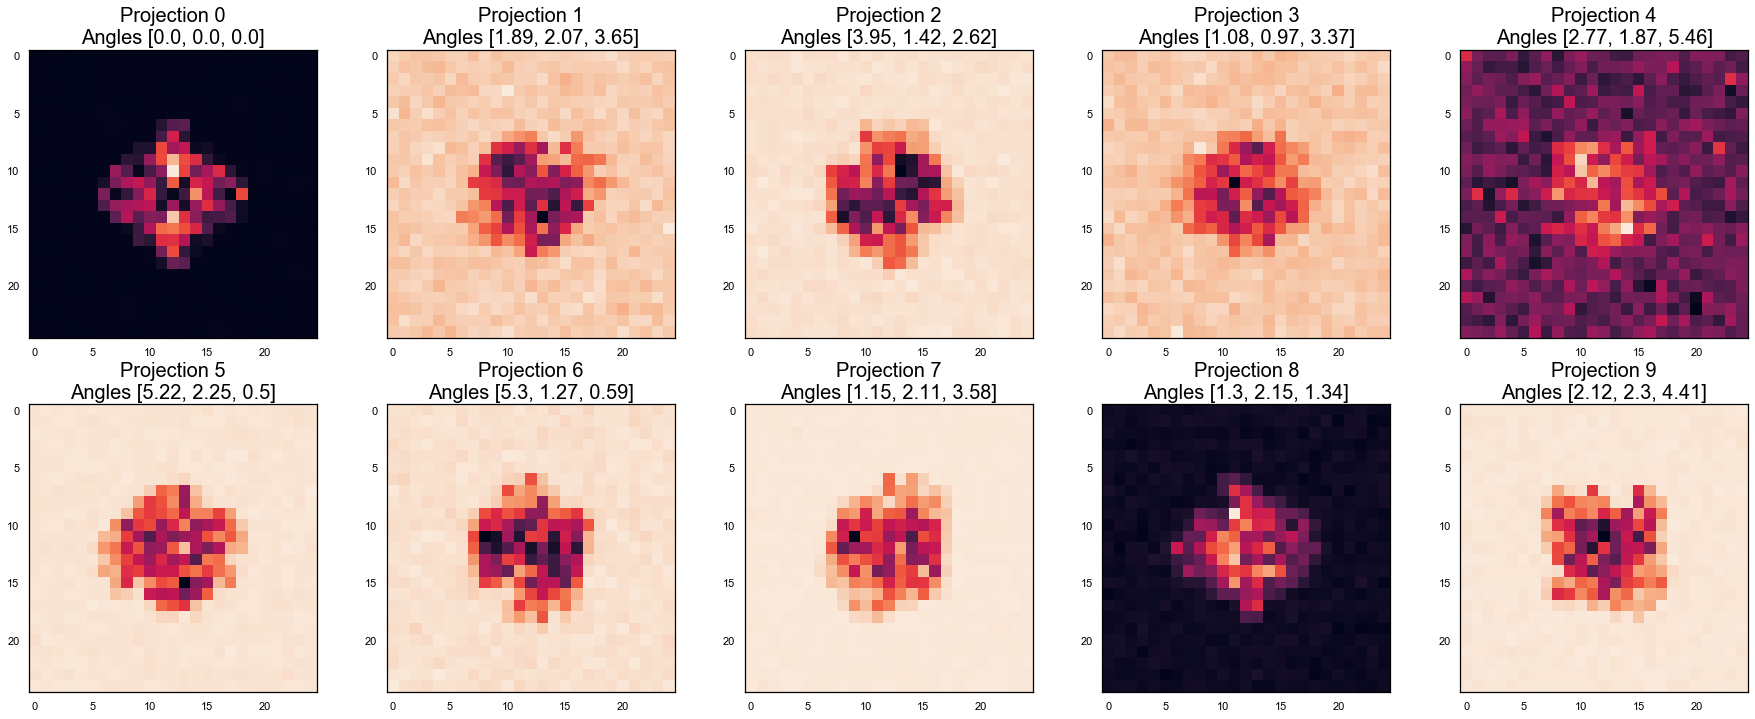

In [14]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.001 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.001 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [15]:
new_projection = Projections2 + Projections1

In [16]:
#Write a recurssive function
#Input Found mu_1, ..., mu_n-1, now_n, n_components, 

class PCA_3d_Recon_recurssive():
    def __init__(self, ProjSize, num_image, n_component, Mus = None):
        
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component

        #if Mus == None:
        ##    #This means that we are at the first iteration
        #    self.Now_n = 1
        #else:
        #We want to find the +1 component
        self.Now_n = Mus.shape[0] + 1
        
        self.Mus = np.zeros((self.Now_n, ProjSize, ProjSize, ProjSize)) + 0.00001
        self.Mus[: self.Now_n -1  , :, :, :] = Mus #Record the previous conponents
        self.sigma = np.ones(self.num_image) * 0.1


        self.ro = np.abs(np.ones((num_image, self.Now_n)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.Now_n, self.Now_n )))

        self.Aus = np.zeros(( num_image, ProjSize* ProjSize,  self.Now_n))

    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Q_(Imgages, Angles)
        self.Plot_mu_by_projection(Angles)
        for i in range(160):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 10 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
                self.Q_(Imgages, Angles)
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        for n in range(self.Now_n):
            Projections = generate_projections_ASTRA(self.Mus[n] , Angles, self.ProjSize, BatchSizeAstra = "None")
            #print(Projections.shape)
            #check_image = Projections[0].reshape(-1, 1, order = 'F')
            self.Aus[:, :, n] =  Projections.reshape(Projections.shape[0], -1 , order = 'F') #with fortrain - like order
            #print('check_Aus', check_image)
   
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        #self.Au_s(Angles)
        #ro = [] #For n image, we have n z.
        ro = np.zeros((self.num_image, self.Now_n ))
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            #ro.append(roj.tolist())
            ro[j] = roj.reshape(-1)
        #self.ro = np.array(ro).reshape(-1, self.Now_n) #Check@@@@@@@@@@
        self.ro = ro
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.Now_n, self.Now_n ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.Now_n) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.Now_n , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])

    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.Now_n):
                right_term += right_term + self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]
                #print((self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]).shape)
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.Now_n-1]
            #print('left_term', np.mean(left_term))
            #print(' self.ro[j][self.Now_n-1]' , self.ro[j][self.Now_n-1])
            temp = left_term - right_term.reshape(-1,1 , order = 'F')
            #print('left, right', np.mean(left_term), np.mean(right_term) )
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print('DeltaMu', np.mean(DeltaMu))
        #Before returning this ,since we should make the grident direction orthogonal to the previous directions, we should make
        #it orthogonal to the spam of mus
        PDeltaMu = DeltaMu.reshape(-1,1, order ='F')
        
        OriDeltaMu =  DeltaMu.reshape(-1,1, order ='F')
        Vec_Mus = self.Mus.reshape(self.Now_n, -1, 1, order = 'F')
        for i in range(self.Now_n -1):
            #print('Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu',(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu).shape)
            #print((Vec_Mus[i]*(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu)).shape)
            #print(PDeltaMu.shape)
            PDeltaMu = PDeltaMu - Vec_Mus[i]*(Vec_Mus[i].T @ OriDeltaMu / (np.linalg.norm(Vec_Mus[i]) **2))
        
        
        #print('check projected direction orthogonal mu[0]', np.sum(Vec_Mus[0] *PDeltaMu ))
        return PDeltaMu.reshape(self.ProjSize, self.ProjSize, self.ProjSize , order ='F')

    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(np.abs(self.Mus[self.Now_n -1])))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.Mus[self.Now_n -1] ) / np.mean(DeltaMu) )*0.001
            #print('lr', lr)
            self.Mus[self.Now_n -1] = self.Mus[self.Now_n -1] + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] @ self.ro[j].reshape(self.Now_n , 1)
            
            #right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            right = 0
            for x in range(self.Now_n):
                for y in range(self.Now_n):
                   right = right + self.Aus[j][: , x].T @ self.Aus[j][: , y] * self.BigSigma[j][x][y]
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        for n in range(self.Now_n):
            curremt_mu = self.Mus[n].reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
            CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
            pids = range(10)
            plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)

    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Aus[j][: ,self.Now_n - 1].reshape(-1, 1, order = 'F') * self.ro[j][self.Now_n - 1]

            #Aju =  self.Aus[j]
            #right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            right = 0
            for i in range(self.Now_n -1):
                right = right + self.Aus[j][:, i].T @ self.Aus[j][:, i] * self.BigSigma[j][i][self.Now_n - 1]
            right = right + 1/2 *  self.Aus[j][:, self.Now_n - 1].T @ self.Aus[j][:, self.Now_n - 1] * self.BigSigma[j][self.Now_n -1][self.Now_n -1]

            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass



class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))

        self.Aus = np.zeros((n_component, num_image, ProjSize* ProjSize, 1))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(160):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 10 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
              
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
        self.Au_s(Angles)
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
   
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


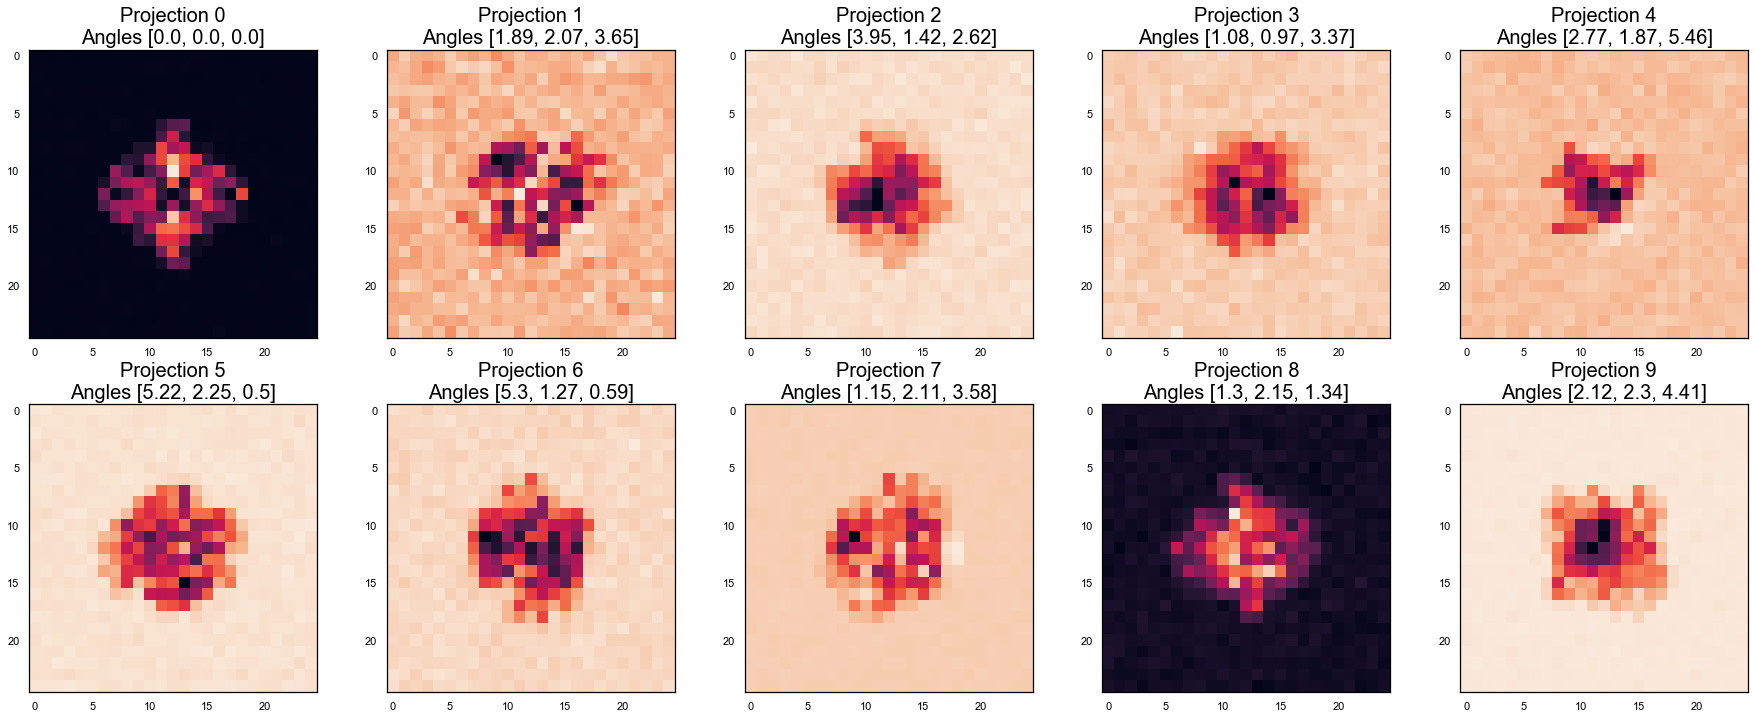

start fitting
The 0-th iteration


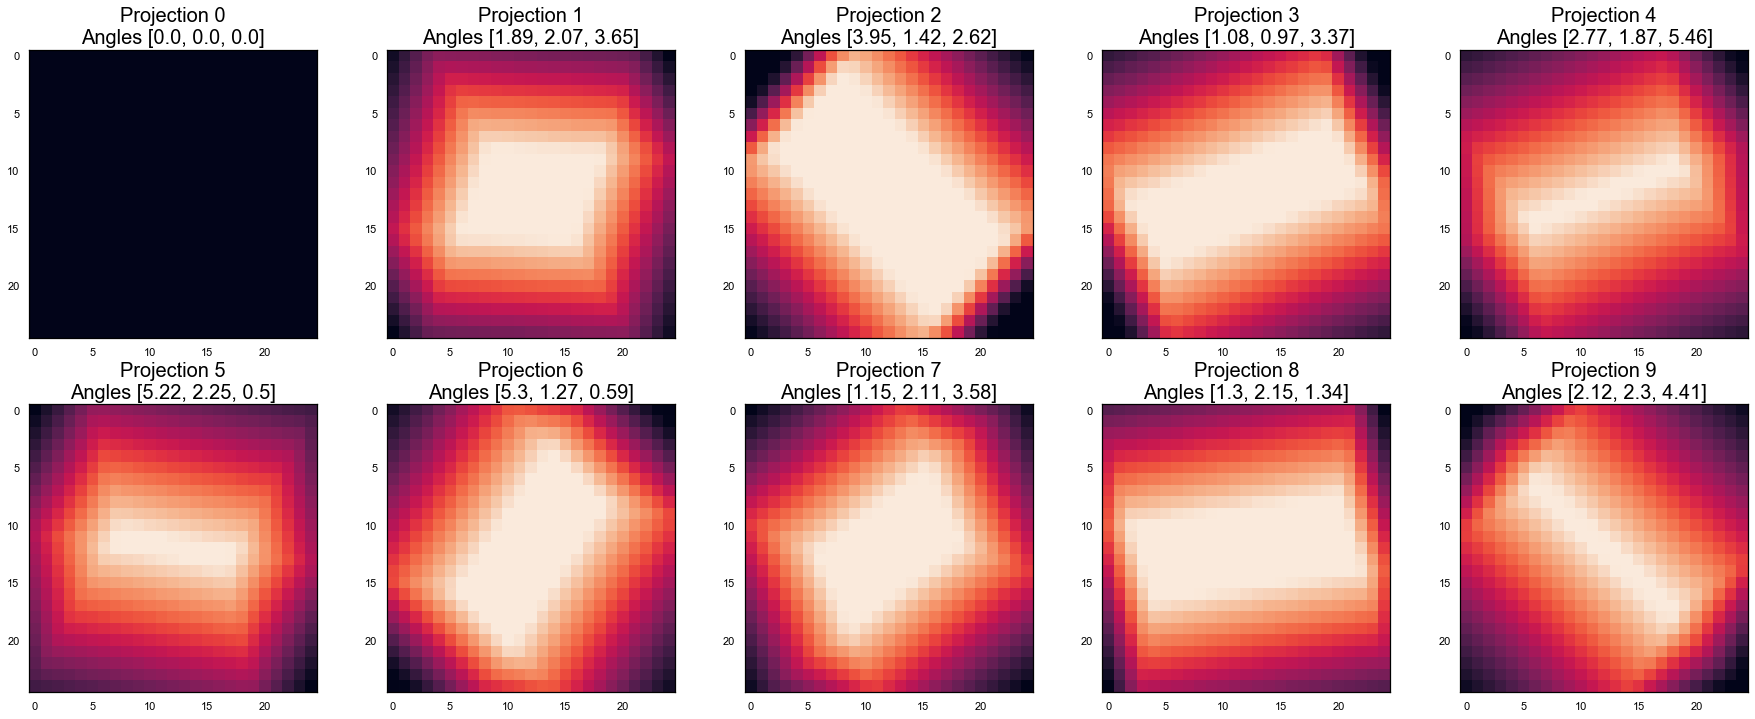

The 1-th iteration


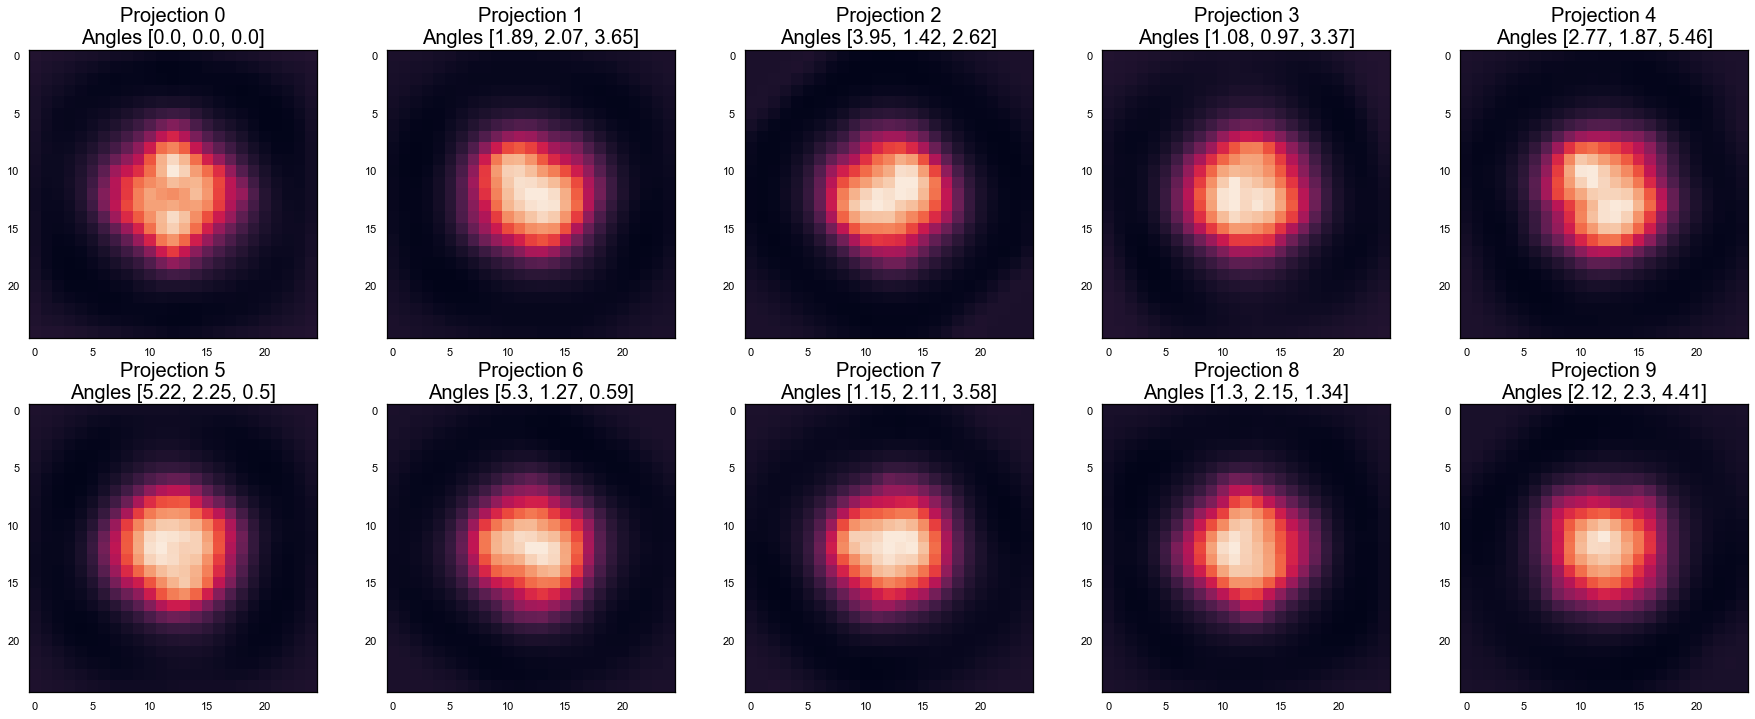

The 11-th iteration


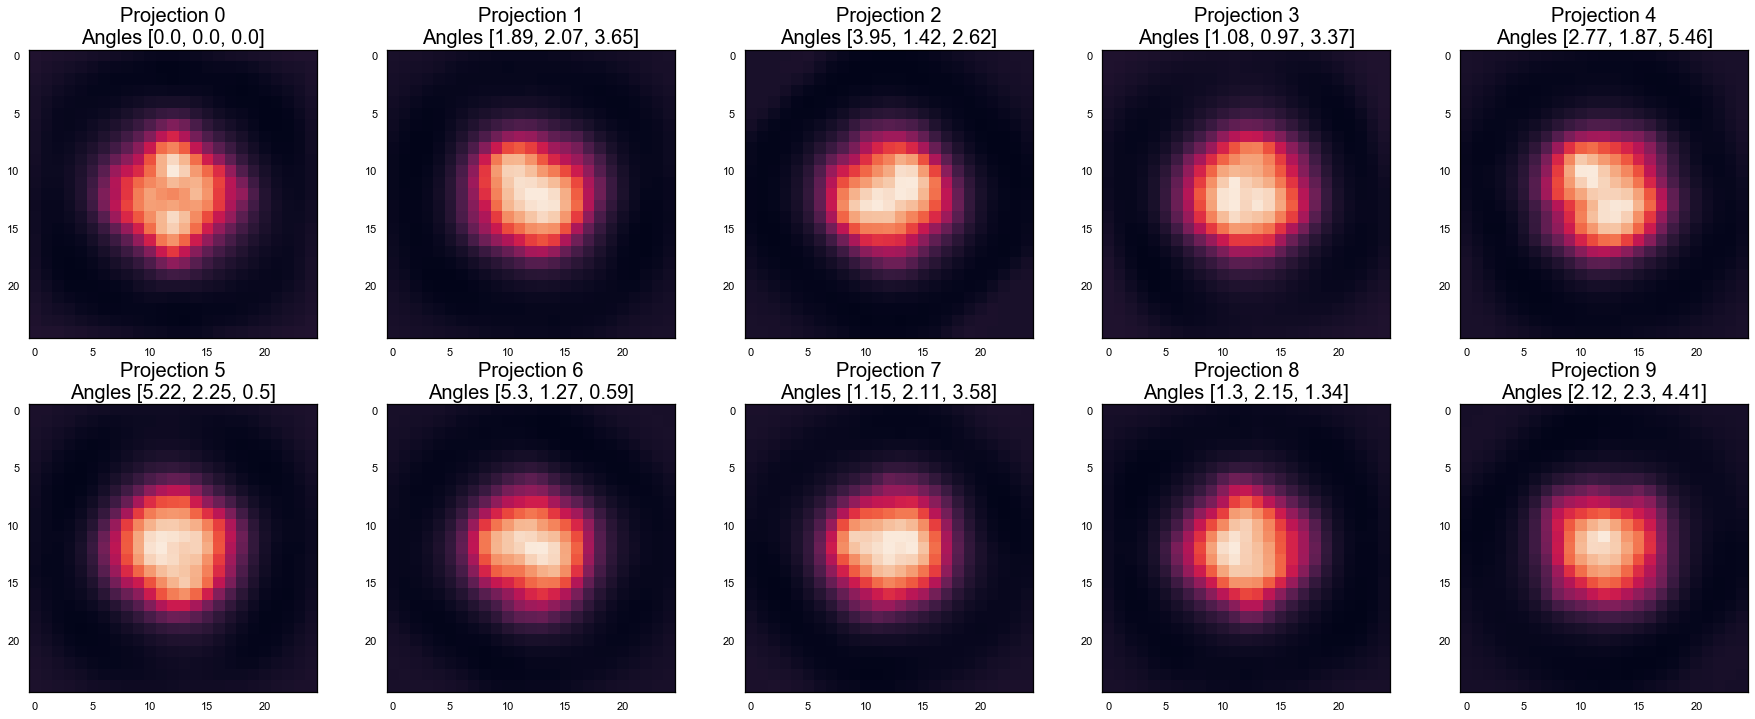

The 21-th iteration


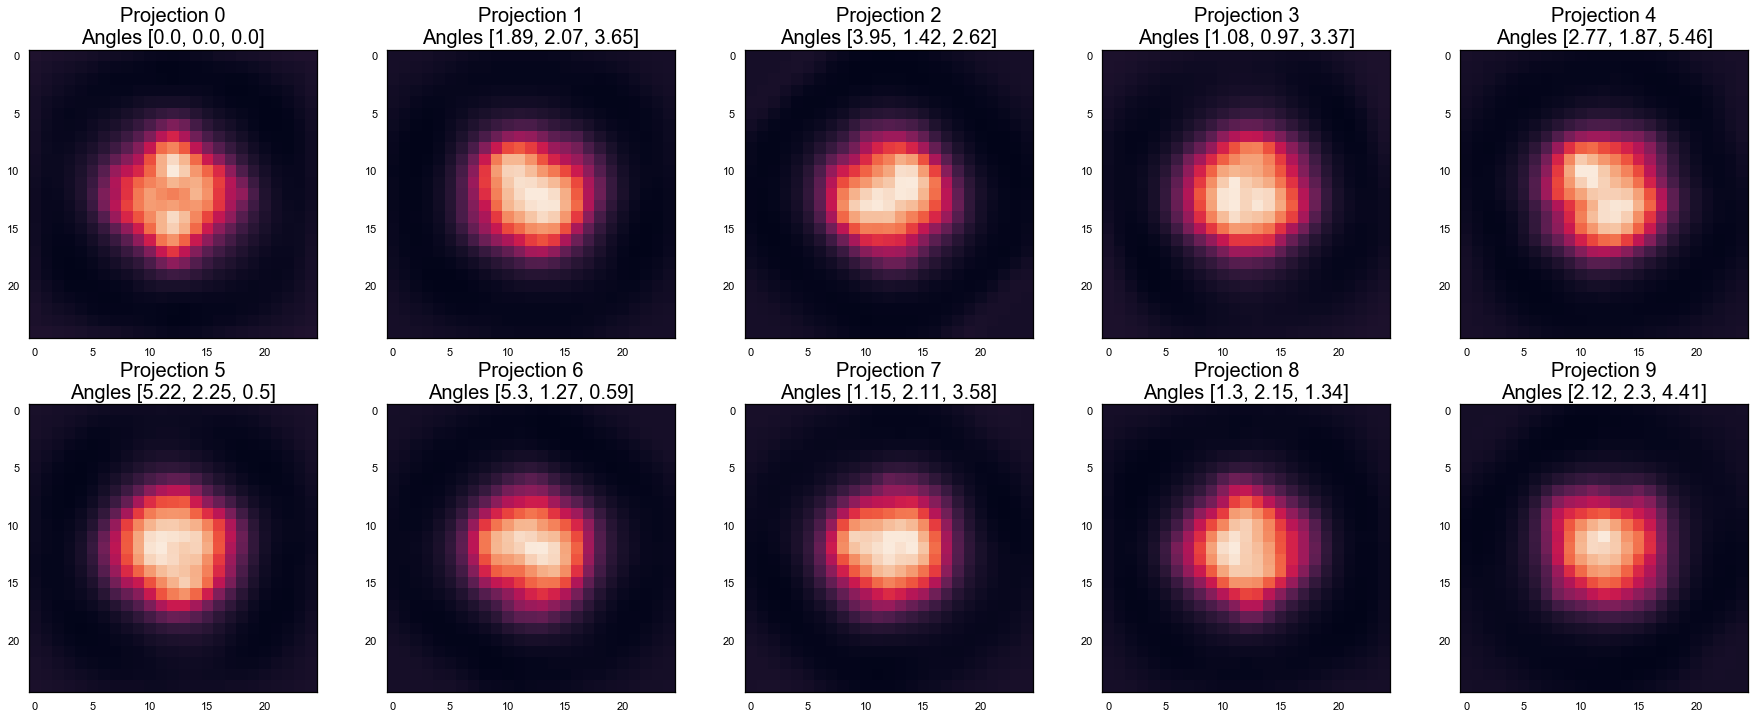

The 31-th iteration


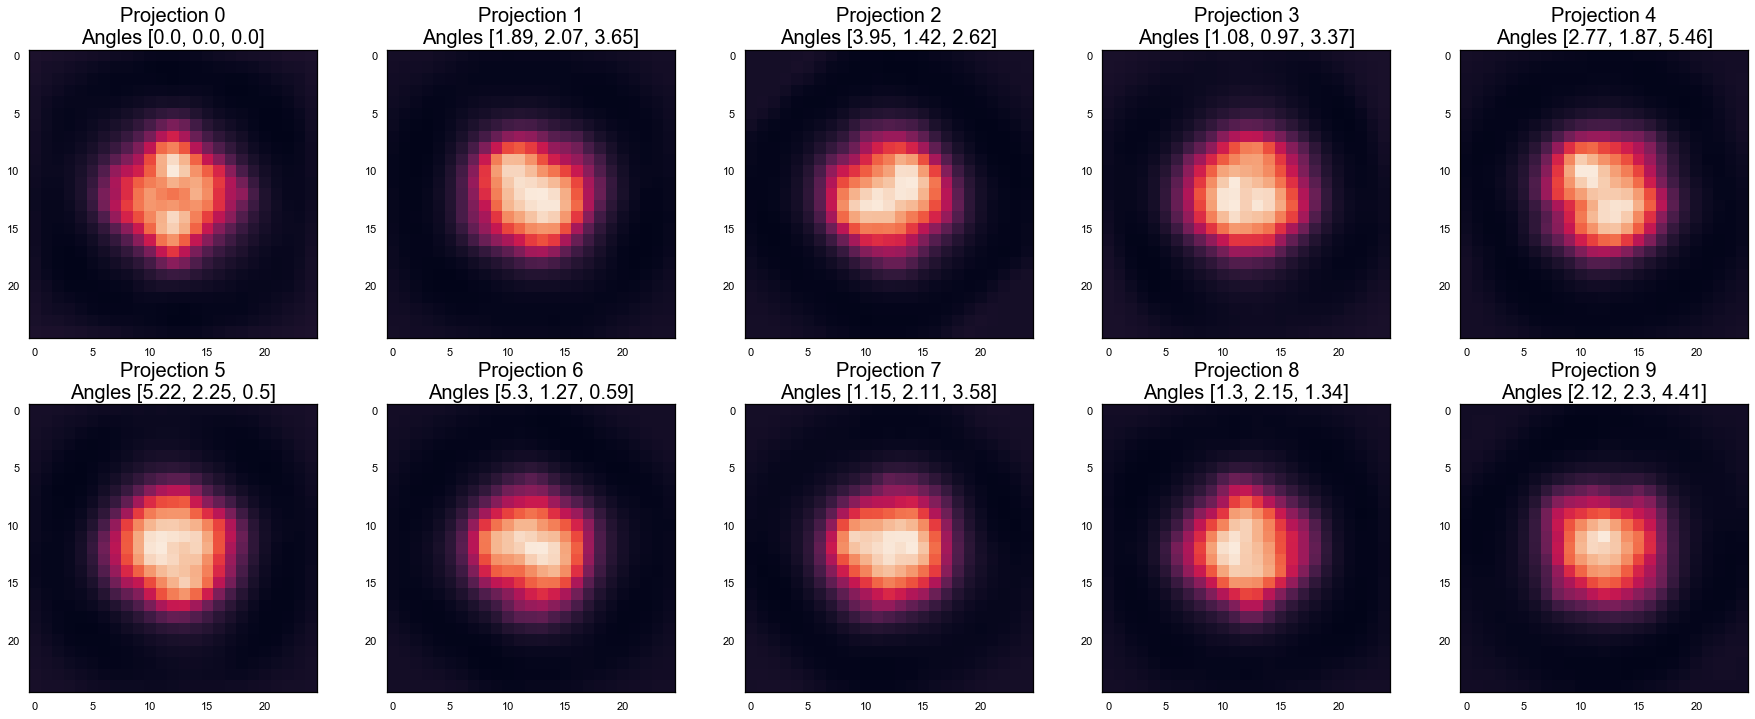

The 41-th iteration


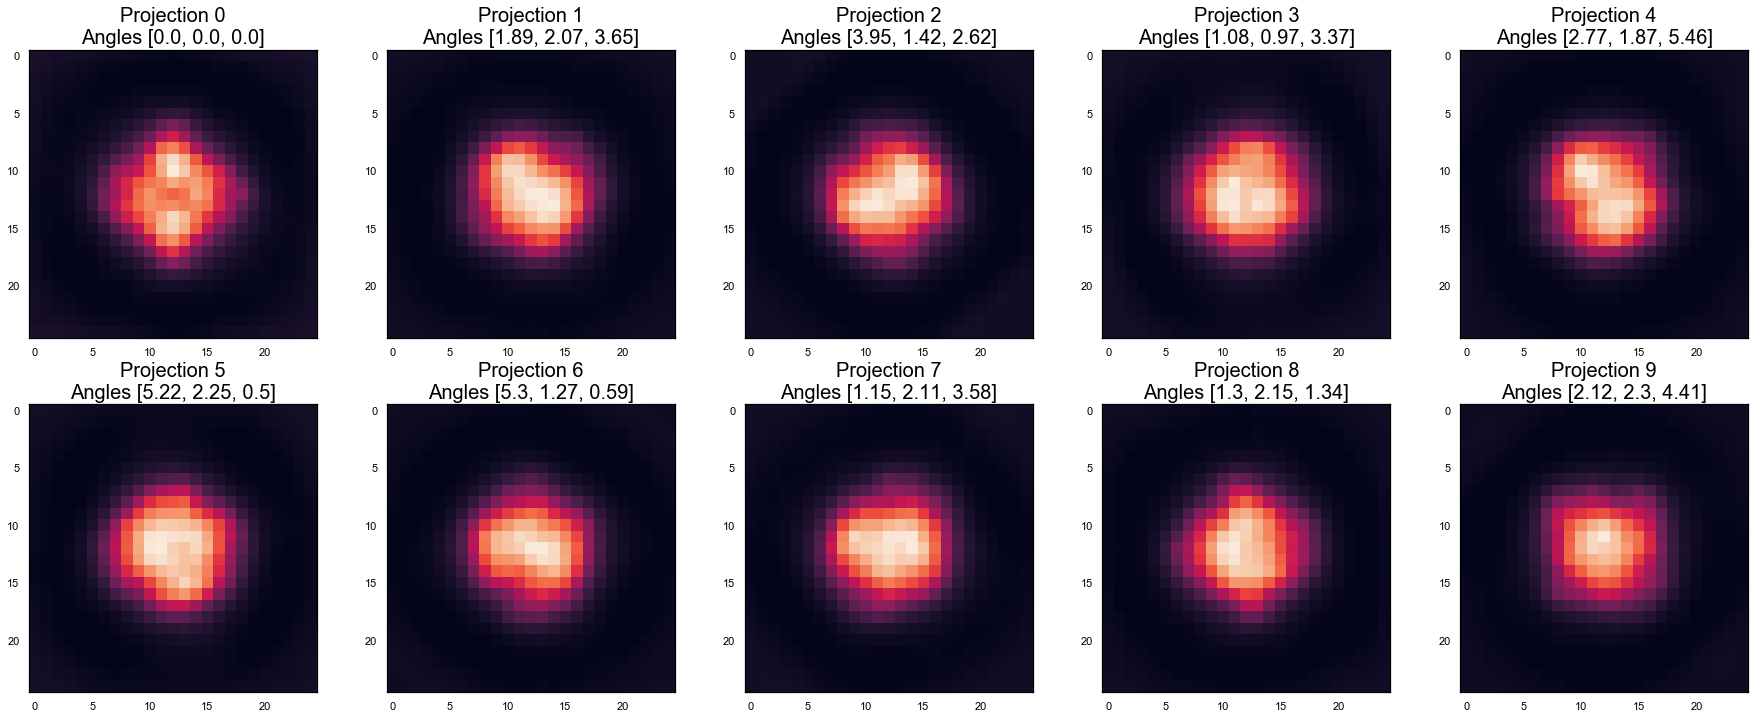

The 51-th iteration


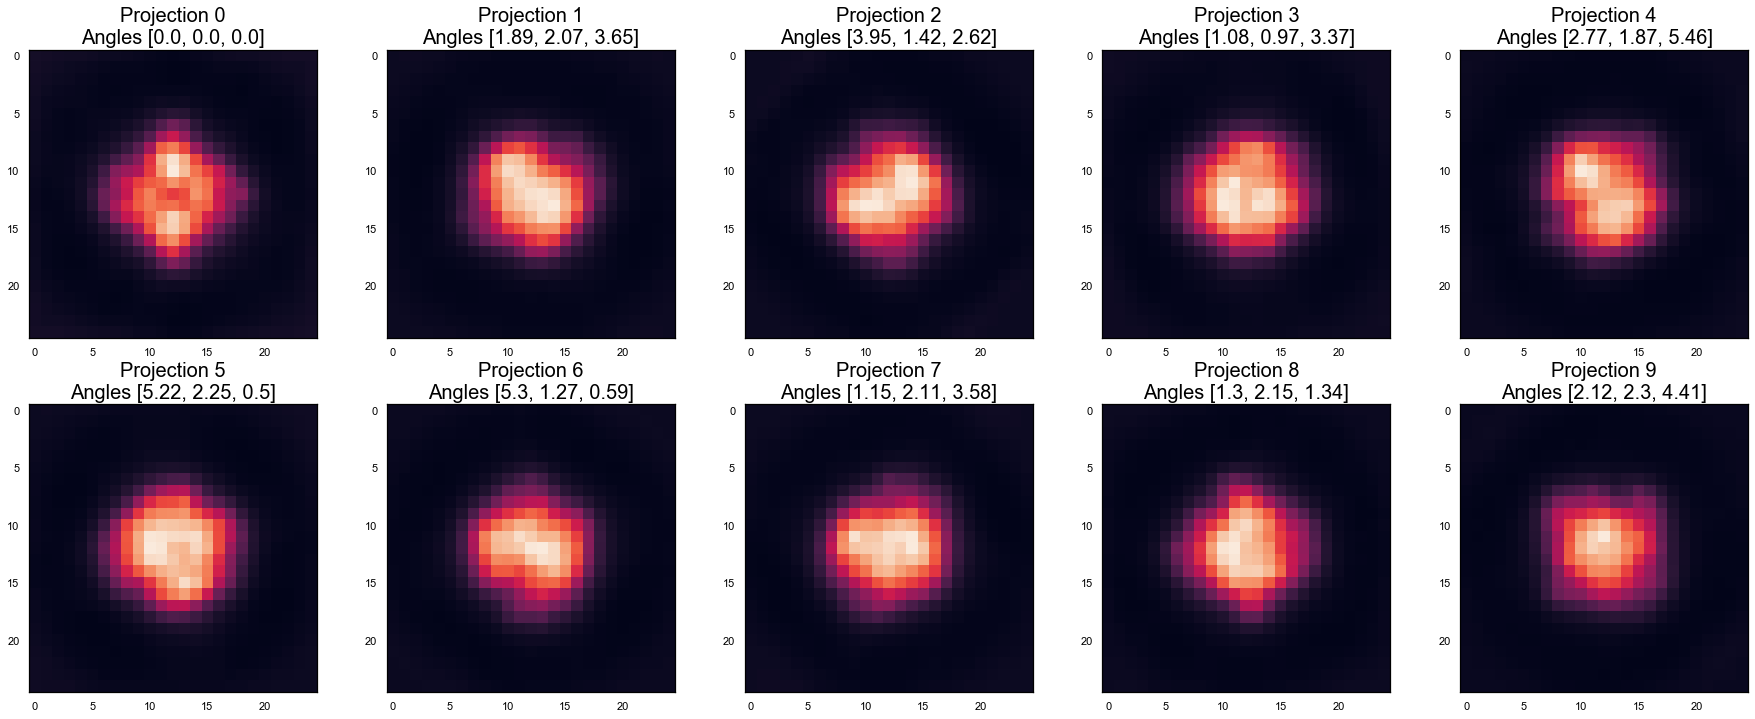

The 61-th iteration


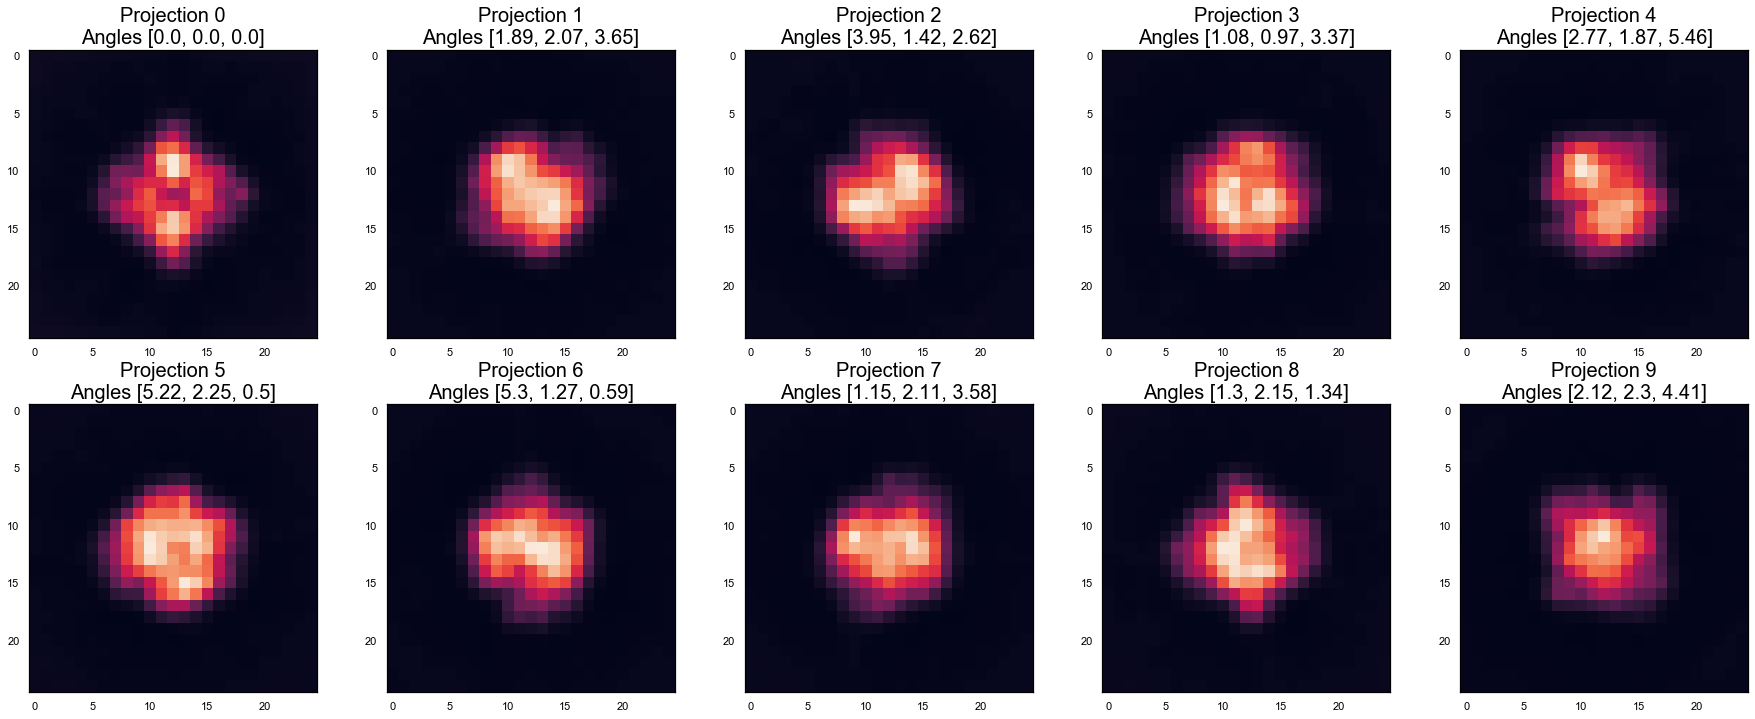

The 71-th iteration


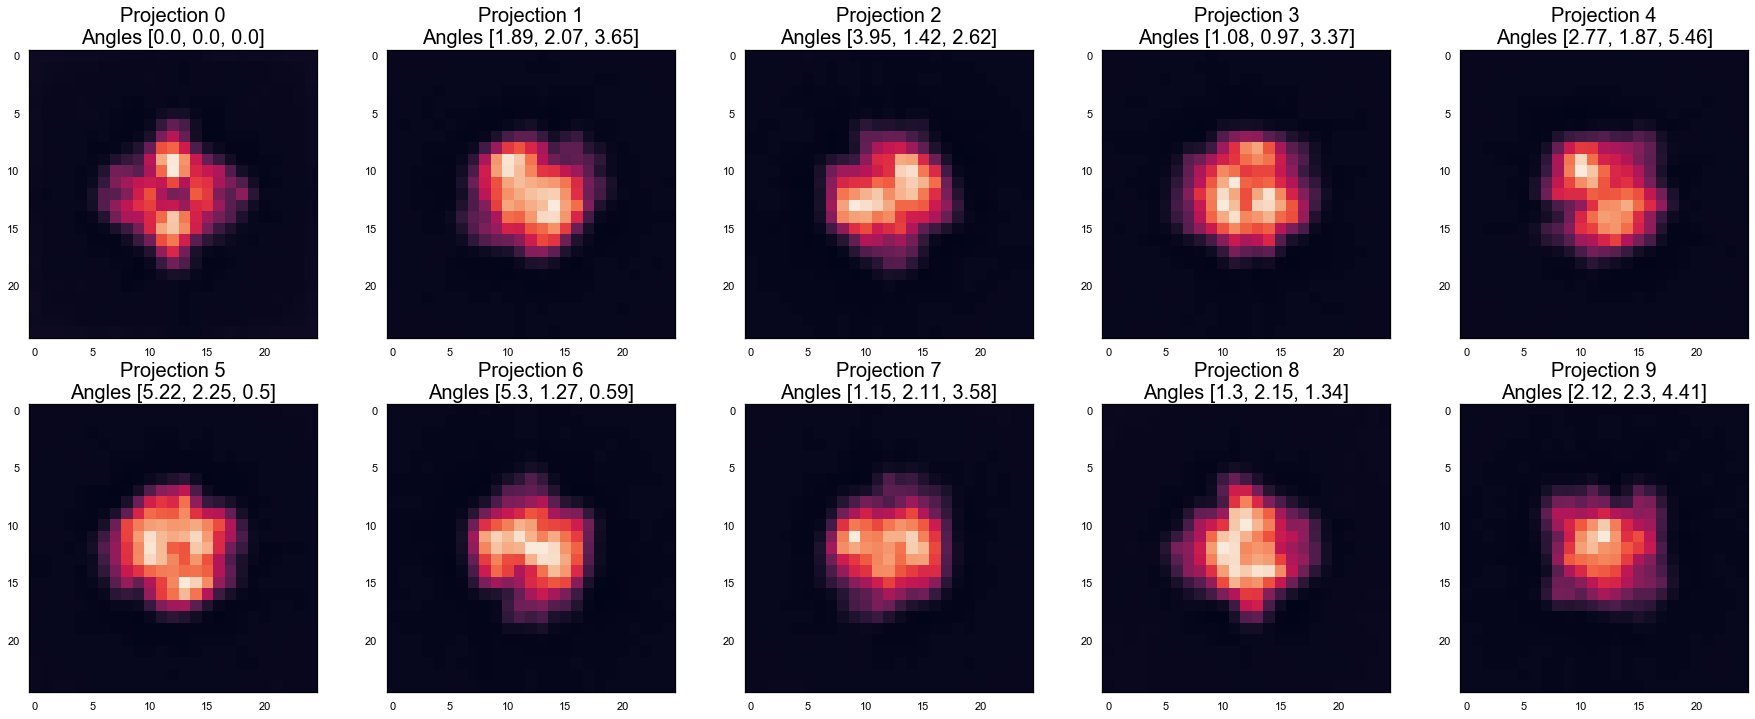

The 81-th iteration


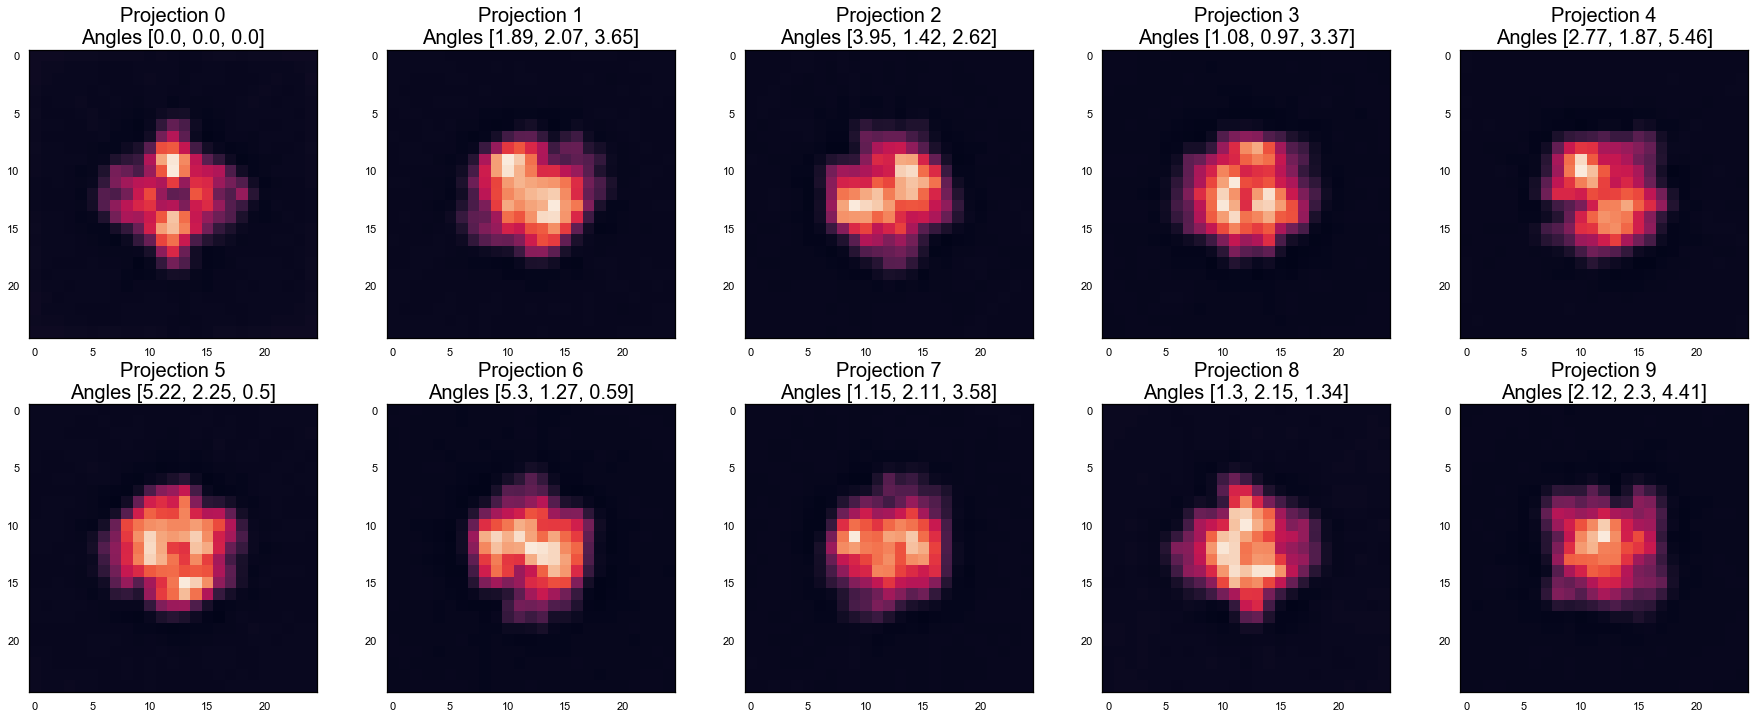

The 91-th iteration


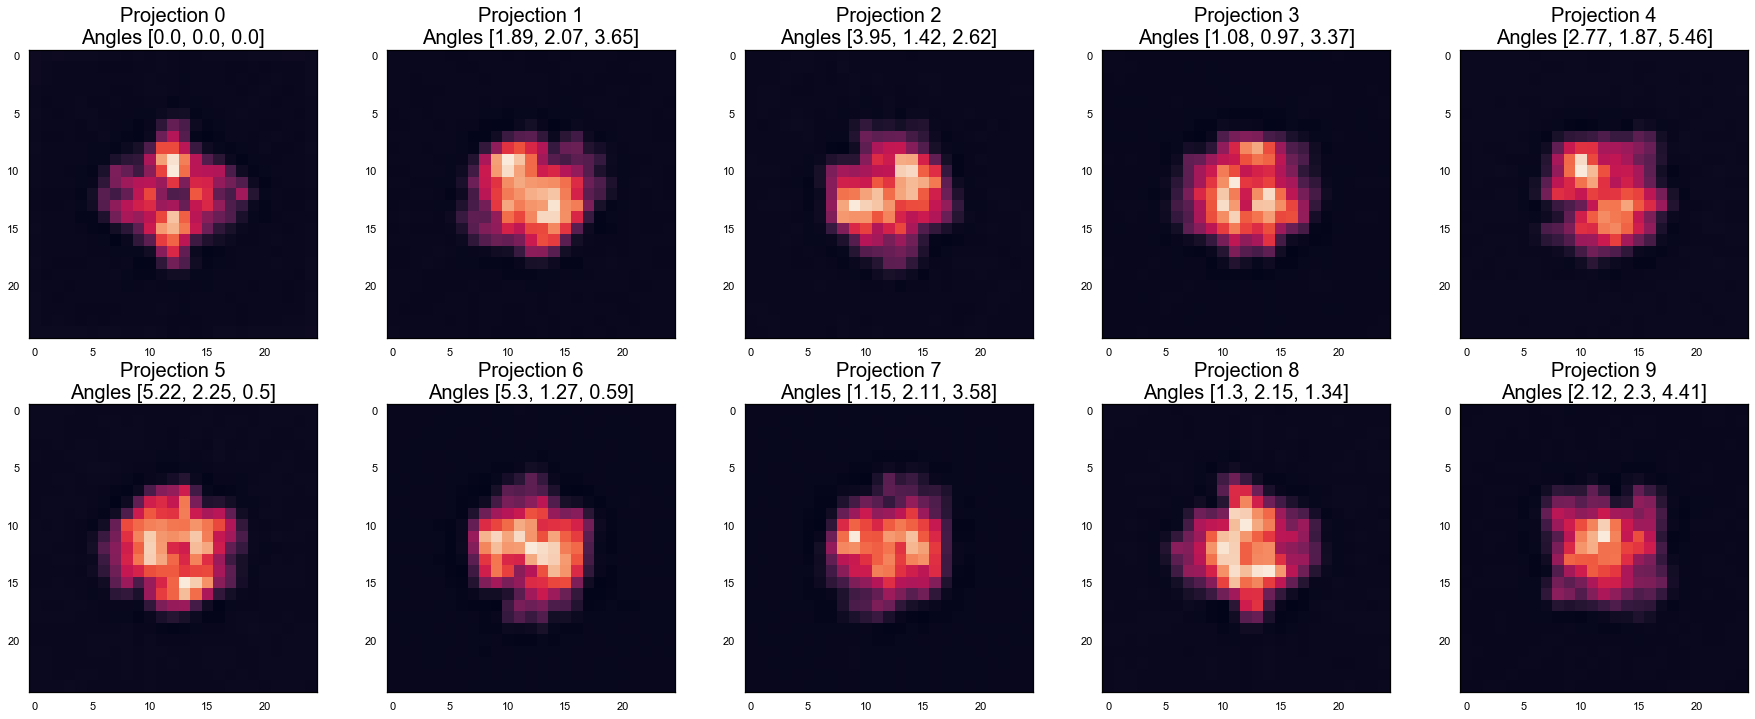

The 101-th iteration


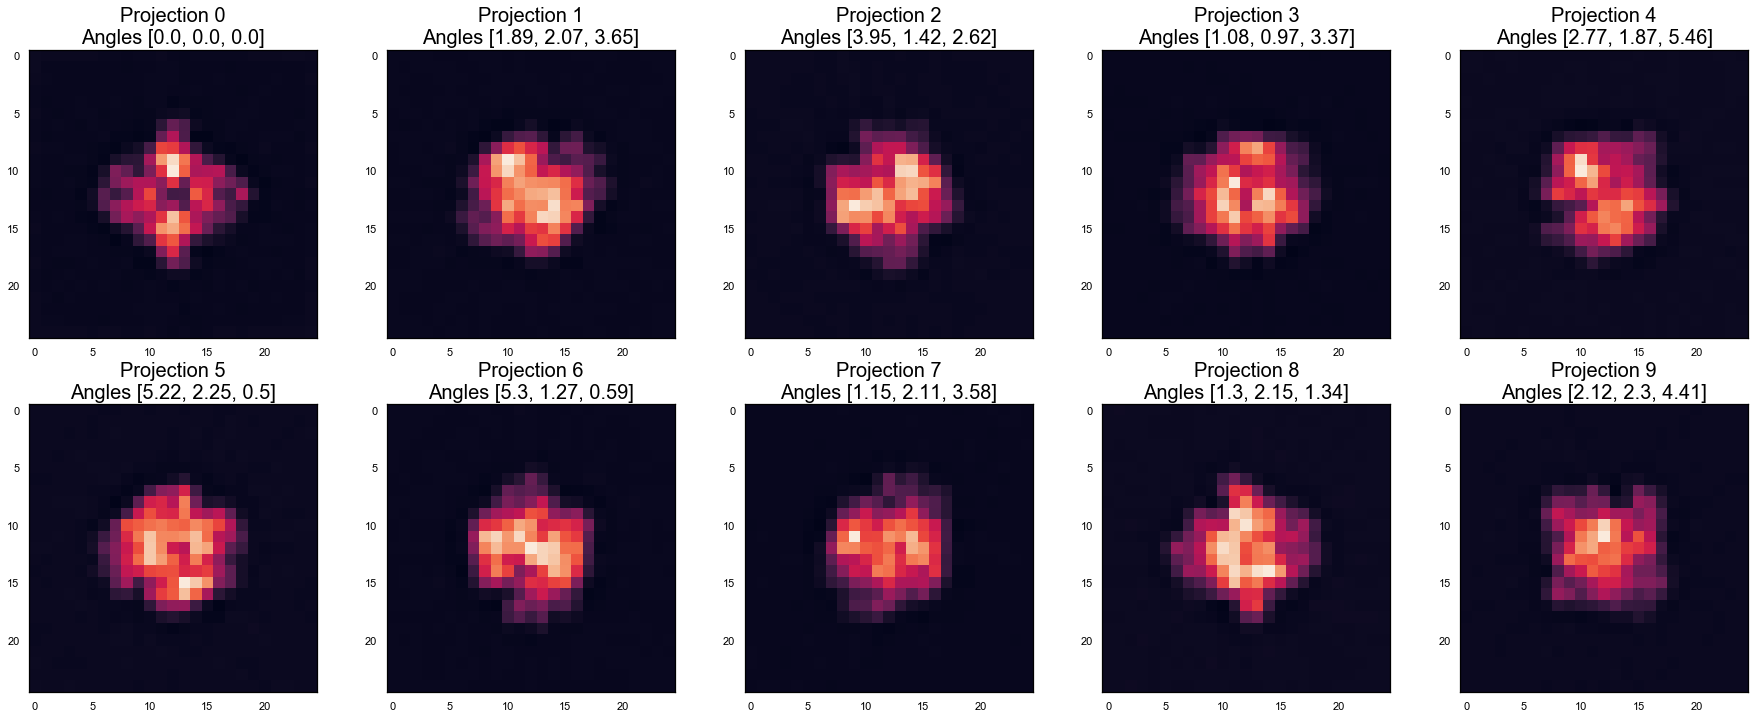

The 111-th iteration


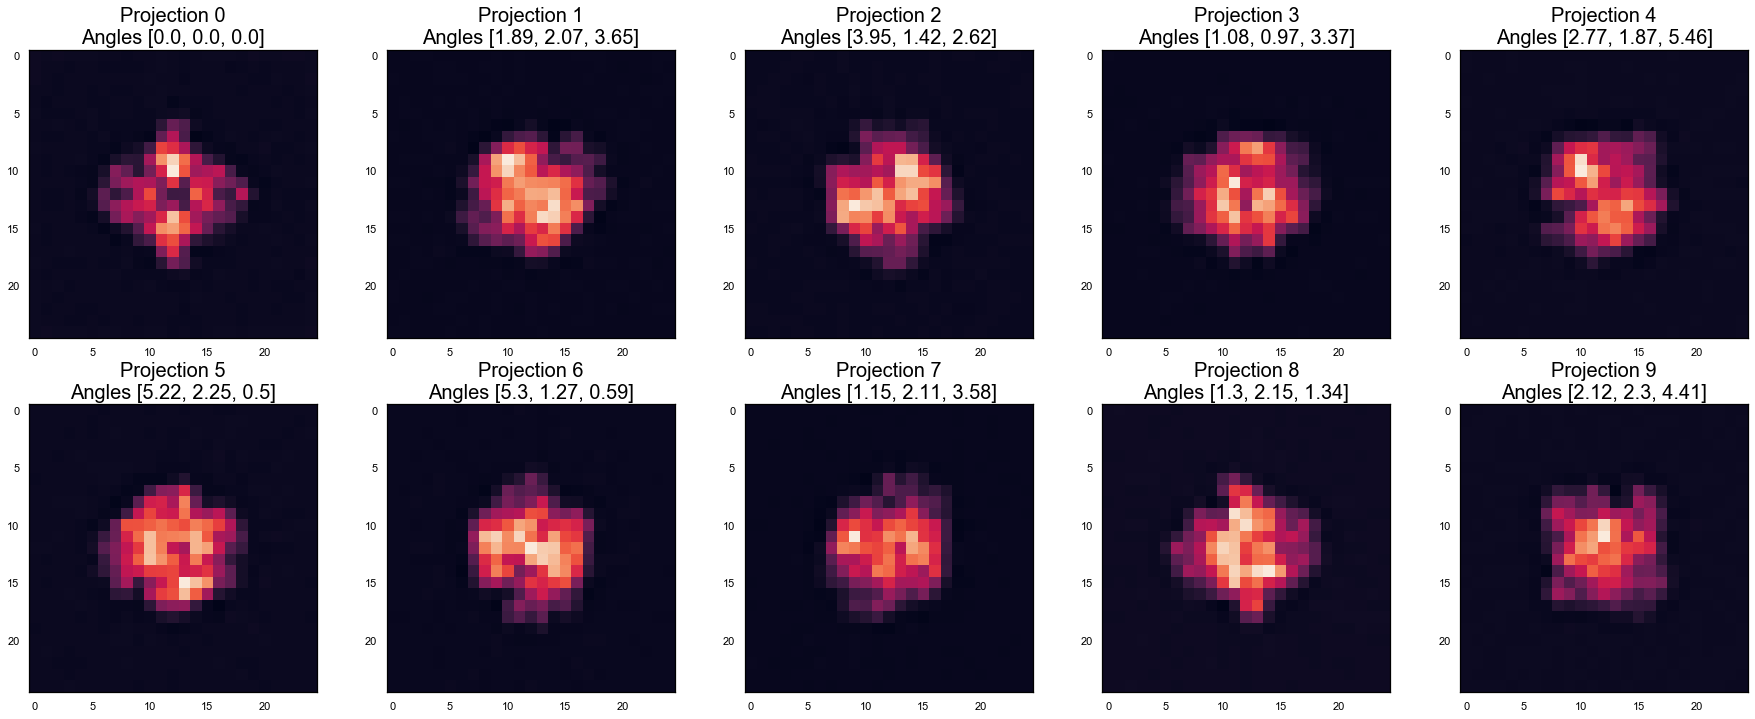

The 121-th iteration


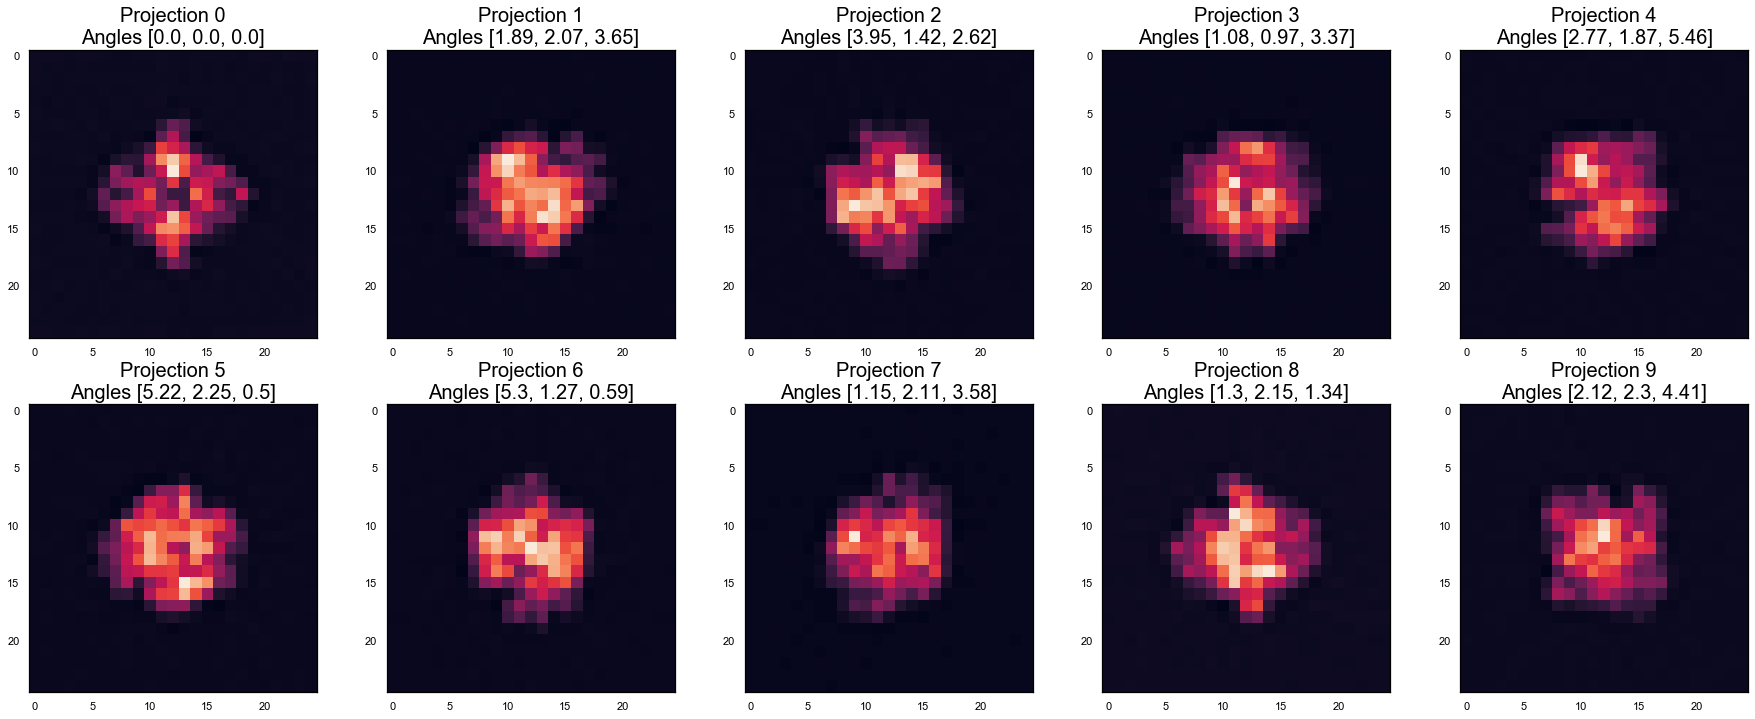

The 131-th iteration


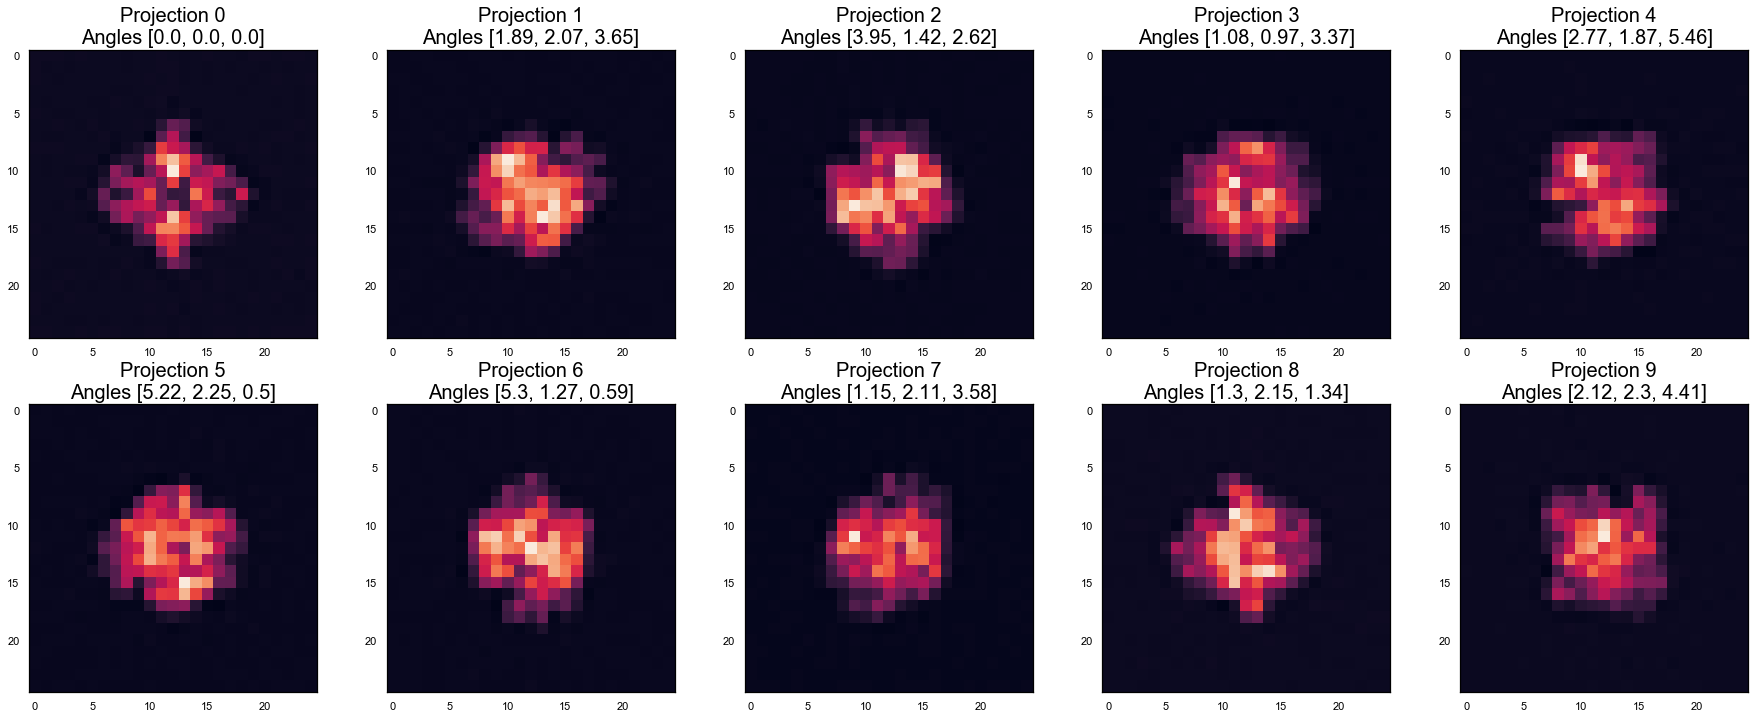

The 141-th iteration


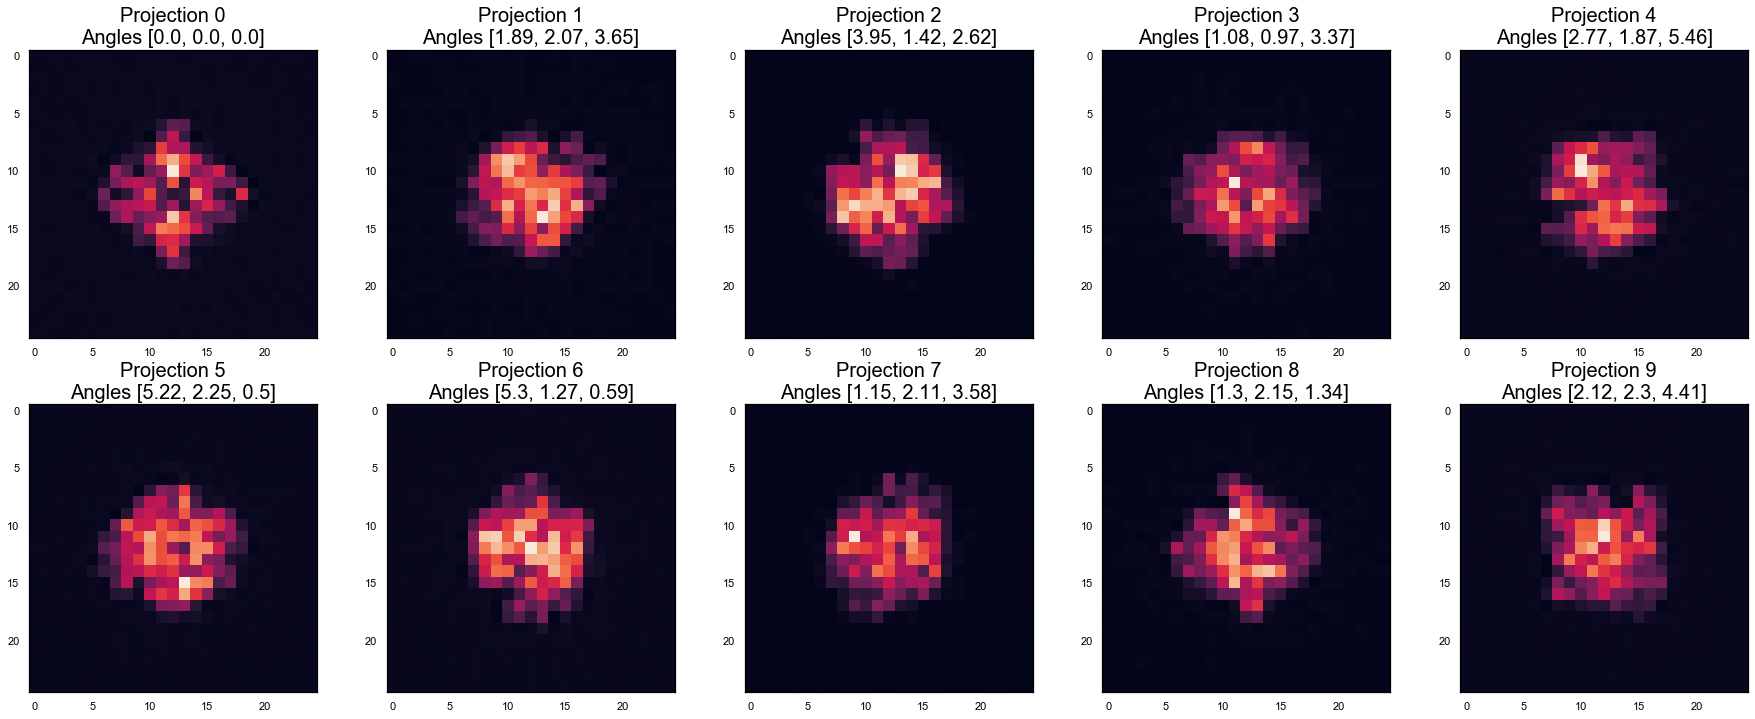

The 151-th iteration


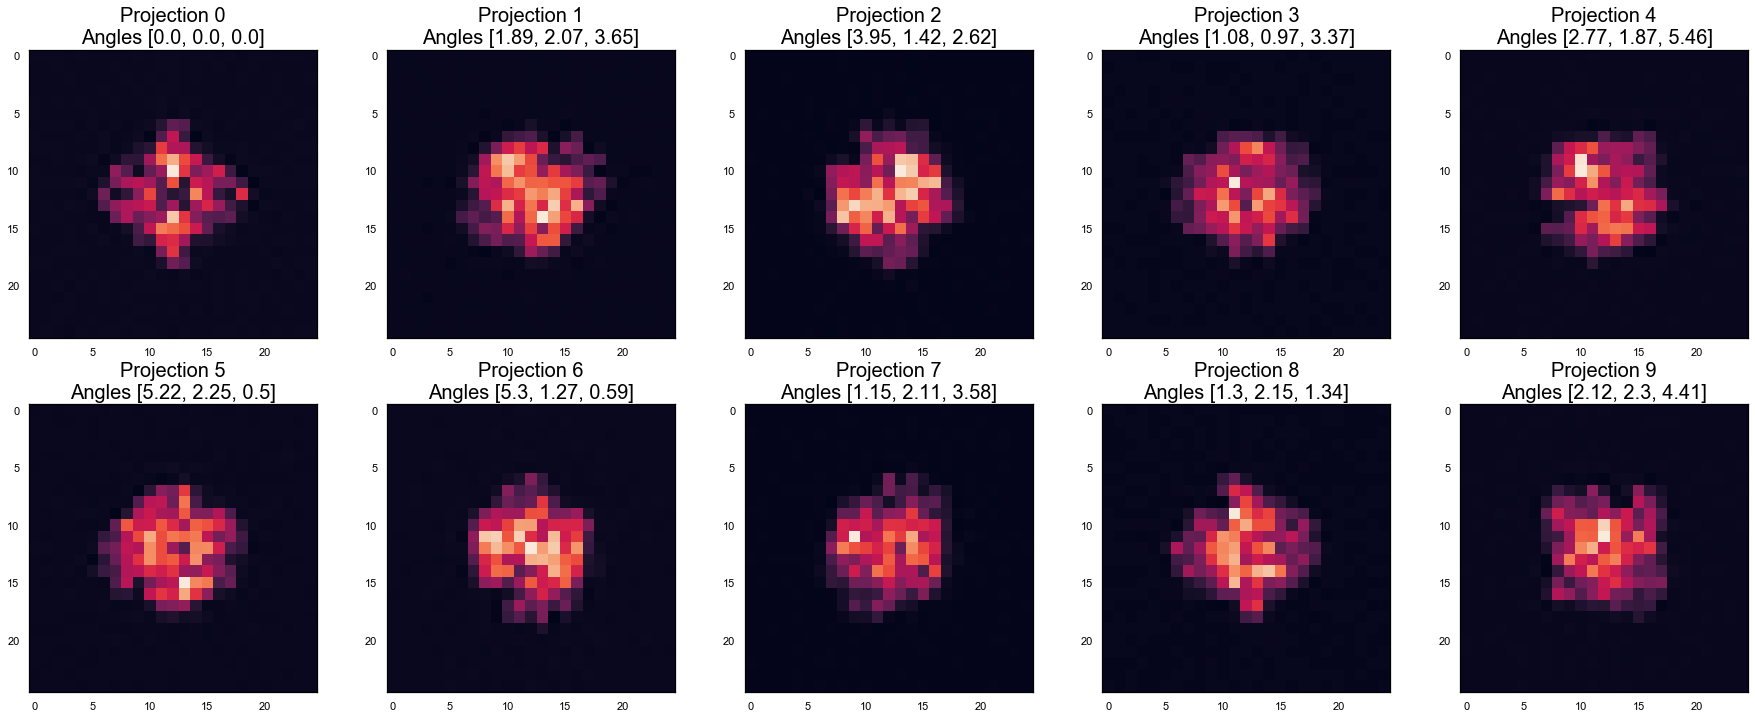

In [17]:



_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)

P3R.fit(new_projection, angles2)







#P3R.fit(new_projection, angles2)





(25, 25, 25)
25
(5000, 625, 2)
start fitting
The 0-th iteration
Q -90021844.10319354


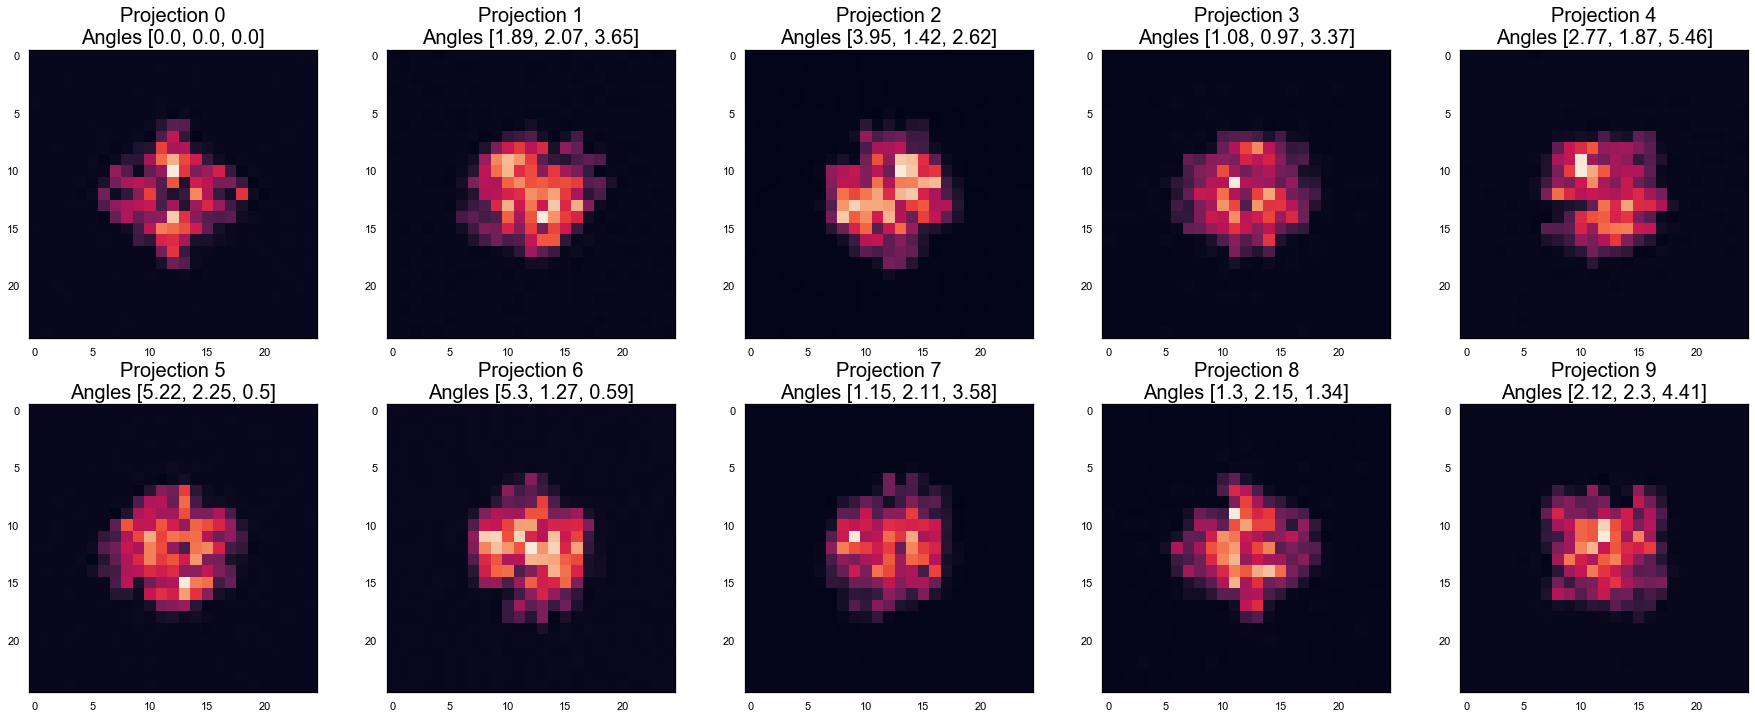

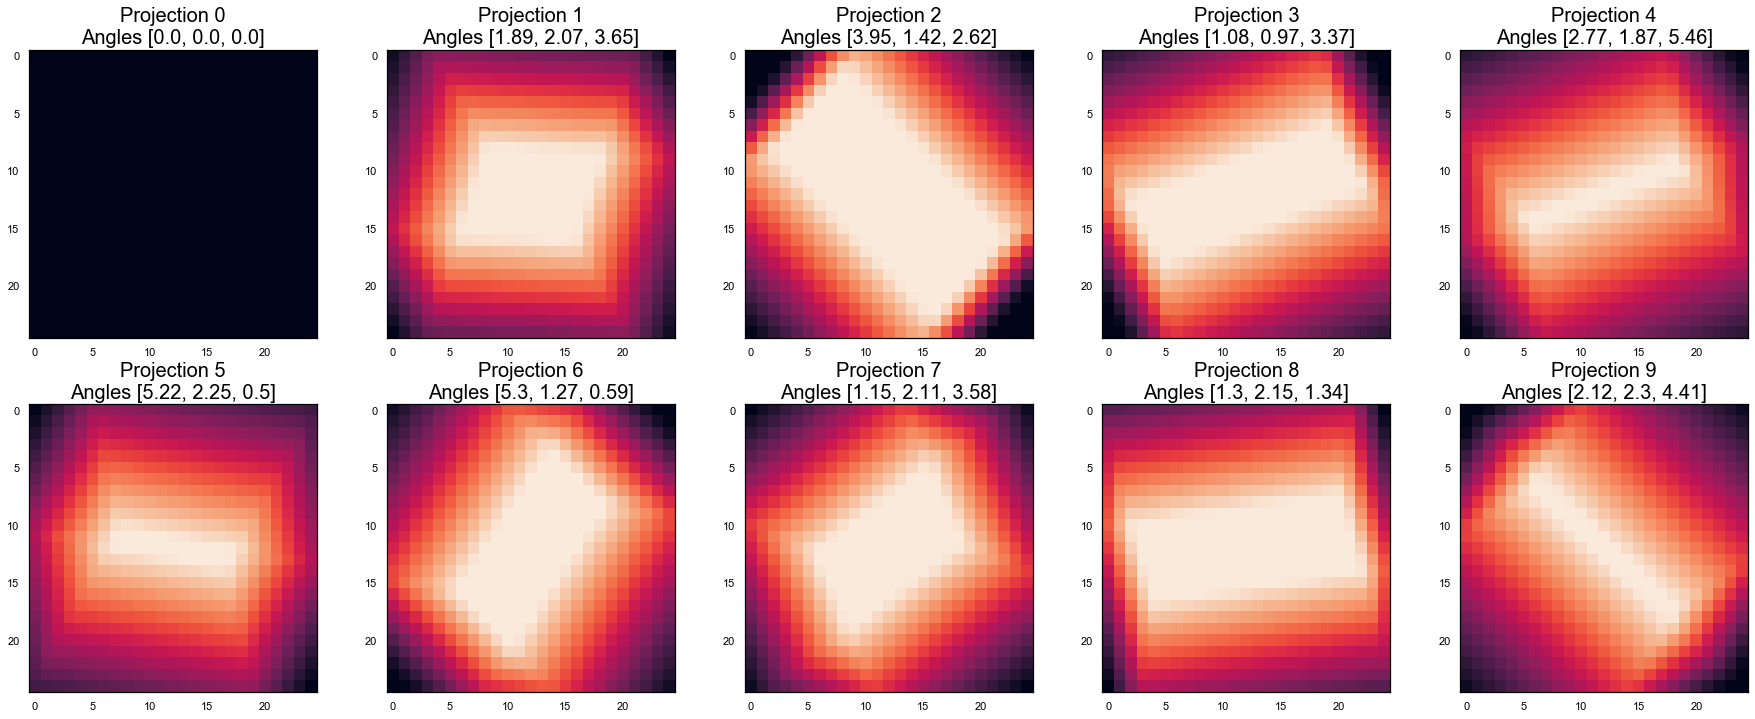

Q 1896190.6722129108
delta Q 91918034.77540645
The 1-th iteration


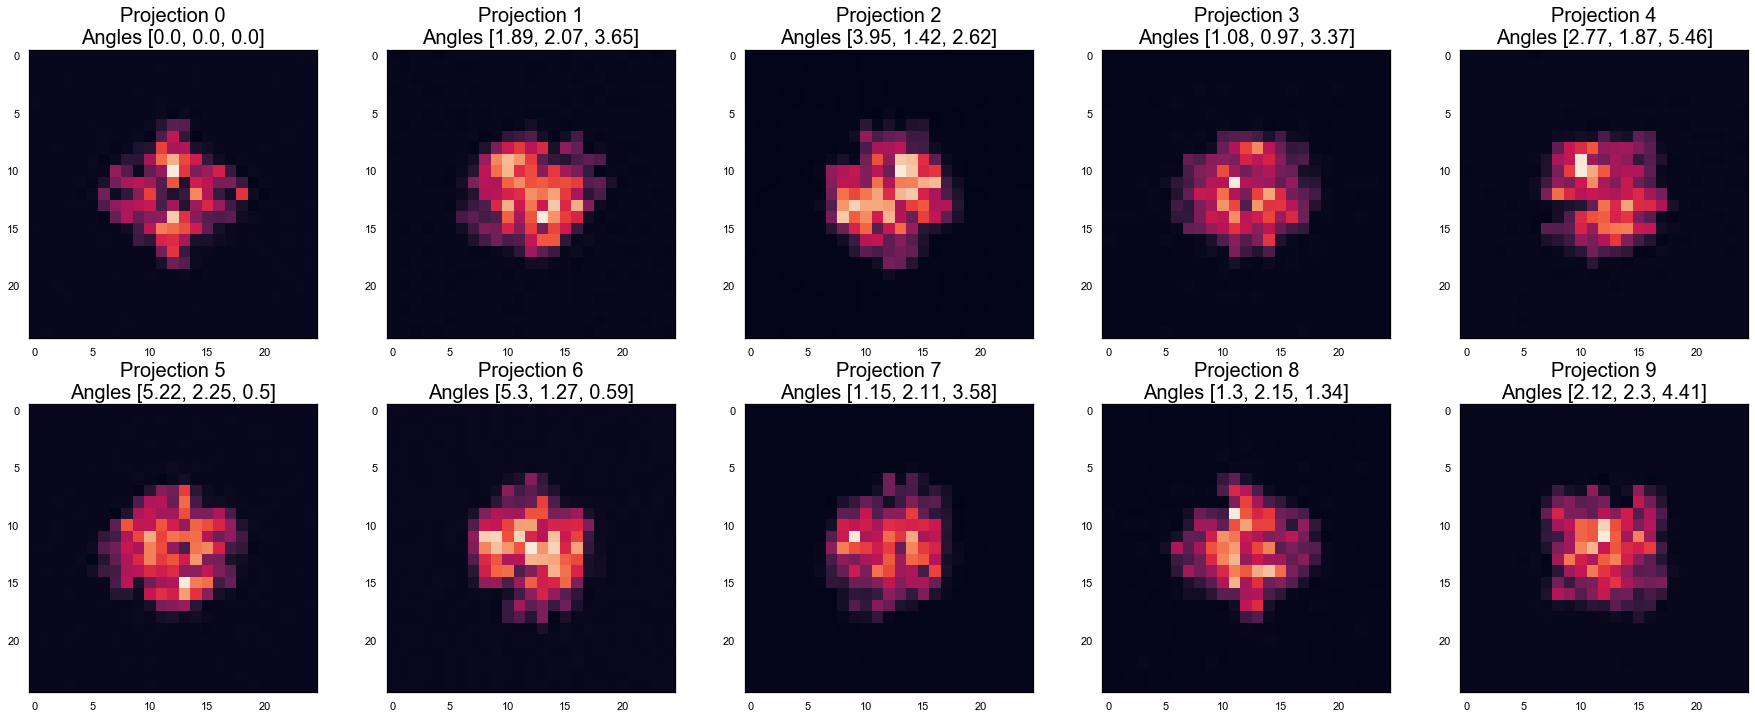

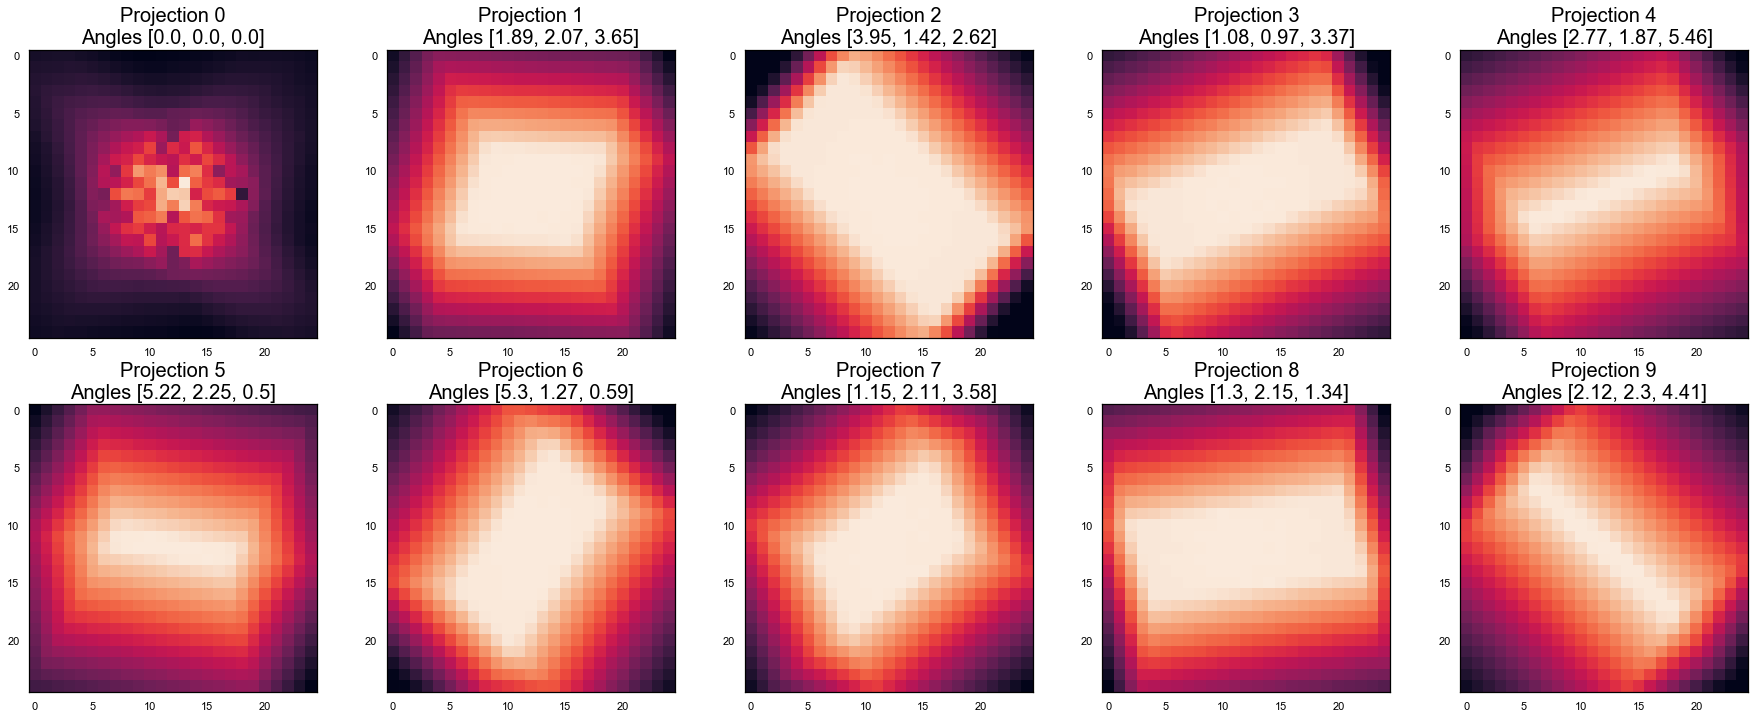

Q 1896190.6722129108
delta Q 0.0
Q 4423497.976763741
delta Q 2527307.3045508303
Q 4508038.5687464615
delta Q 84540.59198272042
Q 4559922.293647698
delta Q 51883.724901236594
Q 4611960.305423829
delta Q 52038.01177613065
Q 4664213.864730769
delta Q 52253.559306940064
Q 4716684.324349482
delta Q 52470.459618712775
Q 4769372.579148612
delta Q 52688.25479913037
Q 4822279.729237979
delta Q 52907.15008936729
Q 4875406.7546845535
delta Q 53127.025446574204
Q 4928754.851475191
delta Q 53348.09679063782
The 11-th iteration


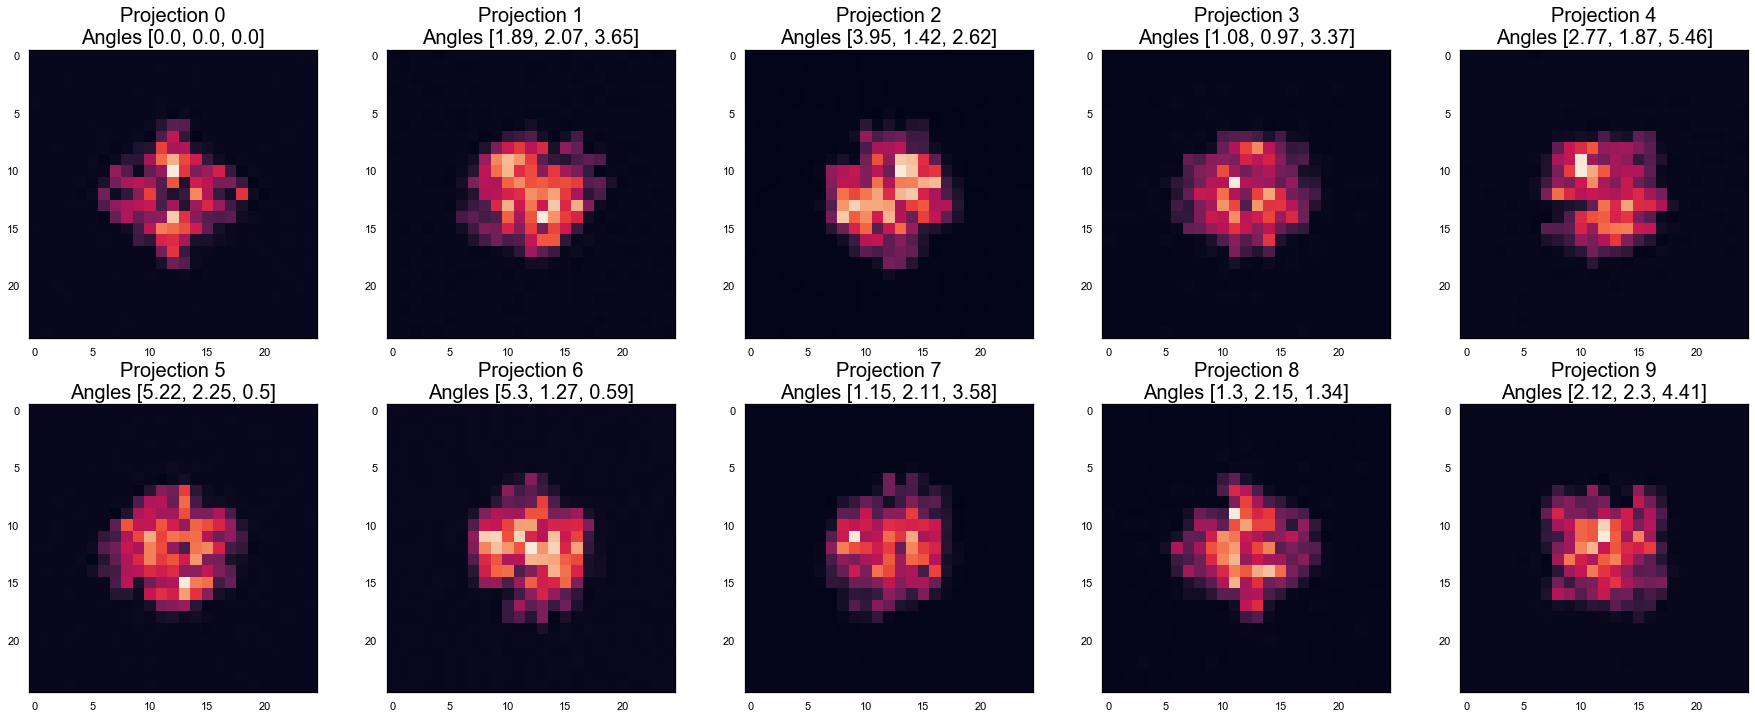

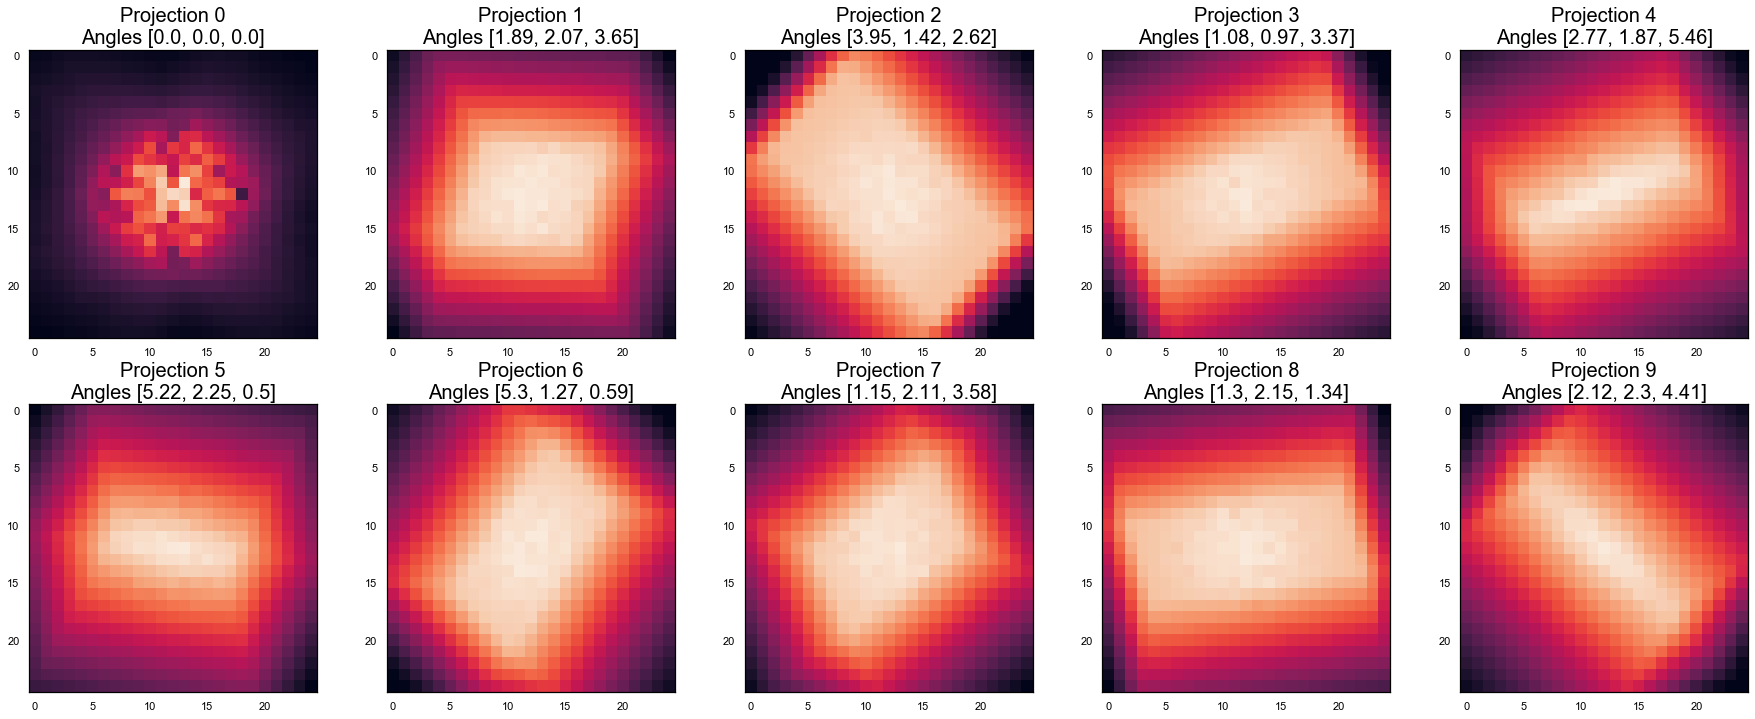

Q 4928754.851475191
delta Q 0.0
Q 4982324.989746831
delta Q 53570.138271640055
Q 5036118.052981898
delta Q 53793.06323506683
Q 5090135.312588329
delta Q 54017.25960643124
Q 5144377.608182597
delta Q 54242.29559426755
Q 5198846.145127611
delta Q 54468.53694501426
Q 5253541.757578018
delta Q 54695.61245040689
Q 5308465.581595603
delta Q 54923.824017585255
Q 5363618.673572523
delta Q 55153.09197691921
Q 5419002.0052031875
delta Q 55383.33163066488
Q 5474616.511153235
delta Q 55614.505950047635
The 21-th iteration


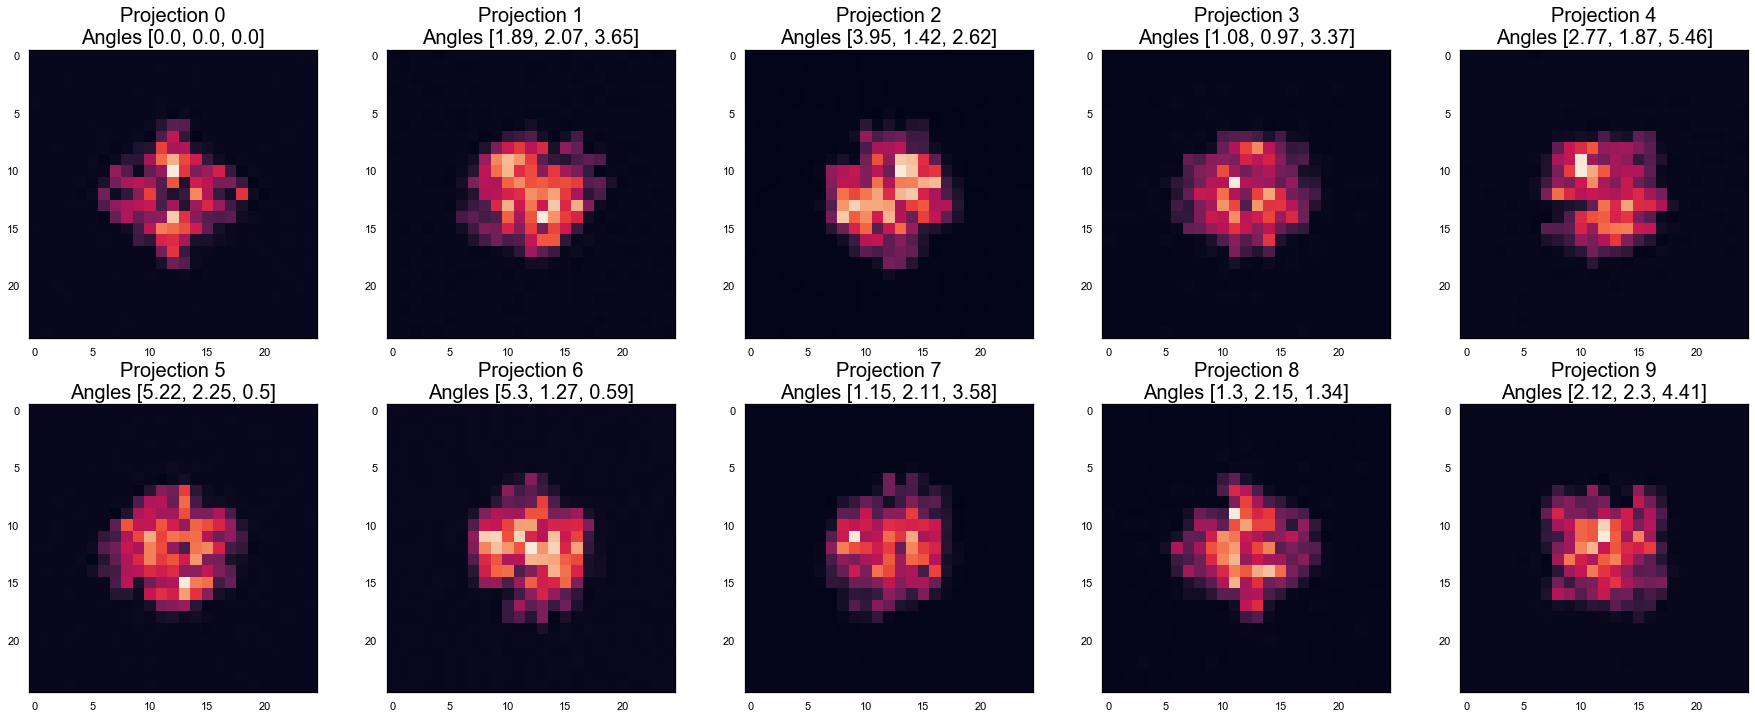

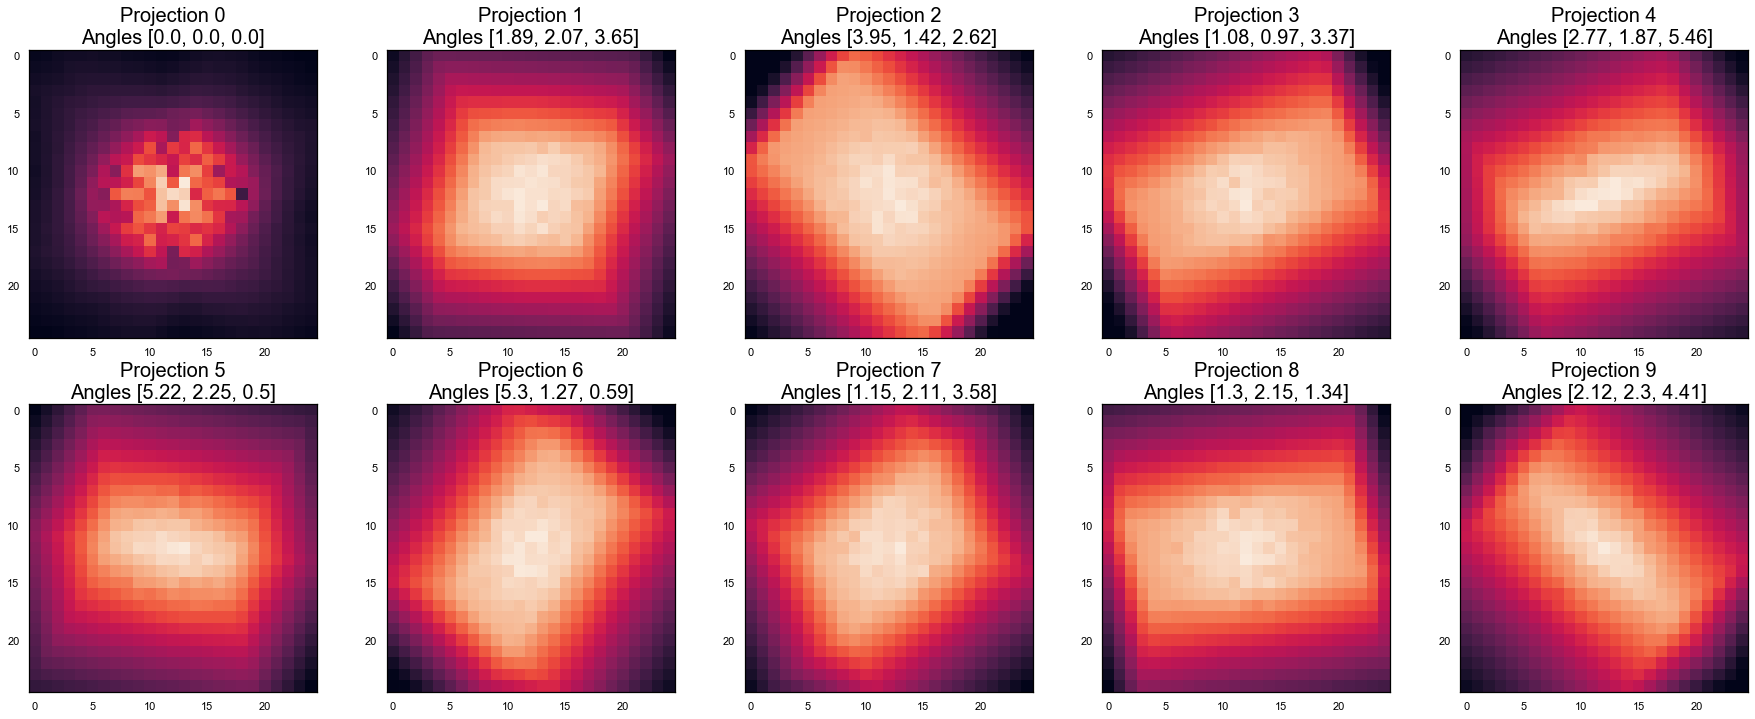

Q 5474616.511153235
delta Q 0.0
Q 5530463.426395427
delta Q 55846.915242192335
Q 5586543.59966908
delta Q 56080.17327365279
Q 5642857.85020691
delta Q 56314.25053782947
Q 5699407.607841434
delta Q 56549.757634524256
Q 5756193.475015287
delta Q 56785.86717385333
Q 5813216.88122022
delta Q 57023.40620493237
Q 5870478.22367919
delta Q 57261.34245896991
Q 5927979.160713711
delta Q 57500.93703452125
Q 5985720.23418251
delta Q 57741.07346879877
Q 6043702.714283393
delta Q 57982.48010088317
The 31-th iteration


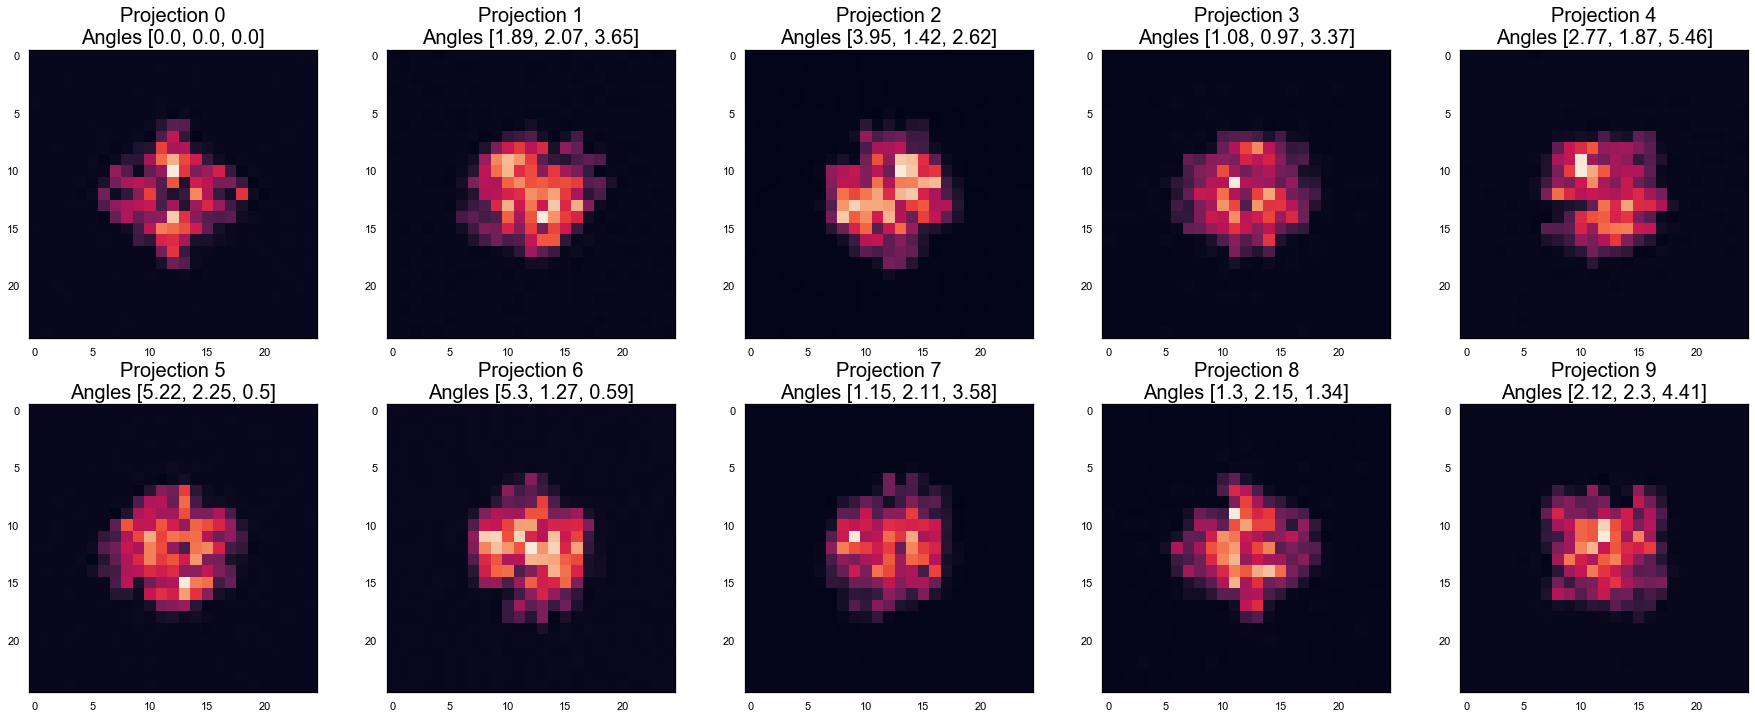

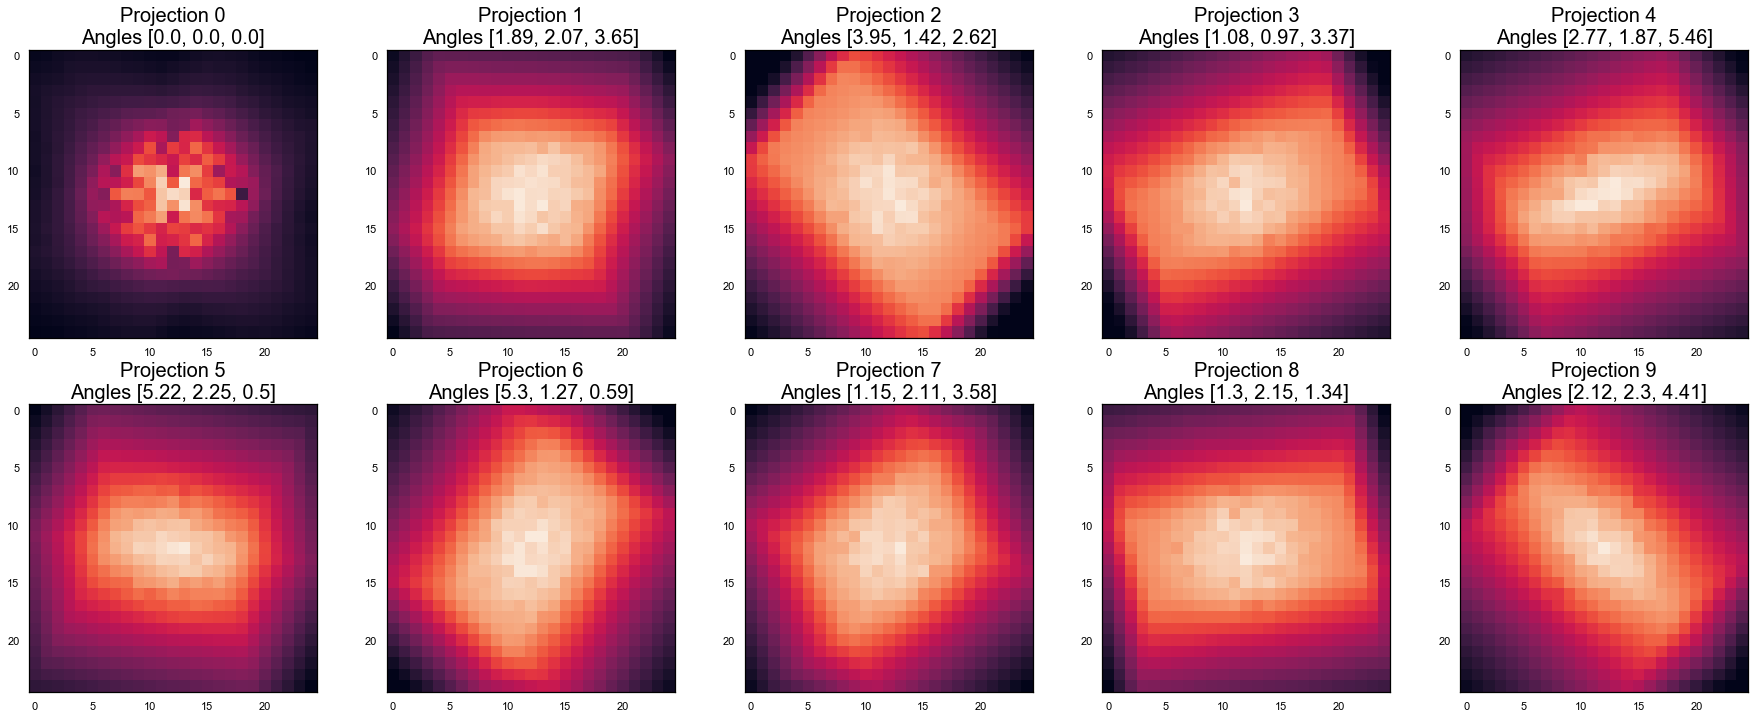

Q 6043702.714283393
delta Q 0.0
Q 6101927.34079013
delta Q 58224.62650673743
Q 6160395.222104275
delta Q 58467.88131414447
Q 6219107.376856004
delta Q 58712.15475172922
Q 6278064.771592697
delta Q 58957.39473669324
Q 6337268.222601805
delta Q 59203.45100910775
Q 6396719.114866113
delta Q 59450.89226430841
Q 6456417.958615042
delta Q 59698.84374892898
Q 6516366.014990791
delta Q 59948.05637574848
Q 6576564.161707596
delta Q 60198.146716805175
Q 6637013.343407041
delta Q 60449.18169944547
The 41-th iteration


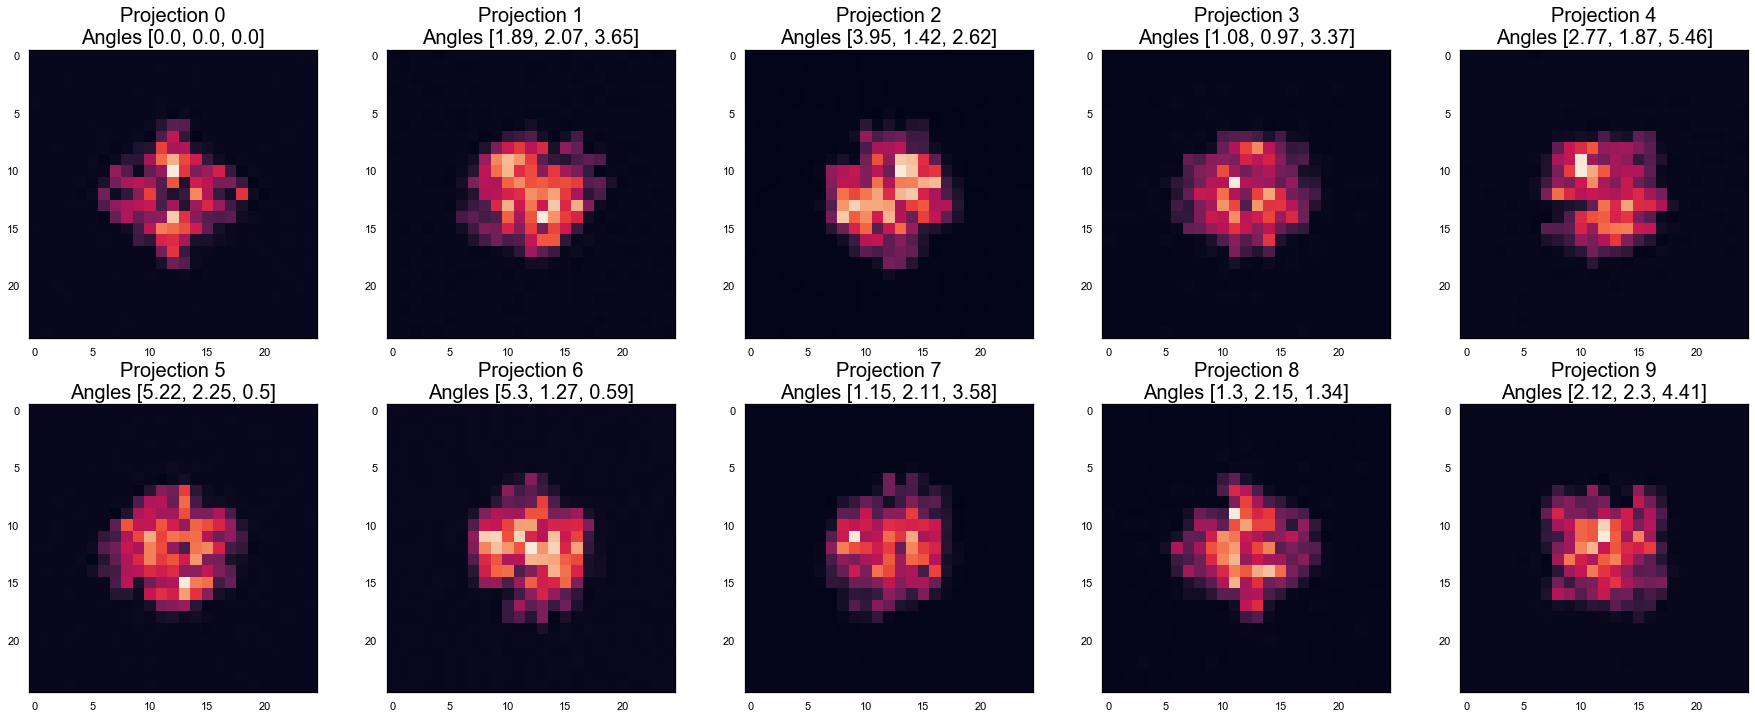

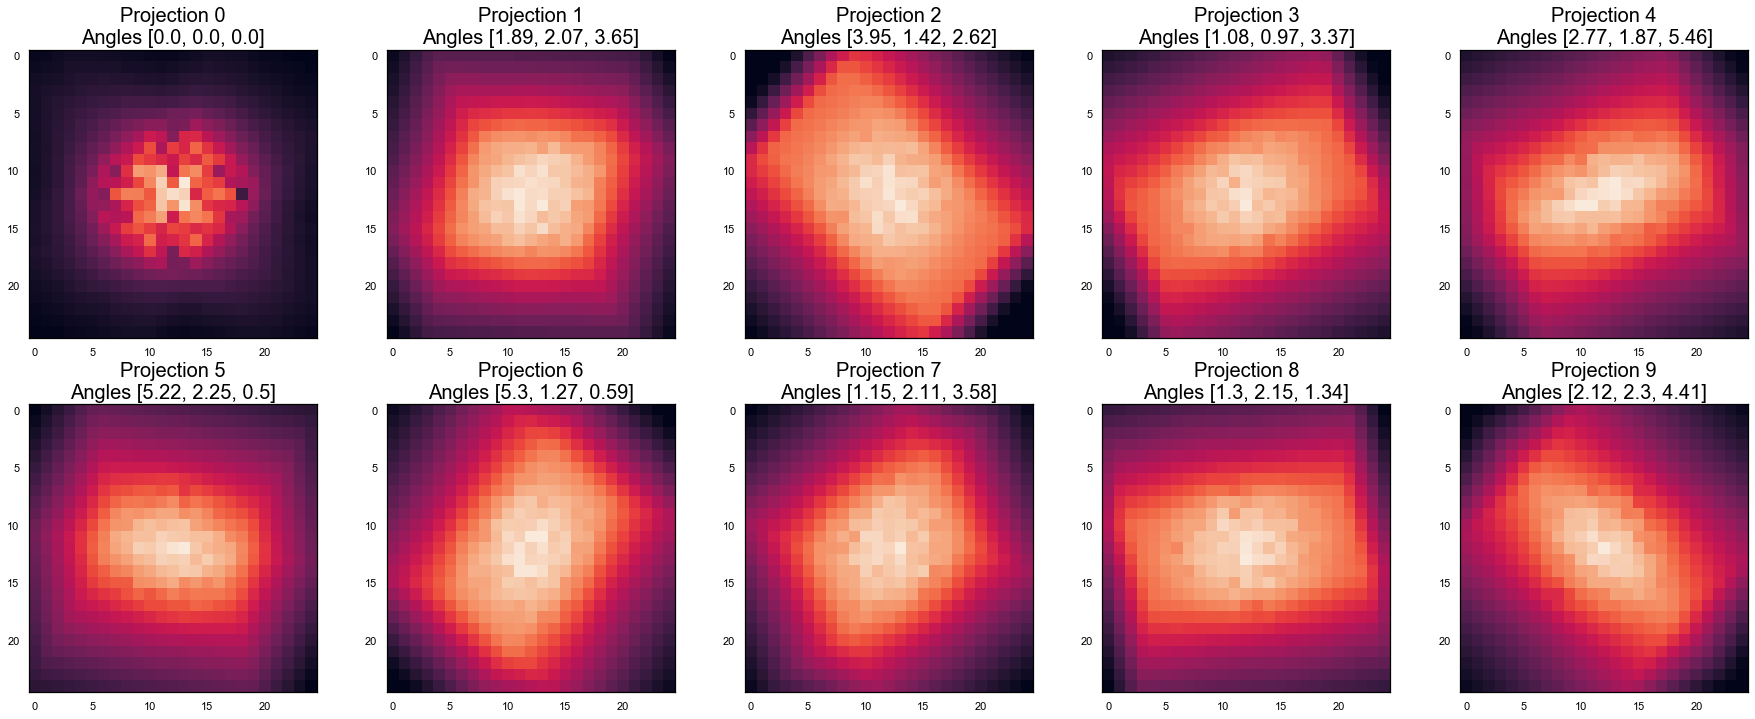

Q 6637013.343407041
delta Q 0.0
Q 6697714.726288287
delta Q 60701.382881245576
Q 6758668.879108698
delta Q 60954.15282041114
Q 6819877.107549581
delta Q 61208.22844088264
Q 6881340.320049111
delta Q 61463.212499530055
Q 6943059.396564457
delta Q 61719.076515345834
Q 7005035.356083045
delta Q 61975.95951858815
Q 7067269.135697469
delta Q 62233.77961442433
Q 7129761.409301673
delta Q 62492.27360420395
Q 7192513.680316398
delta Q 62752.27101472486
Q 7255526.641836445
delta Q 63012.96152004693
The 51-th iteration


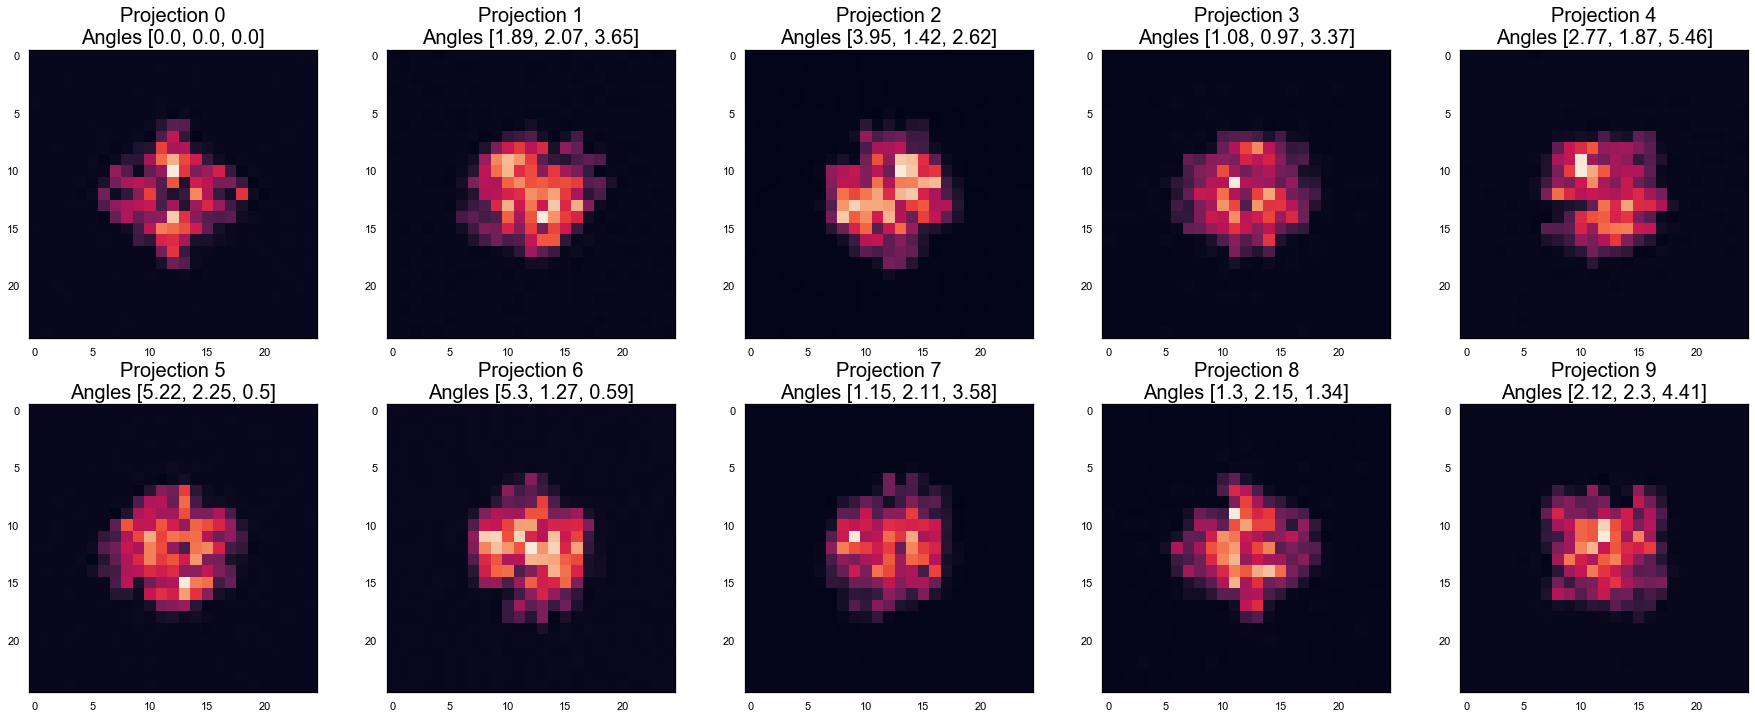

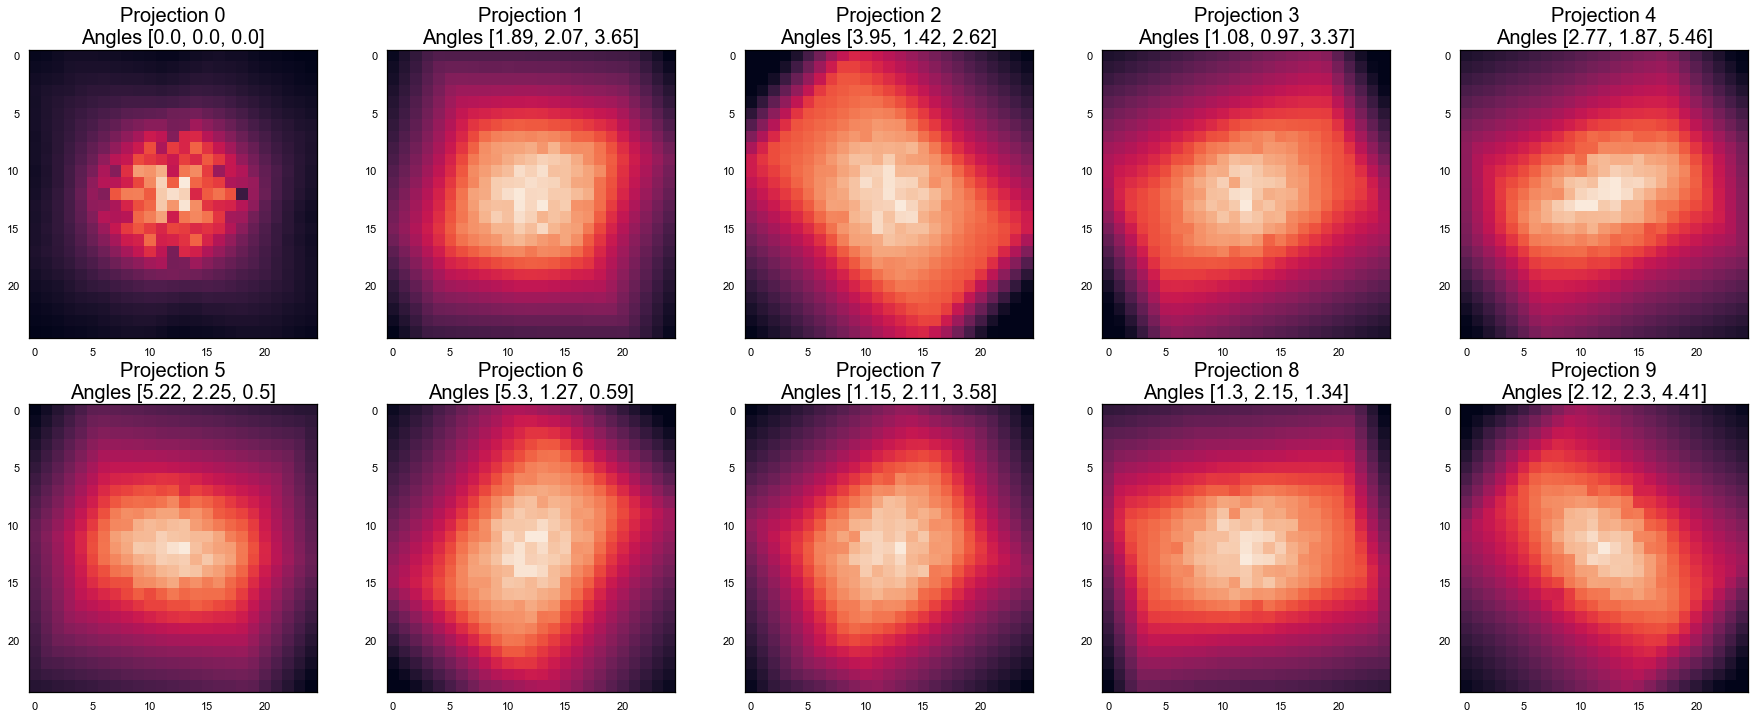

Q 7255526.641836445
delta Q 0.0
Q 7318800.91394665
delta Q 63274.272110205144
Q 7382337.891411512
delta Q 63536.97746486217
Q 7446138.29250354
delta Q 63800.401092028245
Q 7510203.062604407
delta Q 64064.770100866444
Q 7574533.3836644385
delta Q 64330.32106003165
Q 7639129.750618316
delta Q 64596.36695387773
Q 7703993.270753073
delta Q 64863.52013475634
Q 7769125.156303195
delta Q 65131.88555012271
Q 7834525.873450534
delta Q 65400.717147339135
Q 7900196.609809706
delta Q 65670.73635917157
The 61-th iteration


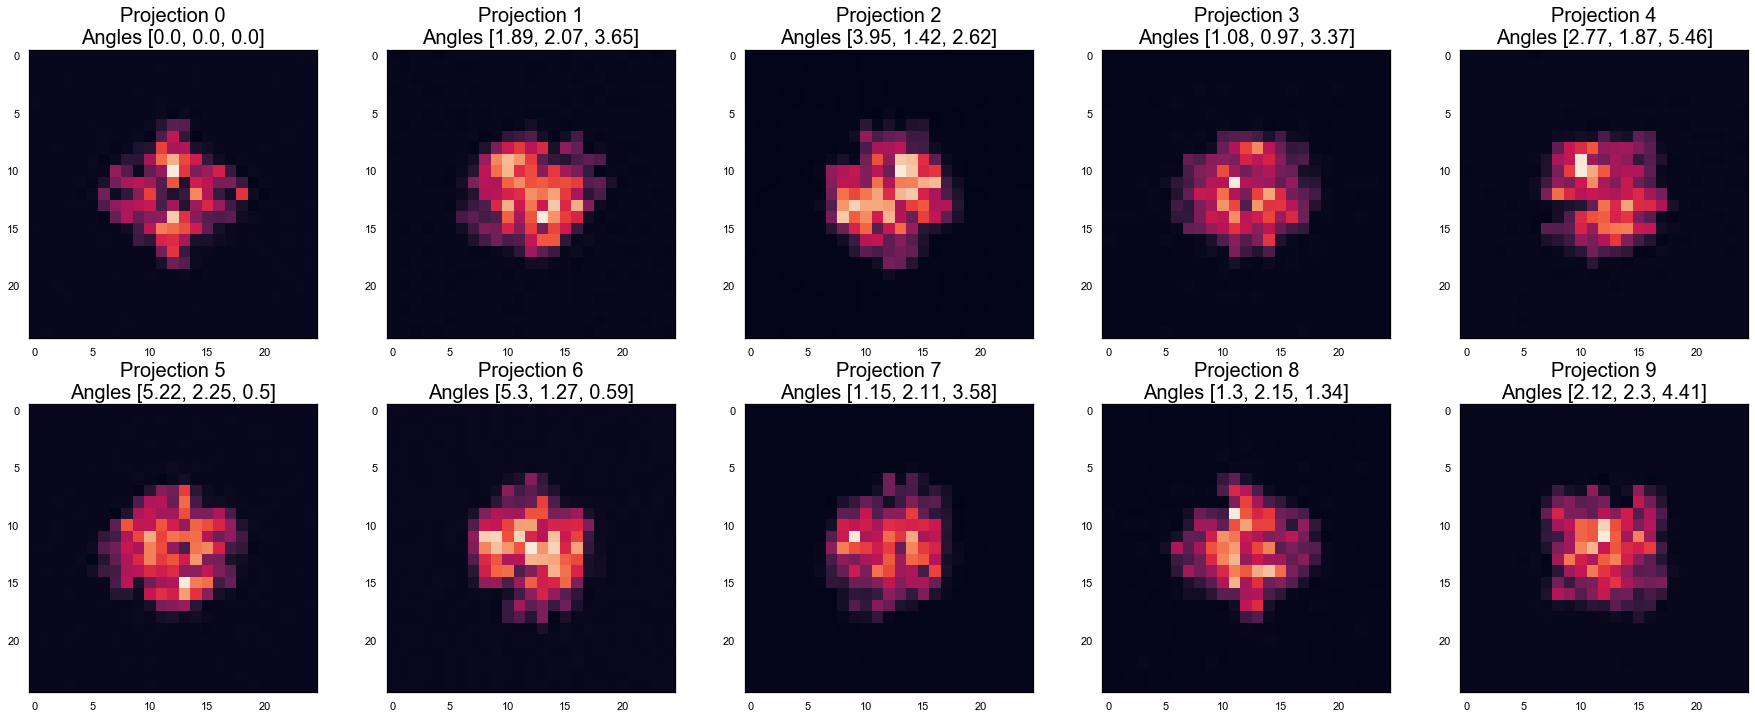

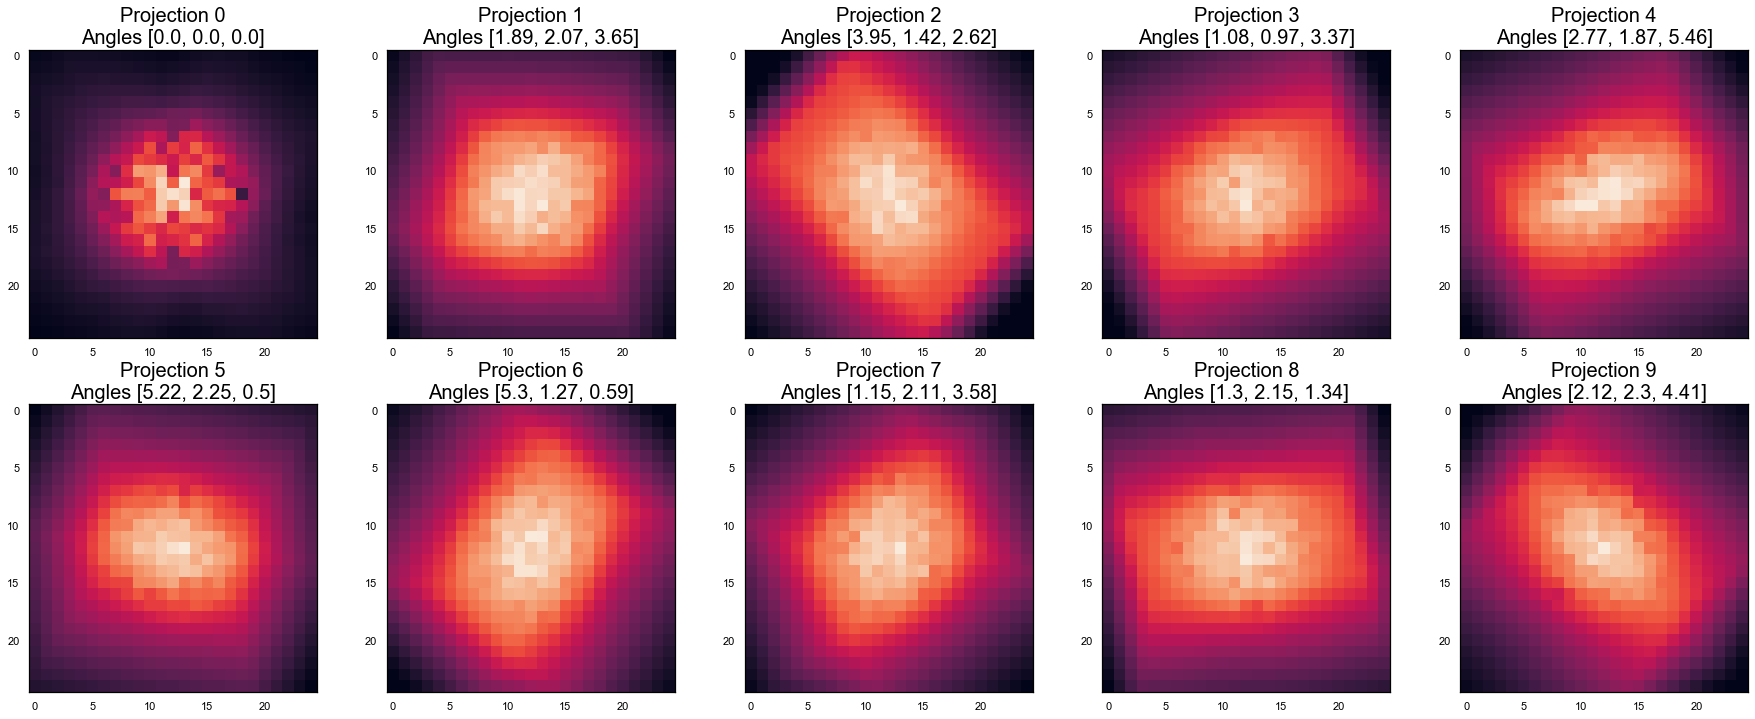

Q 7900196.609809706
delta Q 0.0
Q 7966138.175338634
delta Q 65941.5655289283
Q 8032351.548875512
delta Q 66213.37353687733
Q 8098837.714990657
delta Q 66486.1661151452
Q 8165597.4567201305
delta Q 66759.7417294737
Q 8232631.656443918
delta Q 67034.1997237876
Q 8299941.276701142
delta Q 67309.62025722396
Q 8367527.338400799
delta Q 67586.06169965677
Q 8435390.503765736
delta Q 67863.16536493693
Q 8503531.717446486
delta Q 68141.21368074976
Q 8571951.858749097
delta Q 68420.14130261168
The 71-th iteration


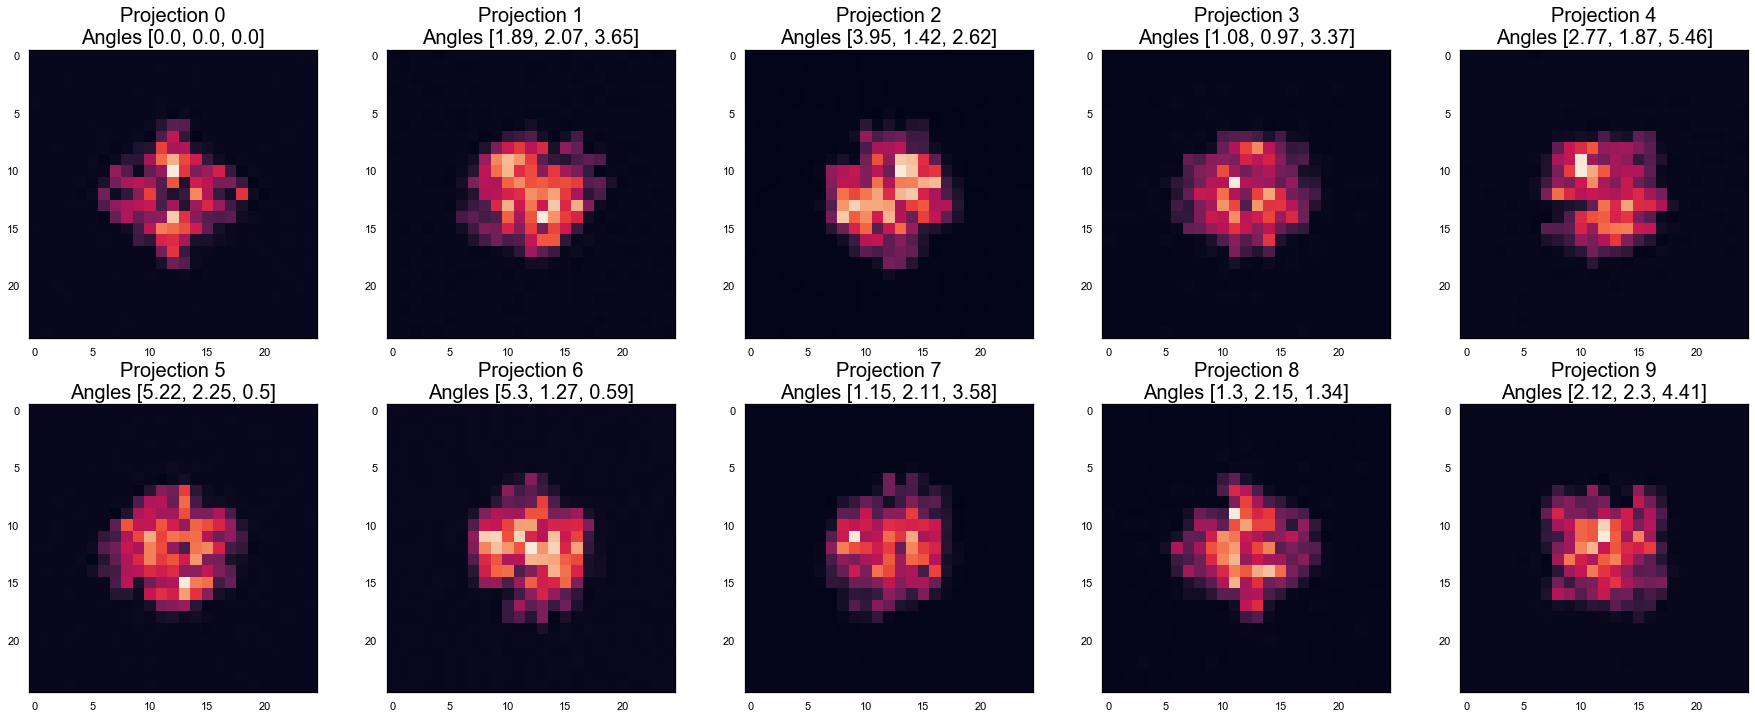

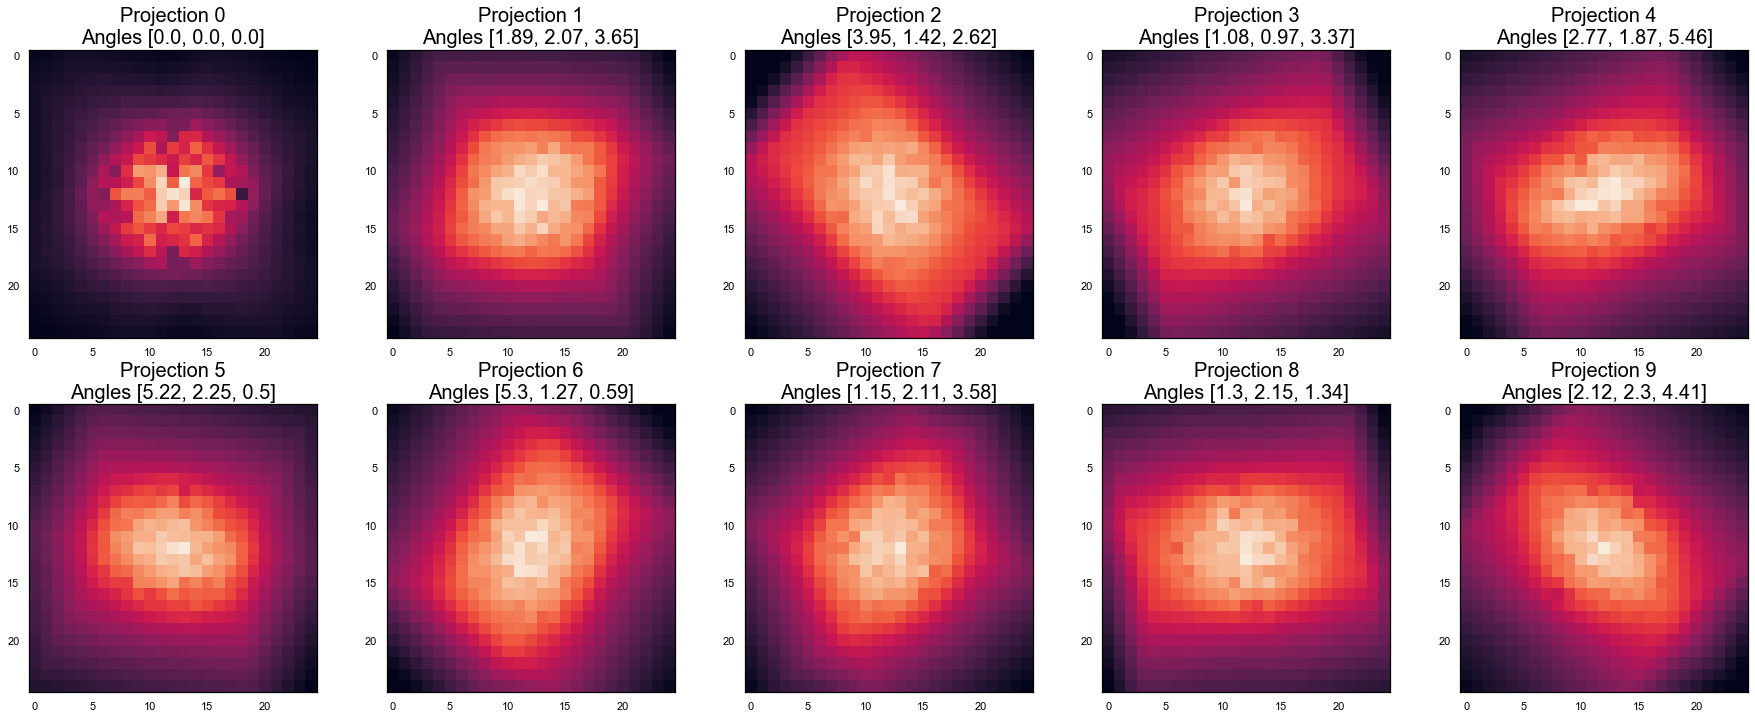

Q 8571951.858749097
delta Q 0.0
Q 8640651.67244462
delta Q 68699.81369552203
Q 8709632.720766209
delta Q 68981.04832158983
Q 8778895.028436892
delta Q 69262.30767068267
Q 8848439.934081681
delta Q 69544.90564478934
Q 8918268.035114227
delta Q 69828.10103254579
Q 8988380.42369396
delta Q 70112.38857973367
Q 9058777.865753394
delta Q 70397.44205943309
Q 9129461.275378747
delta Q 70683.40962535329
Q 9200431.311739966
delta Q 70970.03636121936
Q 9271689.105406389
delta Q 71257.79366642237
The 81-th iteration


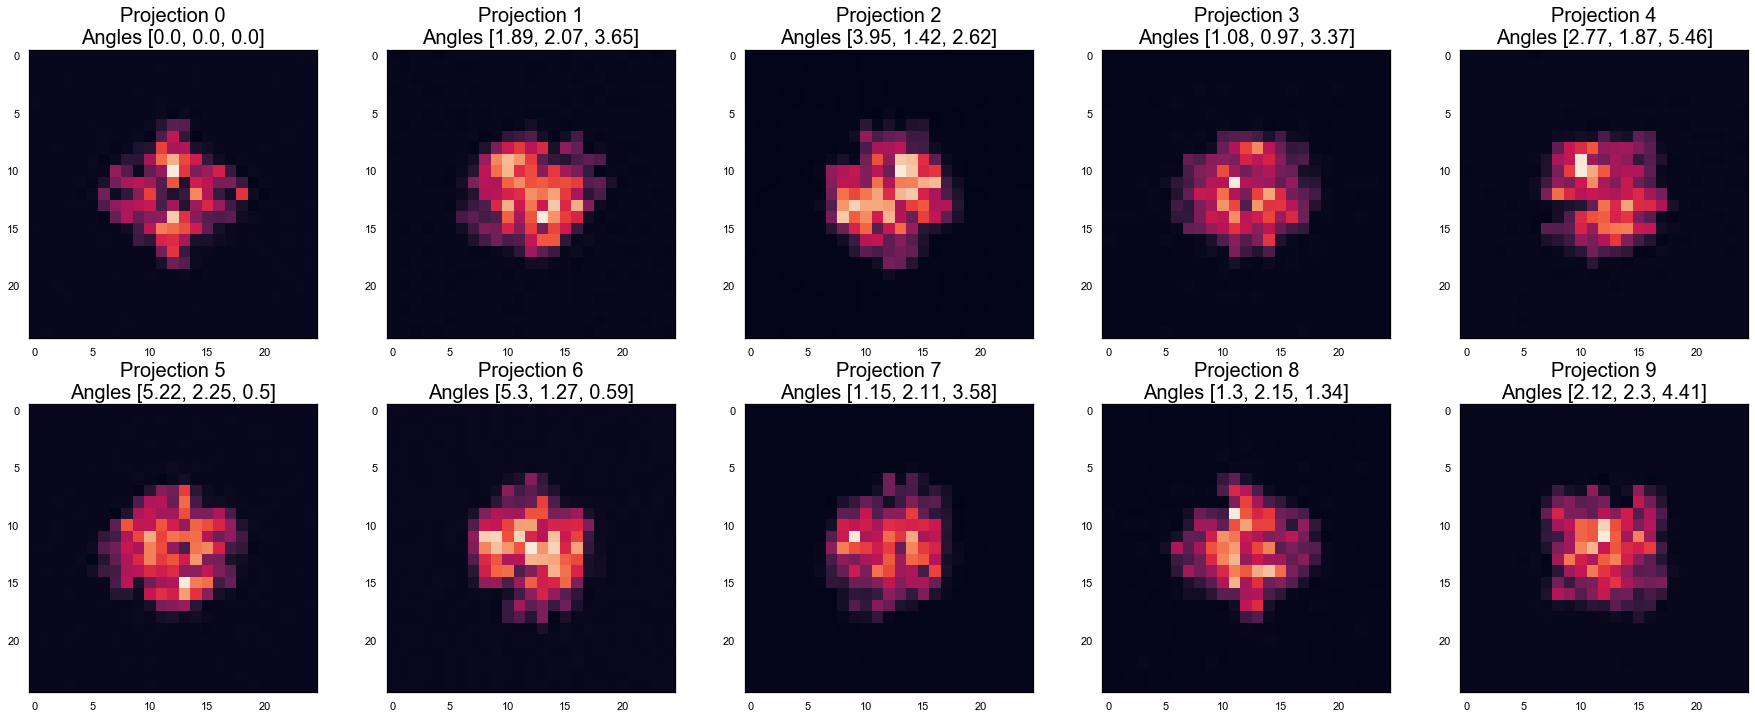

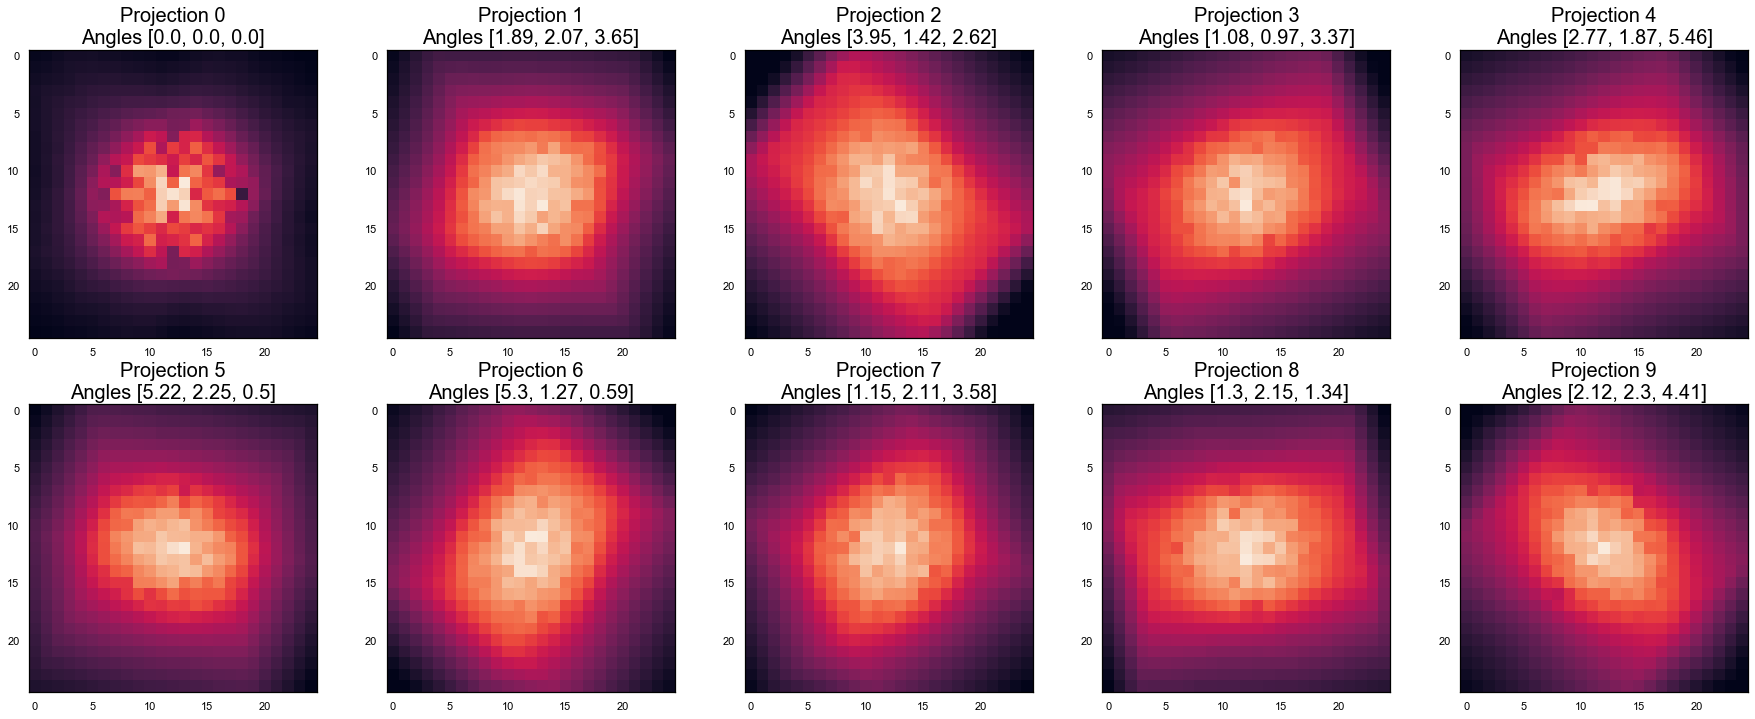

Q 9271689.105406389
delta Q 0.0
Q 9343235.29038083
delta Q 71546.1849744413
Q 9415070.819809983
delta Q 71835.52942915261
Q 9487196.423298847
delta Q 72125.60348886438
Q 9559612.946187193
delta Q 72416.52288834564
Q 9632321.403943518
delta Q 72708.4577563256
Q 9705322.251971945
delta Q 73000.84802842699
Q 9778616.43814617
delta Q 73294.18617422506
Q 9852205.067920458
delta Q 73588.62977428734
Q 9926088.748520302
delta Q 73883.68059984408
Q 10000267.879526438
delta Q 74179.13100613654
The 91-th iteration


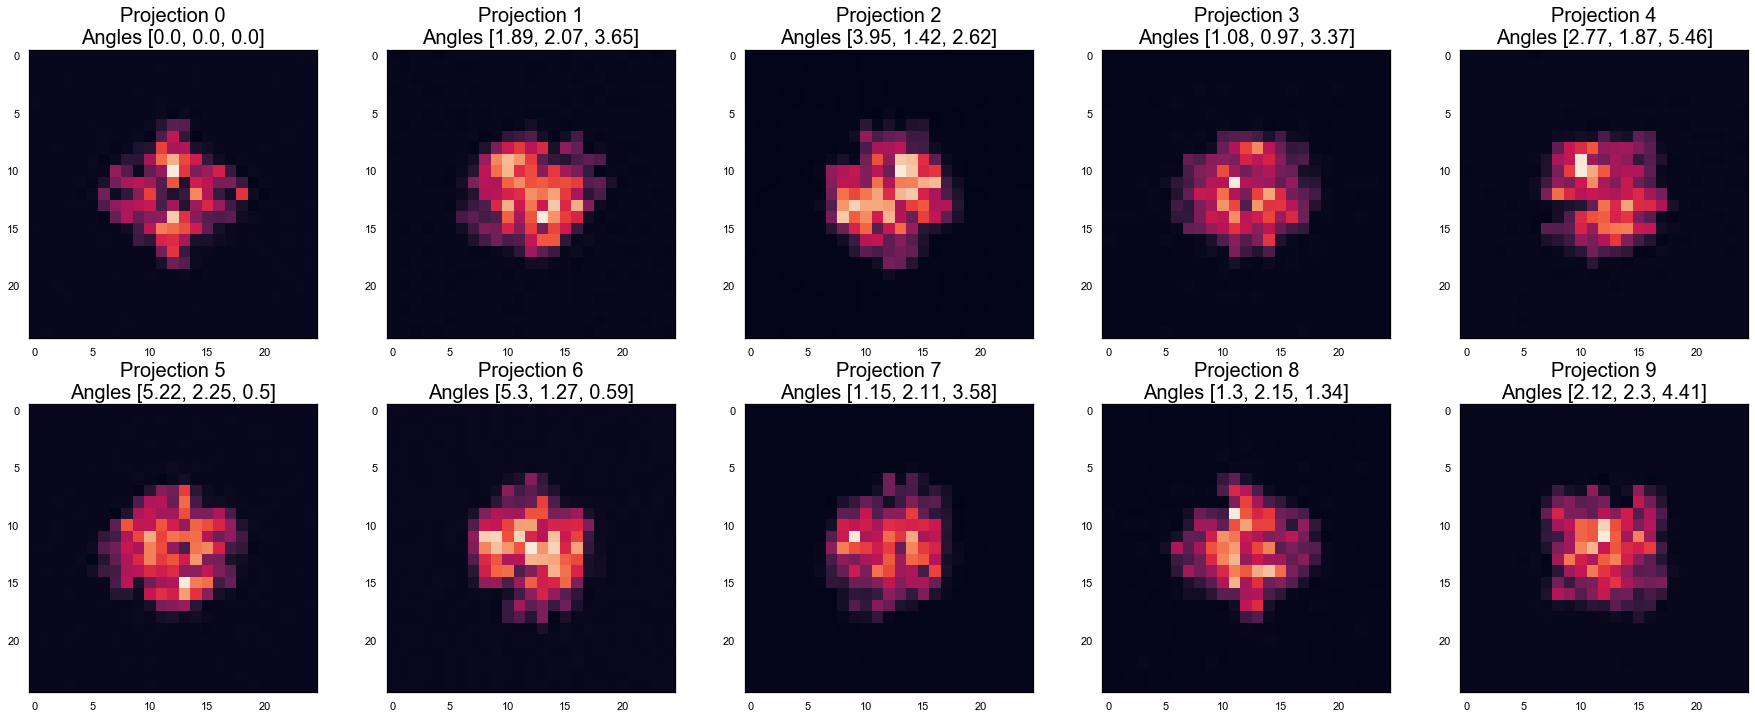

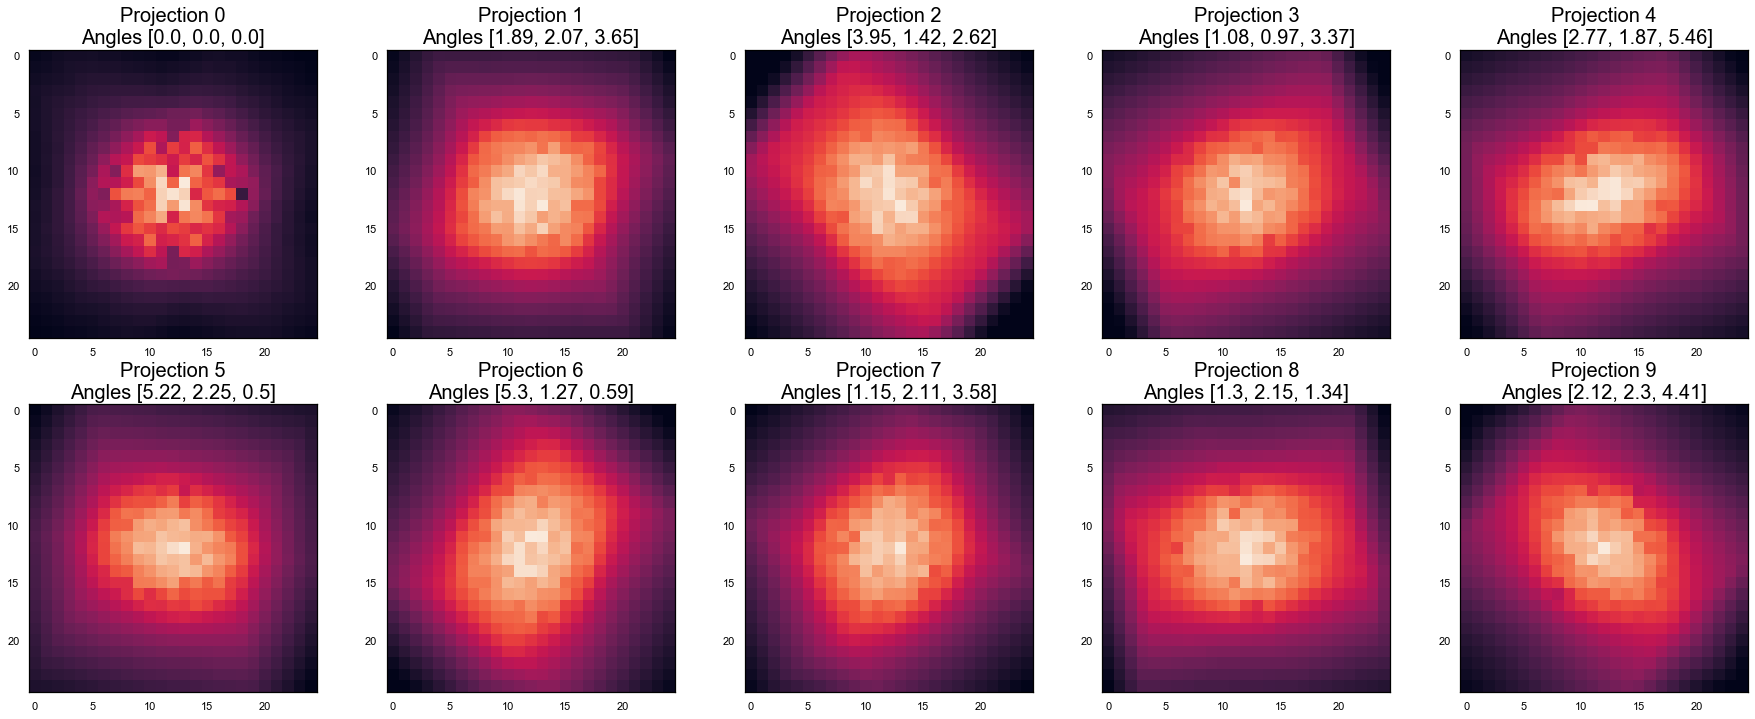

Q 10000267.879526438
delta Q 0.0
Q 10074743.9006276
delta Q 74476.02110116184
Q 10149516.968831325
delta Q 74773.06820372492
Q 10224588.594122928
delta Q 75071.62529160269
Q 10299959.07366955
delta Q 75370.47954662144
Q 10375629.08386599
delta Q 75670.01019644178
Q 10451599.644499356
delta Q 75970.56063336506
Q 10527871.63877432
delta Q 76271.99427496456
Q 10604445.236247722
delta Q 76573.59747340158
Q 10681321.770941067
delta Q 76876.53469334543
Q 10758501.712218598
delta Q 77179.94127753004
The 101-th iteration


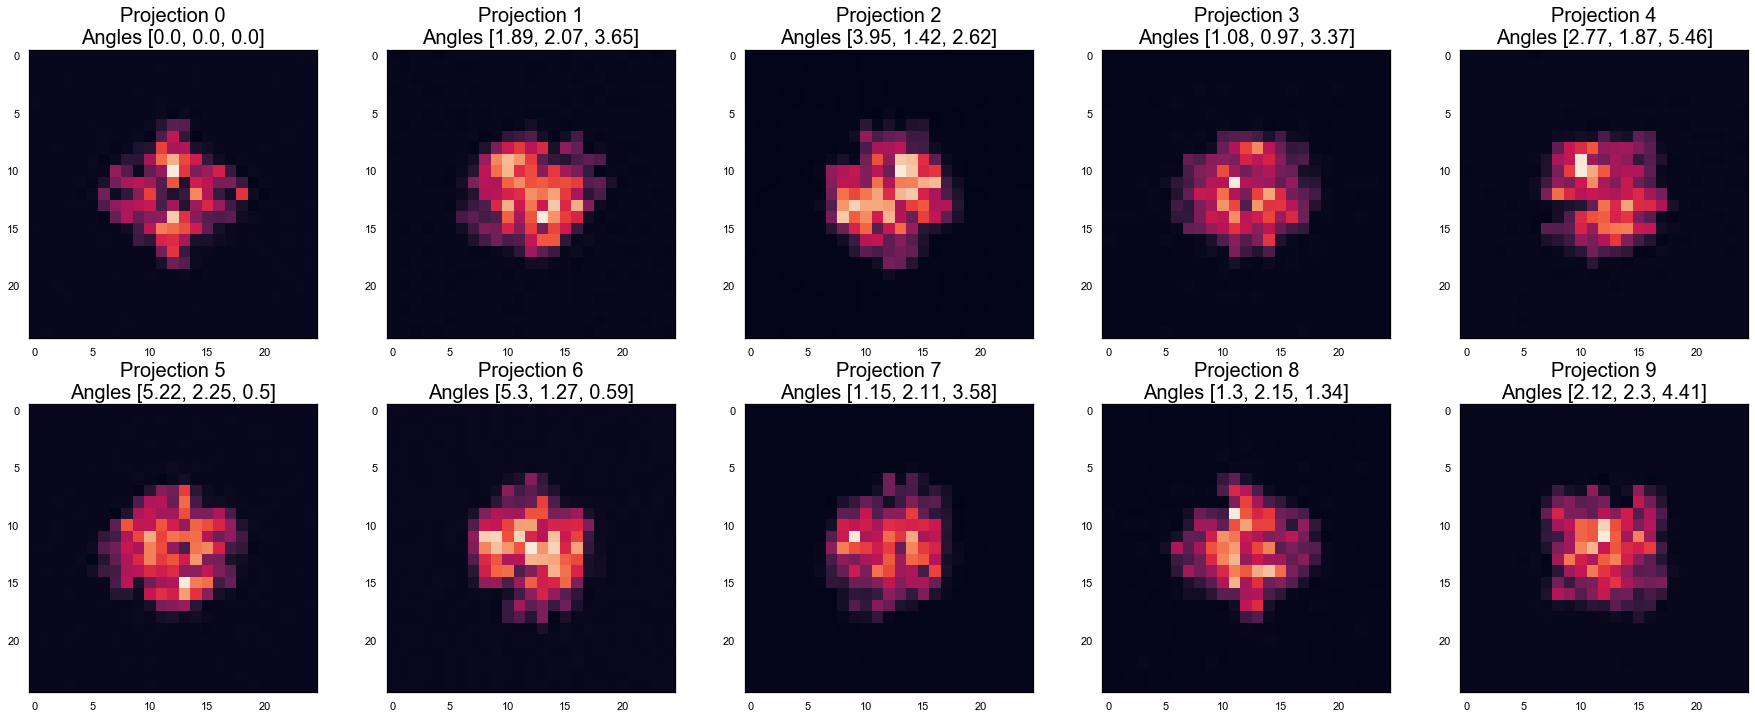

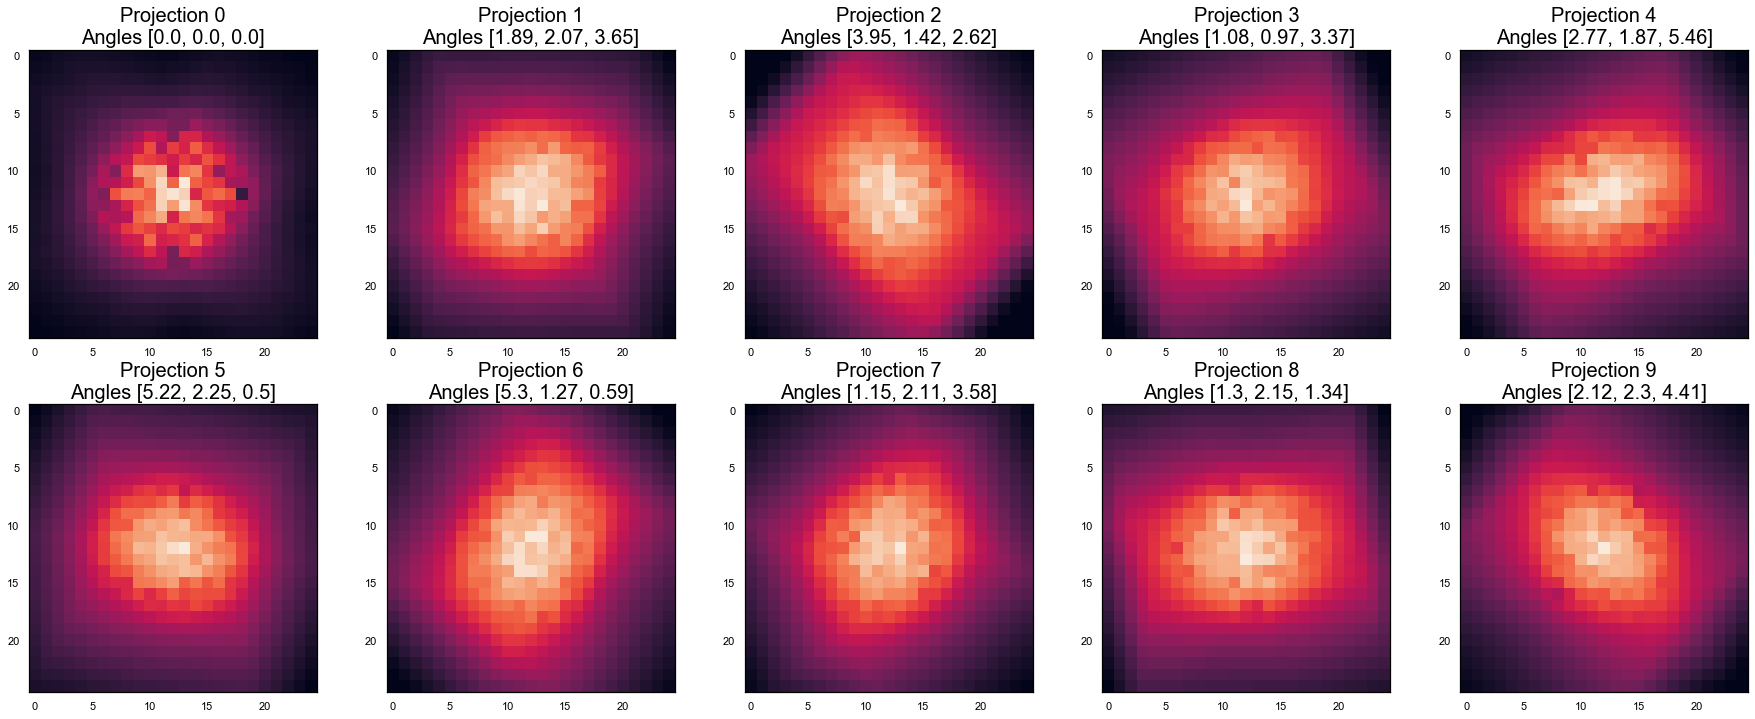

Q 10758501.712218598
delta Q 0.0
Q 10835985.899544064
delta Q 77484.18732546642
Q 10913774.935960671
delta Q 77789.03641660698
Q 10991869.643156873
delta Q 78094.70719620213
Q 11070270.708069848
delta Q 78401.06491297483
Q 11148978.59887587
delta Q 78707.89080602303
Q 11227994.541397583
delta Q 79015.94252171181
Q 11307318.806868132
delta Q 79324.26547054946
Q 11386952.165075805
delta Q 79633.35820767283
Q 11466895.428572636
delta Q 79943.26349683106
Q 11547148.969880603
delta Q 80253.54130796716
The 111-th iteration


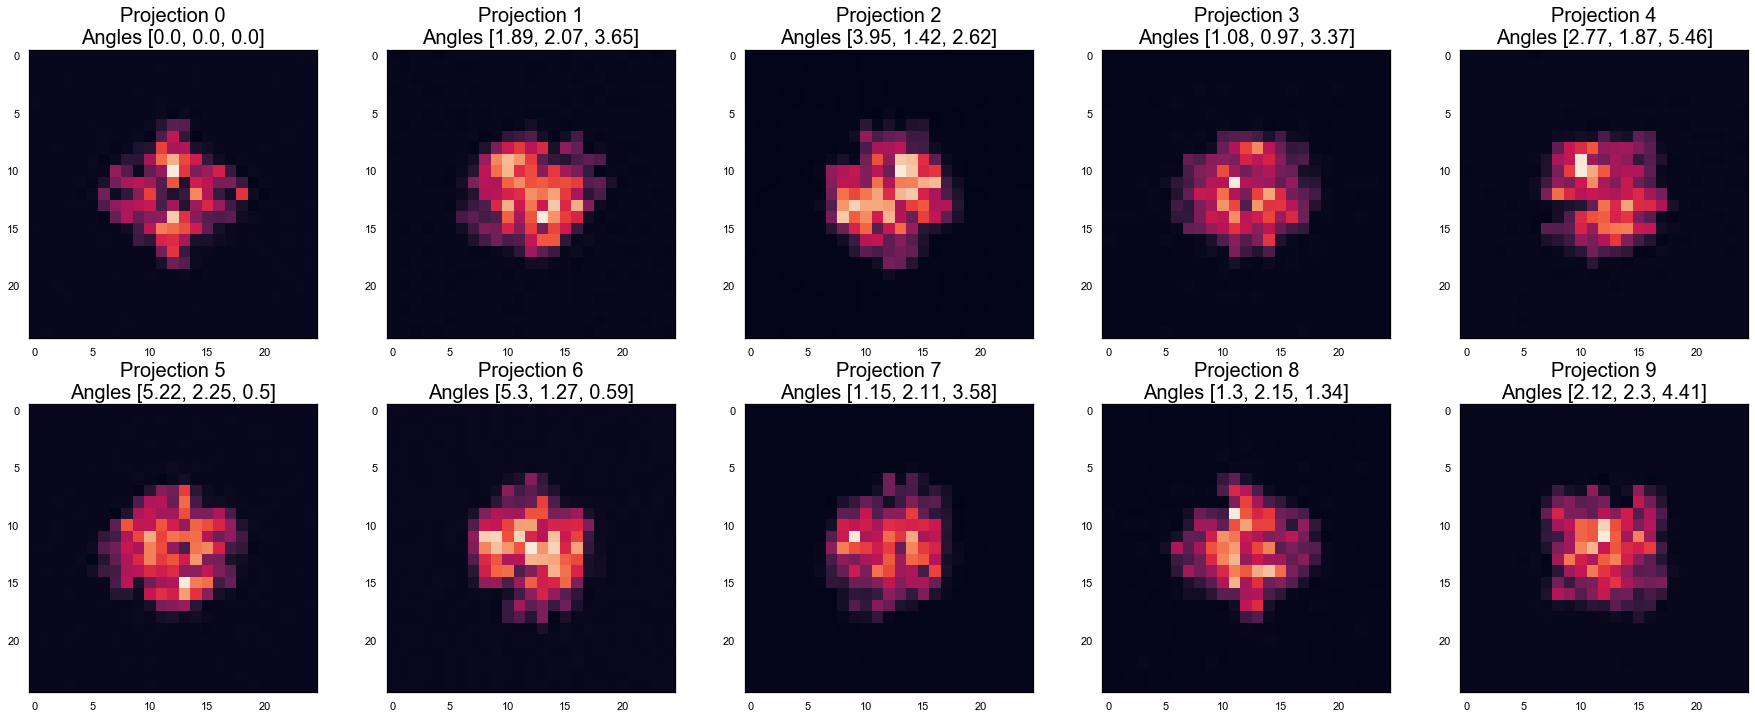

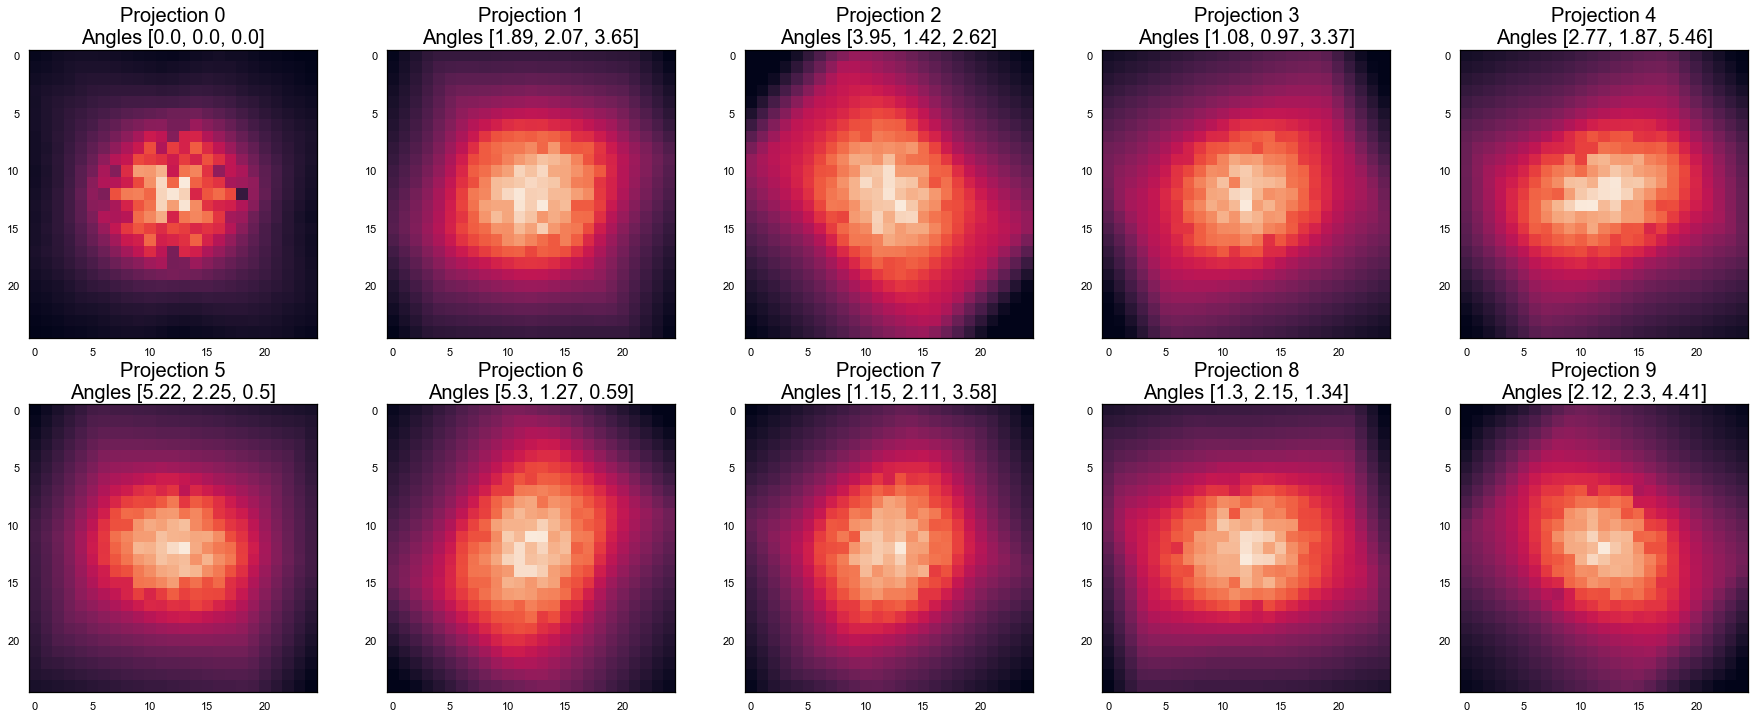

Q 11547148.969880603
delta Q 0.0
Q 11627713.874518689
delta Q 80564.90463808551
Q 11708590.143555237
delta Q 80876.26903654821
Q 11789779.187296826
delta Q 81189.04374158941
Q 11871281.311301397
delta Q 81502.12400457077
Q 11953097.176017847
delta Q 81815.86471644975
Q 12035226.898238163
delta Q 82129.72222031653
Q 12117671.691554612
delta Q 82444.79331644811
Q 12200432.336782927
delta Q 82760.64522831514
Q 12283508.847920517
delta Q 83076.51113758981
Q 12366902.177386055
delta Q 83393.32946553826
The 121-th iteration


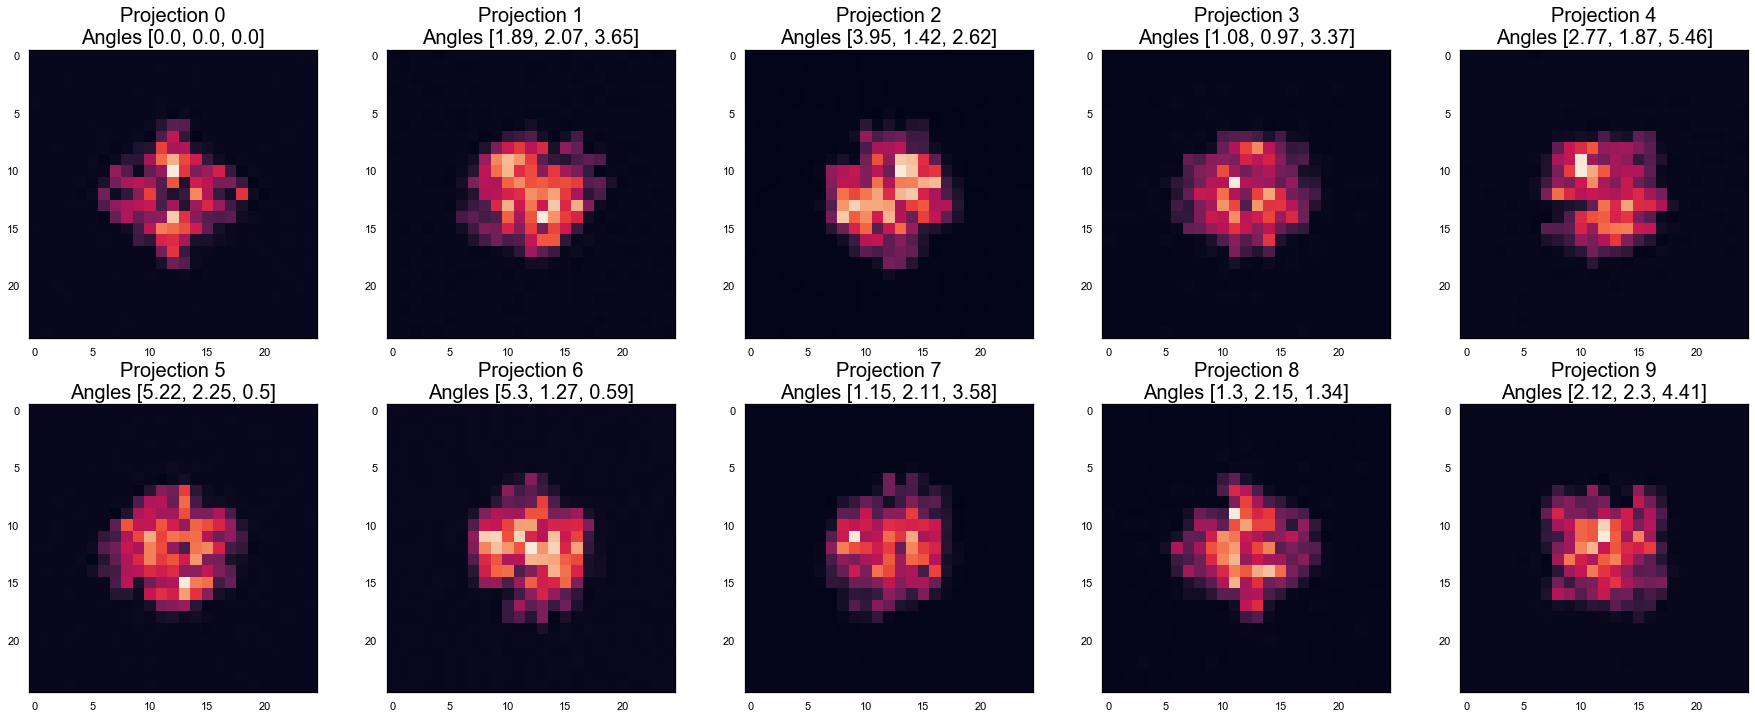

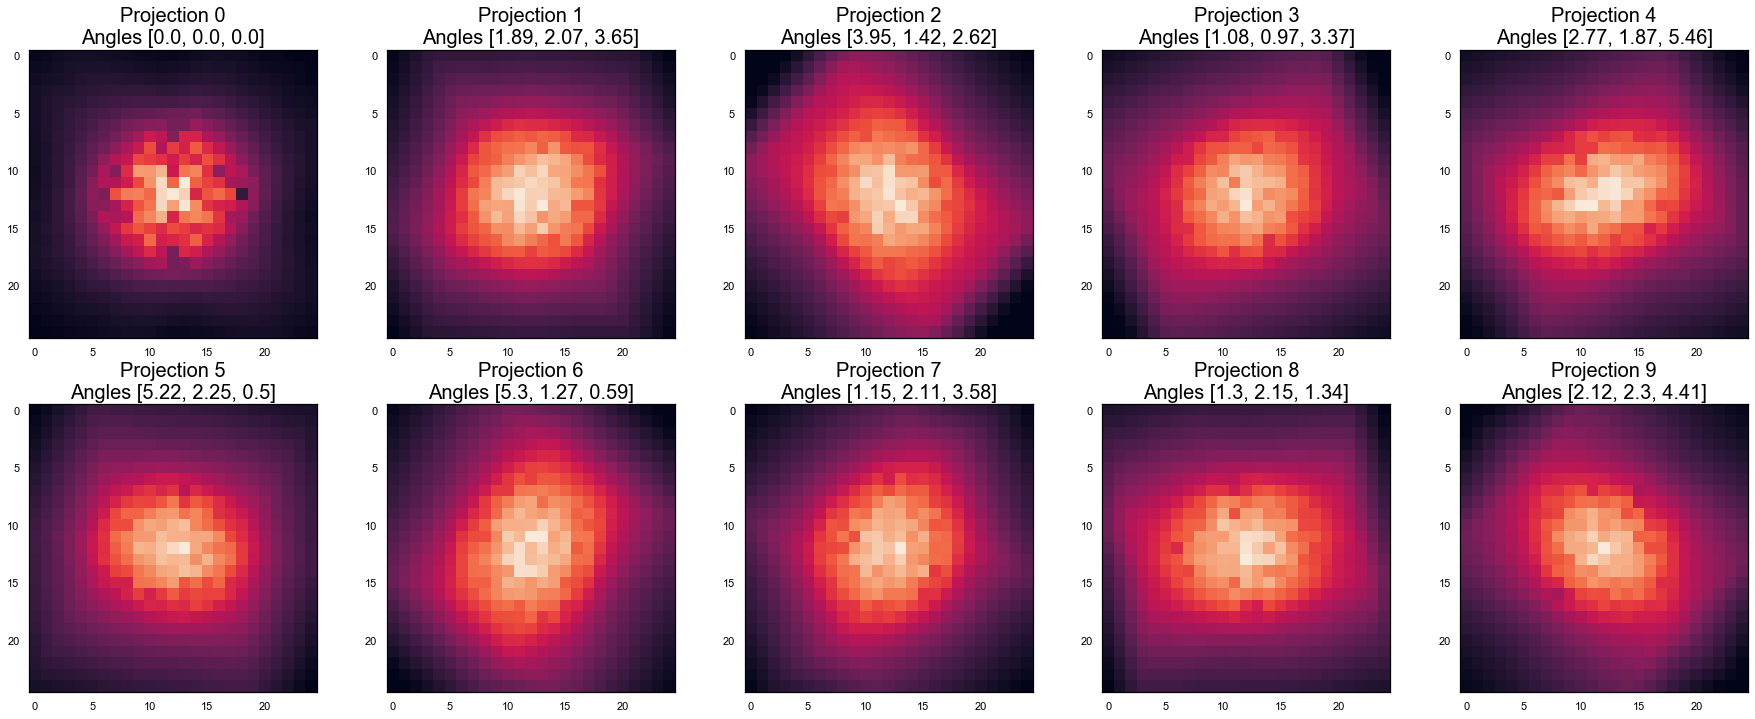

Q 12366902.177386055
delta Q 0.0
Q 12450612.698553545
delta Q 83710.52116749063
Q 12534640.974521454
delta Q 84028.27596790902
Q 12618987.993912945
delta Q 84347.01939149015
Q 12703653.412945505
delta Q 84665.41903256066
Q 12788638.63857894
delta Q 84985.22563343495
Q 12873943.882523809
delta Q 85305.24394486845
Q 12959569.603673652
delta Q 85625.72114984319
Q 13045516.323452944
delta Q 85946.71977929212
Q 13131784.552345358
delta Q 86268.2288924139
Q 13218374.898139216
delta Q 86590.34579385817
The 131-th iteration


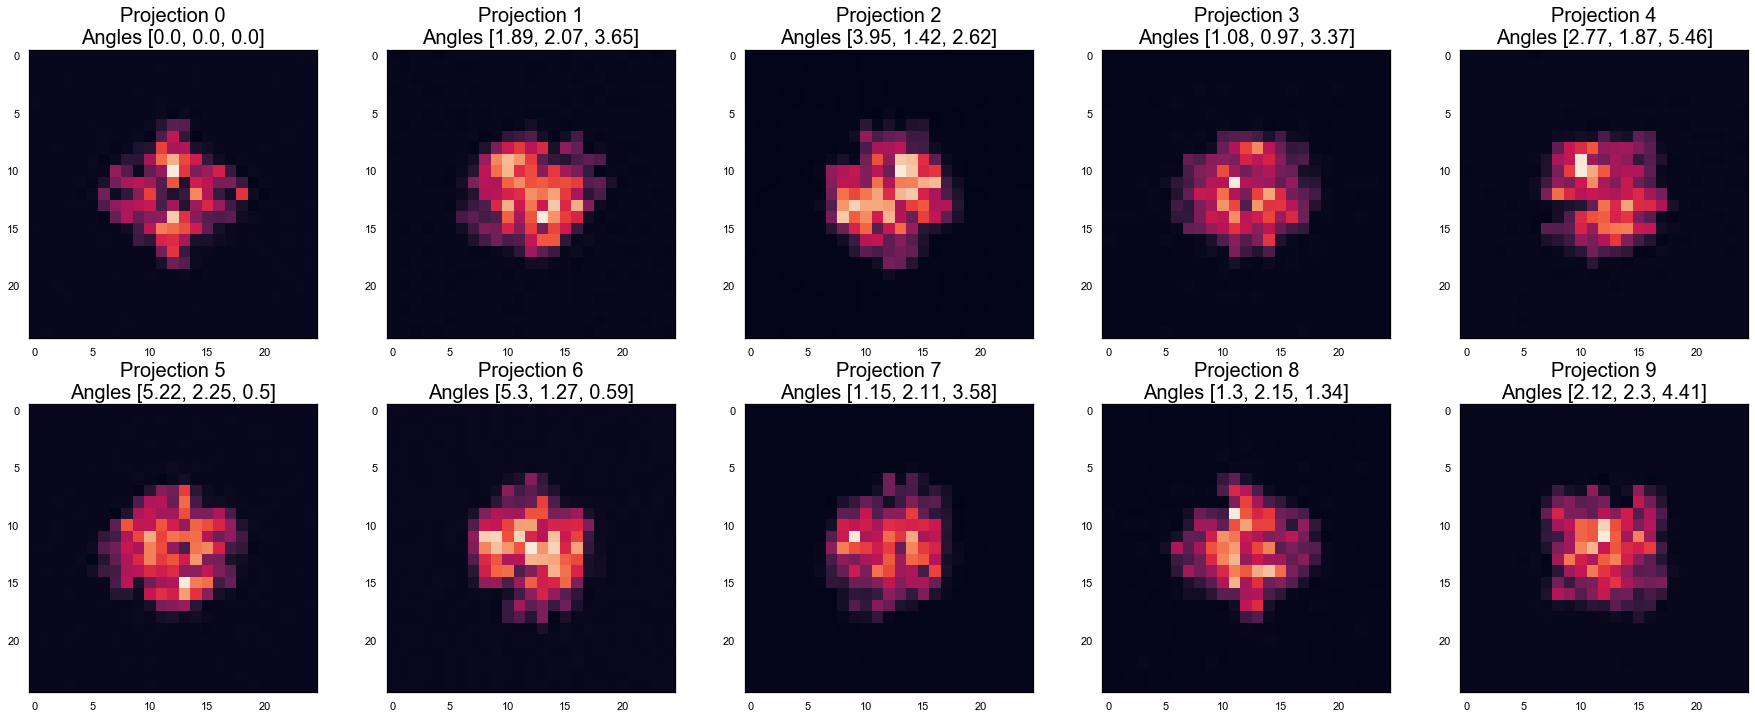

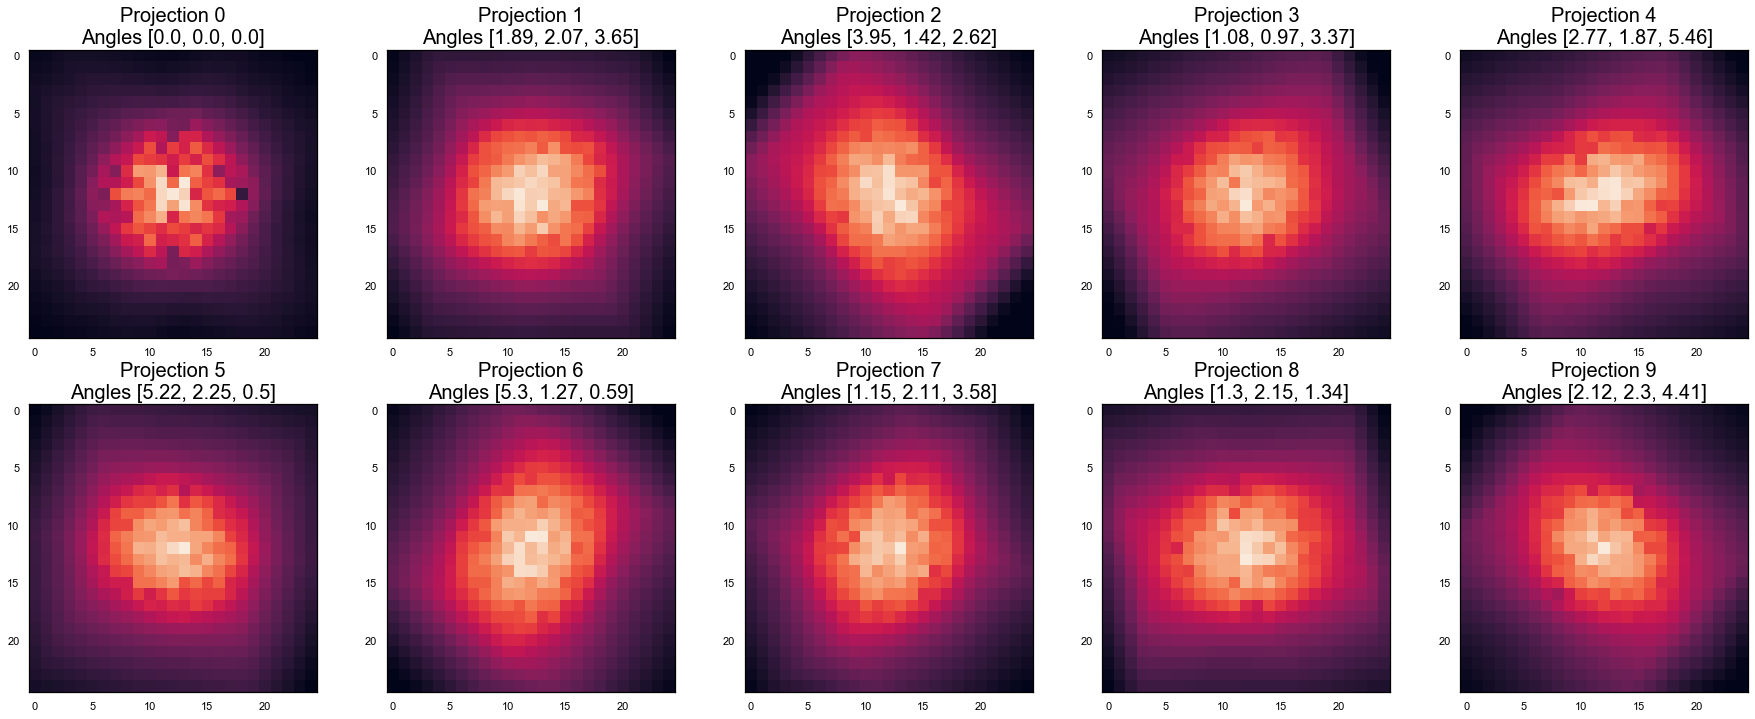

Q 13218374.898139216
delta Q 0.0
Q 13305287.52162134
delta Q 86912.62348212488
Q 13392523.389253283
delta Q 87235.86763194203
Q 13480082.459032444
delta Q 87559.06977916136
Q 13567965.558334239
delta Q 87883.09930179454
Q 13656172.730410054
delta Q 88207.1720758155
Q 13744704.69092061
delta Q 88531.96051055565
Q 13833561.945830846
delta Q 88857.25491023622
Q 13922744.608897662
delta Q 89182.66306681558
Q 14012252.859707698
delta Q 89508.25081003644
Q 14102088.02431248
delta Q 89835.1646047812
The 141-th iteration


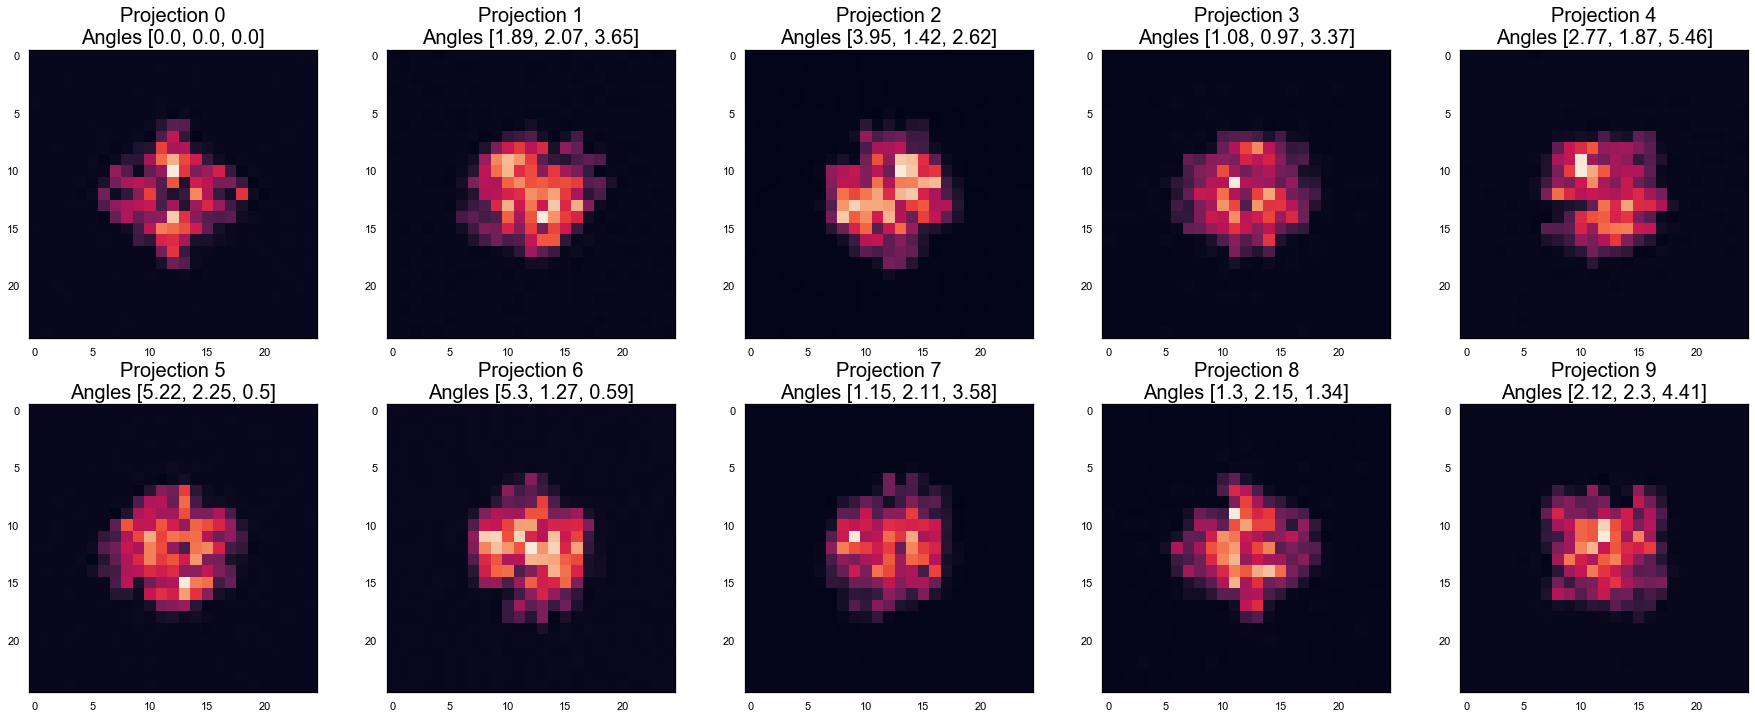

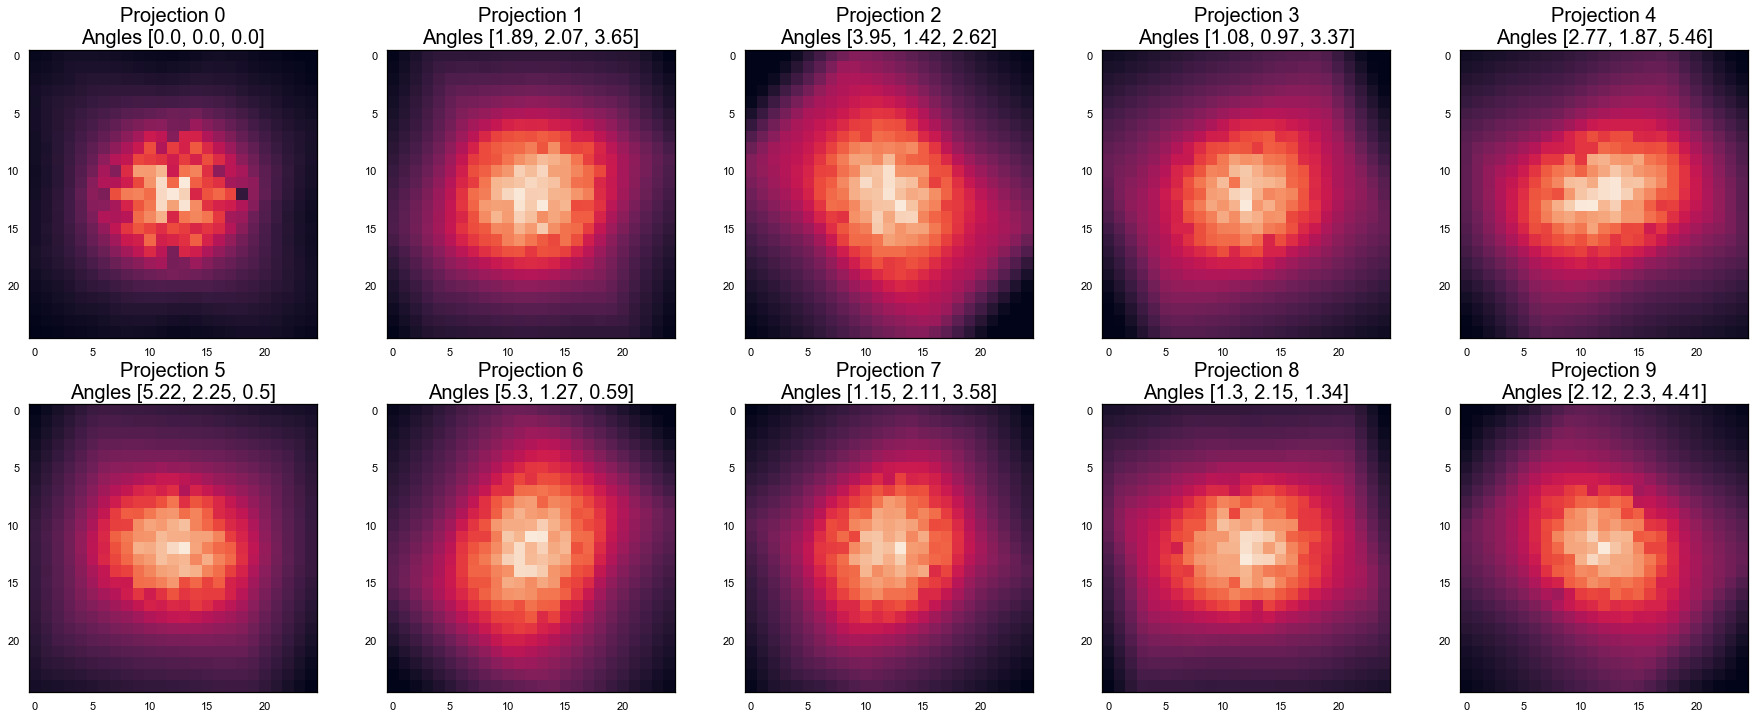

Q 14102088.02431248
delta Q 0.0
Q 14192249.495162996
delta Q 90161.47085051611
Q 14282738.037675425
delta Q 90488.54251242988
Q 14373554.067008993
delta Q 90816.02933356725
Q 14464697.564871598
delta Q 91143.49786260538
Q 14556169.038983455
delta Q 91471.47411185689
Q 14647968.863052506
delta Q 91799.82406905107
Q 14740097.090845004
delta Q 92128.22779249772
Q 14832554.190943383
delta Q 92457.10009837896
Q 14925340.268845282
delta Q 92786.07790189981
Q 15018455.876623746
delta Q 93115.60777846351
The 151-th iteration


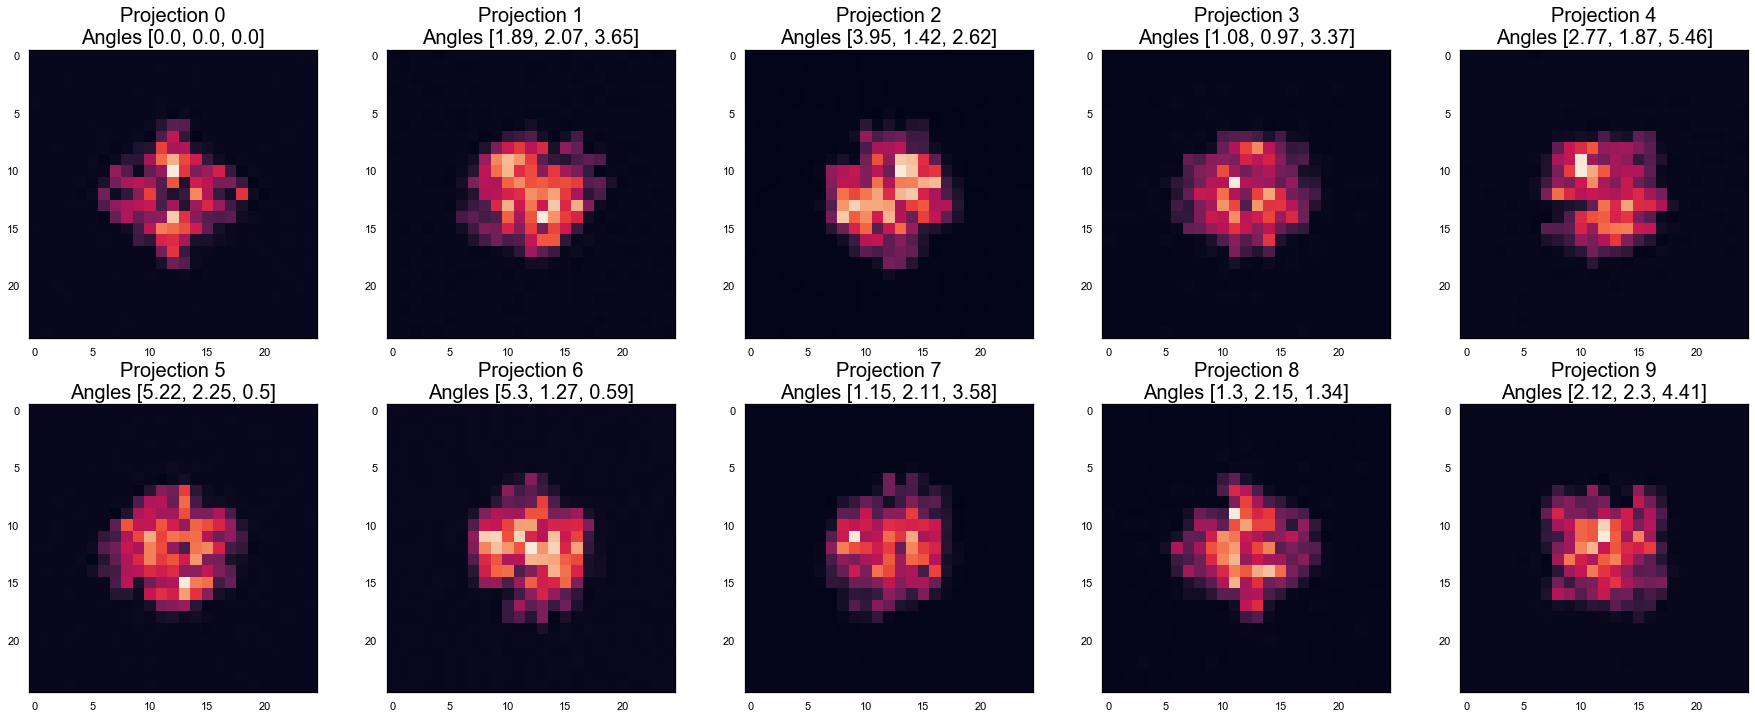

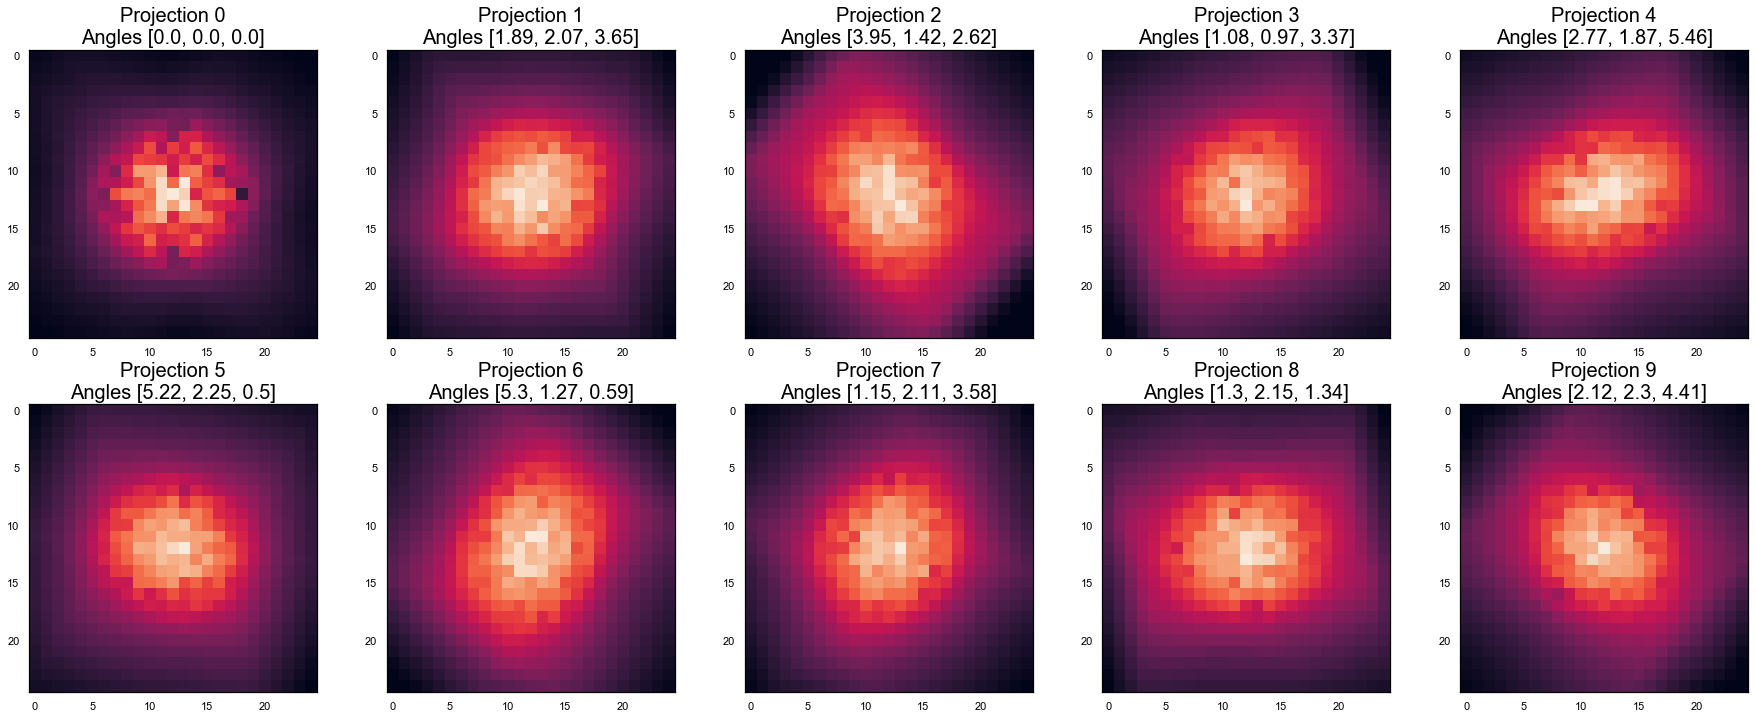

Q 15018455.876623746
delta Q 0.0
Q 15111900.834656883
delta Q 93444.95803313702
Q 15205675.582490105
delta Q 93774.74783322215
Q 15299780.398679873
delta Q 94104.8161897678
Q 15394215.431257296
delta Q 94435.03257742338
Q 15488980.756429117
delta Q 94765.32517182082
Q 15584076.39337812
delta Q 95095.63694900274
Q 15679502.725381989
delta Q 95426.33200386912
Q 15775259.81652435
delta Q 95757.09114236012
Q 15871347.54854397
delta Q 96087.73201962002


In [18]:
_, num_image , n_component = 116, 5000 , 2
print(P3R.mu.shape)
print(ProjSize1)
Mus = P3R.mu.reshape(1, ProjSize1, ProjSize1, ProjSize1)
P3RM = PCA_3d_Recon_recurssive(ProjSize1, num_image, n_component,Mus )
P3RM.Au_s(angles2)
print(P3RM.Aus.shape)
#P3RM.Plot_mu_by_projection(angles2)
#P3RM.Expectation(new_projection , angles2)
#P3RM.Maximization(new_projection , angles2)
P3RM.fit(new_projection , angles2)

In [31]:
#Check ro_j whether the same

print(True_z2.reshape(-1)[:5])
print(P3RM.ro[:5,0])
print(True_z1.reshape(-1)[:5])
print(P3RM.ro[:5,1])

print(P3RM.Mus.shape)
vec1 = P3RM.Mus[0].reshape(-1)
vec2 = P3RM.Mus[1].reshape(-1)
print(np.sum(vec1*vec2))
print(np.dot(vec1 ,vec1) /np.linalg.norm(vec1) / np.linalg.norm(vec1))
print(np.sum(vec1*vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

[ 2.08751719 -0.25337916 -0.36445553 -0.25359546  0.05210942]
[ 3.21404745 -0.26473339 -0.97069626 -0.60095073 -0.34542855]
[-0.02958446  0.44864975 -1.35269207 -0.68887292 -1.51650291]
[-0.26381879  0.24024991 -0.04960803 -0.12711447 -0.16774667]
(2, 25, 25, 25)
0.0012066971638782348
1.0
0.05023856382097017


In [ ]:
print(np.linalg.norm(Vol2))
print(np.linalg.norm(Vol1))
print(np.linalg.norm(P3R.mu))

In [ ]:
#print(P3R.mu)
ProjSize = ProjSize1
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print('the 2th component')
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
print(curremt_mu.shape)
print('P3RM.Mus[-1]',np.mean(P3RM.Mus[-1]))
print('+P3RM.Mus[0]', np.mean(P3RM.Mus[0]))
print(np.sum(np.abs(P3RM.Mus[-1]+P3RM.Mus[0])))

In [ ]:
curremt_mu = P3RM.Mus[0].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(-CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)